In [57]:
import pandas as pd

sdel=pd.read_excel("Сделки_2025-11-25.xlsx")
proj=pd.read_excel("Проектные данные_2025-11-25.xlsx")

In [33]:
import pandas as pd
import numpy as np

# === НАСТРОЙКИ ===
IQR_THRESHOLD = 1.5
MIN_PRICE_UNIT = 1_000_000

# === 0. ПОДГОТОВКА И БЕЗОПАСНОЕ ОБЪЕДИНЕНИЕ (ЧТОБЫ НАЙТИ ДАТУ СТАРТА) ===
sdel_clean = sdel.copy()
proj_clean = proj.copy()

# Названия колонок с датами, которые нам нужны
col_dogovor = 'Дата договора (месяц.год)'
col_reg = 'Дата регистрации (месяц.год)'
col_start = 'Дата начала проекта' # <--- ПРОВЕРЬ, ЧТО В ТАБЛИЦЕ PROJ ОНА НАЗЫВАЕТСЯ ТАК ЖЕ!

# Пытаемся найти дату старта. Если её нет в сделках, тащим из проектов
if col_start not in sdel_clean.columns:
    if col_start in proj_clean.columns:
        # Ищем ключ для объединения (обычно это ID проекта)
        # Пробуем самые частые варианты: 'ID проекта', 'id_project', 'ID_PROJ'
        merge_keys = [k for k in ['ID проекта', 'ID_проекта', 'id_project'] if k in sdel_clean.columns and k in proj_clean.columns]
        
        if merge_keys:
            print(f"✅ Подтягиваем '{col_start}' из таблицы проектов по ключу: {merge_keys[0]}...")
            sdel_clean = sdel_clean.merge(proj_clean[[merge_keys[0], col_start]], on=merge_keys[0], how='left')
        else:
            print(f"⚠️ ВНИМАНИЕ: Не нашел общий ID для объединения таблиц. '{col_start}' может отсутствовать!")
    else:
        print(f"⚠️ ВНИМАНИЕ: Колонки '{col_start}' нет ни в сделках, ни в проектах. Проверь название!")

# === 1. ПРЕДОБРАБОТКА (ETL) ===
def clean_numeric_col(df, col_name):
    if col_name in df.columns:
        val = df[col_name].astype(str)
        val = val.str.replace("\u00a0", "").str.replace(" ", "").str.replace(",", ".")
        return pd.to_numeric(val, errors="coerce").fillna(0)
    return df[col_name] if col_name in df.columns else 0

# Очистка чисел
target_cols = ['Сумма бюджета', 'Суммарная площадь сделок', 'Суммарное количество сделок', 
               'Этаж лота', 'Количество комнат']
for col in target_cols:
    sdel_clean[col] = clean_numeric_col(sdel_clean, col)

# === ОЧИСТКА ДАТ (САМОЕ ВАЖНОЕ) ===
# Собираем все даты, которые есть в датафрейме
all_date_cols = [c for c in [col_dogovor, col_reg, col_start] if c in sdel_clean.columns]

print("\n=== ОТЧЕТ ПО ДАТАМ (ДО ФИЛЬТРАЦИИ) ===")
for col in all_date_cols:
    # 1. Запоминаем сколько было пустых до конвертации
    na_before = sdel_clean[col].isna().sum()
    
    # 2. Конвертируем с dayfirst=True (Российский формат ДД.ММ.ГГГГ)
    # errors='coerce' превратит мусор в NaT, но мы это отследим
    sdel_clean[col] = pd.to_datetime(sdel_clean[col], dayfirst=True, errors='coerce')
    
    # 3. Считаем сколько стало пустых
    na_after = sdel_clean[col].isna().sum()
    lost = na_after - na_before
    
    print(f"Колонка '{col}':")
    if lost > 0:
        print(f"  ❌ БИТЫЙ ФОРМАТ: {lost} значений не удалось прочитать (превратились в NaT).")
    else:
        print(f"  ✅ Все значения успешно распознаны.")

# Расчет удельных метрик
sdel_clean['cnt_safe'] = sdel_clean['Суммарное количество сделок'].replace(0, 1)
sdel_clean['Unit_Area'] = sdel_clean['Суммарная площадь сделок'] / sdel_clean['cnt_safe']
sdel_clean['Unit_Price'] = sdel_clean['Сумма бюджета'] / sdel_clean['cnt_safe']
sdel_clean['Price_m2'] = sdel_clean['Сумма бюджета'] / sdel_clean['Суммарная площадь сделок'].replace(0, np.nan)


# === 2. УМНАЯ ФИЛЬТРАЦИЯ: ПЛОЩАДЬ vs КОМНАТЫ ===
mask_area_rooms_outlier = pd.Series(False, index=sdel_clean.index)
unique_rooms = sorted(sdel_clean['Количество комнат'].unique())

print("\n=== ФИЛЬТРАЦИЯ ПЛОЩАДЕЙ ===")
for room_cnt in unique_rooms:
    idx_room = sdel_clean[sdel_clean['Количество комнат'] == room_cnt].index
    if len(idx_room) == 0: continue
    
    subset_areas = sdel_clean.loc[idx_room, 'Unit_Area']
    Q1 = subset_areas.quantile(0.25)
    Q3 = subset_areas.quantile(0.75)
    IQR = Q3 - Q1
    lower = max(Q1 - (IQR_THRESHOLD * IQR), 10.0)
    upper = Q3 + (IQR_THRESHOLD * IQR)
    
    bad_indices = subset_areas[(subset_areas < lower) | (subset_areas > upper)].index
    mask_area_rooms_outlier.loc[bad_indices] = True

# === 3. ОСТАЛЬНЫЕ ФИЛЬТРЫ ===
Q1_p = sdel_clean['Price_m2'].quantile(0.25)
Q3_p = sdel_clean['Price_m2'].quantile(0.75)
IQR_p = Q3_p - Q1_p
mask_price_outlier = (sdel_clean['Price_m2'] < (Q1_p - 1.5*IQR_p)) | (sdel_clean['Price_m2'] > (Q3_p + 1.5*IQR_p))

mask_cheap = sdel_clean['Unit_Price'] < MIN_PRICE_UNIT

# === 4. СБОРКА ИТОГОВОГО ДАТАСЕТА ===
total_mask = mask_area_rooms_outlier | mask_price_outlier | mask_cheap 
sdel_final = sdel_clean[~total_mask].copy()

# === 5. ФИНАЛЬНЫЙ ОТЧЕТ ===
print("\n" + "="*60)
print(f"ИТОГИ ОЧИСТКИ (Было: {len(sdel_clean)} -> Стало: {len(sdel_final)})")
print("-" * 60)
    
print("-" * 60)
print(f"Удалено строк всего: {total_mask.sum()}")
sdel_final.drop(columns=['cnt_safe'], inplace=True, errors='ignore')

⚠️ ВНИМАНИЕ: Колонки 'Дата начала проекта' нет ни в сделках, ни в проектах. Проверь название!

=== ОТЧЕТ ПО ДАТАМ (ДО ФИЛЬТРАЦИИ) ===
Колонка 'Дата договора (месяц.год)':
  ✅ Все значения успешно распознаны.
Колонка 'Дата регистрации (месяц.год)':
  ✅ Все значения успешно распознаны.

=== ФИЛЬТРАЦИЯ ПЛОЩАДЕЙ ===

ИТОГИ ОЧИСТКИ (Было: 50955 -> Стало: 47983)
------------------------------------------------------------
------------------------------------------------------------
Удалено строк всего: 2972


In [34]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings

warnings.filterwarnings('ignore')

def process_real_estate_data(
    proj: str, 
    deals: str, 
    bank_percentile_range: tuple = (0, 100),
    bank_metric_for_filtering: str = 'sq_meters', # 'count', 'sq_meters', 'money'
    weight_menric:str = 'sq_meters'
):
    """
    Основная функция ETL для подготовки данных.
    
    МОДИФИКАЦИЯ: 
    Расчет Sellout (Sold_Area) теперь производится СТРОГО ПО ИПОТЕЧНЫМ СДЕЛКАМ,
    чтобы соответствовать логике анализа ипотечного покрытия (как в Script A).
    
    Параметры:
    ----------
    path_proj : str - путь к файлу проектов
    path_deals : str - путь к файлу сделок
    bank_percentile_range : tuple - (min_p, max_p). Пример (25, 75).
    bank_metric_for_filtering : str - метрика для фильтрации банков.
    
    Возвращает:
    ----------
    df_ml : pd.DataFrame - итоговый датасет
    bank_stats : pd.DataFrame - статистика по банкам
    report : dict - технические метрики
    """
    
    print(f"🚀 ЗАПУСК ОБРАБОТКИ ДАННЫХ (РЕЖИМ: ИПОТЕЧНЫЙ SELLOUT)")
    print(f"   Фильтрация банков-фичей: процентили {bank_percentile_range}, метрика '{bank_metric_for_filtering}'")
    
    # ==========================================
    # 1. ЗАГРУЗКА И ОЧИСТКА ЧИСЕЛ
    # ==========================================
    def clean_numeric_col(df, col_name):
        if col_name in df.columns:
            val = df[col_name].astype(str)
            val = val.str.replace("\u00a0", "").str.replace(" ", "").str.replace(",", ".")
            return pd.to_numeric(val, errors="coerce").fillna(0)
        return df[col_name] if col_name in df.columns else 0

    # Очистка площадей
    for col in ["Общая проектная площадь", "Суммарная площадь сделок", 
                "Суммарное количество сделок", "Суммарная стоимость сделок"]:
        if col in proj.columns: proj[col] = clean_numeric_col(proj, col)
        if col in deals.columns: deals[col] = clean_numeric_col(deals, col)
    
    if "Суммарное количество сделок" not in deals.columns:
        deals["Суммарное количество сделок"] = 1
    
    # Очистка дат
    deals["dt_deal"] = pd.to_datetime(deals["Дата договора (месяц.год)"], dayfirst=True, errors="coerce")
    mask_date_na = deals["dt_deal"].isna()
    if mask_date_na.any():
        deals.loc[mask_date_na, "dt_deal"] = pd.to_datetime(
            "01." + deals.loc[mask_date_na, "Дата договора (месяц.год)"].astype(str), 
            dayfirst=True, errors="coerce"
        )
    deals = deals.dropna(subset=["dt_deal"])

    # Очистка ID и Проектов
    for df in [proj, deals]:
        df['ID корпуса'] = df['ID корпуса'].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()
        if "Проект" in df.columns: df["Проект"] = df["Проект"].astype(str).str.strip()

    # Мэппинг проектов
    corpus_map = proj[["ID корпуса", "Проект", "Класс проекта"]].drop_duplicates().set_index("ID корпуса")
    deals = deals.merge(corpus_map, on="ID корпуса", how="left")
    if "Проект_y" in deals.columns:
        deals["Проект"] = deals["Проект_y"].fillna(deals["Проект_x"])
    deals = deals.dropna(subset=["Проект"])
    
    # Список значений, обозначающих ипотеку (для фильтрации)
    mortgage_flags = ['да', 'yes', 'true', '1', 'ипотека']

    # ==========================================
    # 2. АНАЛИЗ БАНКОВ И РАСЧЕТ ВЕСОВ
    # ==========================================
    print("\n🏦 АНАЛИЗ БАНКОВСКОГО СЕКТОРА...")
    
    if "Название банка" not in deals.columns:
        deals["Название банка"] = "Не указан"
    deals["Название банка"] = deals["Название банка"].fillna("Рассрочка/Кэш").astype(str).str.strip()
    
    # Для статистики банков берем ВСЕ сделки (чтобы понимать общий объем рынка)
    # Но если мы хотим анализировать именно ИПОТЕЧНЫХ игроков, можно отфильтровать deals перед groupby.
    # В данном случае оставляем логику Script B: смотрим все сделки, где указан банк.
    
    grp_cols = {"Суммарное количество сделок": "sum", "Суммарная площадь сделок": "sum"}
    if "Сумма бюджета" in deals.columns:
        grp_cols["Сумма бюджета"] = "sum"
        
    bank_stats = deals.groupby("Название банка").agg(grp_cols).reset_index()
    
    rename_map = {
        "Суммарное количество сделок": "count",
        "Суммарная площадь сделок": "sq_meters",
        "Сумма бюджета": "money"
    }
    bank_stats = bank_stats.rename(columns=rename_map)
    if "money" not in bank_stats.columns: bank_stats["money"] = 0
    
    total_sq = bank_stats["sq_meters"].sum()
    bank_stats["share_sq_meters"] = (bank_stats["sq_meters"] / total_sq * 100)
    
    target_metric = bank_metric_for_filtering if bank_metric_for_filtering in bank_stats.columns else 'sq_meters'
    print(bank_stats.columns)
    
    threshold_low = np.percentile(bank_stats[target_metric], bank_percentile_range[0])
    threshold_high = np.percentile(bank_stats[target_metric], bank_percentile_range[1])
    
    bank_stats["is_selected"] = (bank_stats[target_metric] >= threshold_low) & \
                                (bank_stats[target_metric] <= threshold_high)
    
    bank_stats["bank_weight_score"] = np.log1p(bank_stats[weight_menric])
    
    selected_banks = bank_stats[bank_stats["is_selected"]]["Название банка"].tolist()
    bank_weights_dict = bank_stats.set_index("Название банка")["bank_weight_score"].to_dict()
    
    print(f"   Всего уникальных банков: {len(bank_stats)}")
    print(f"   Отобрано банков (диапазон {bank_percentile_range}%): {len(selected_banks)}")

    # ==========================================
    # 3. МАКРО-ДАННЫЕ
    # ==========================================
    key_rate_data = [
        ('2013-09-13', '2014-03-02', 5.50), ('2014-03-03', '2014-04-24', 7.00), ('2014-04-25', '2014-07-27', 7.50),
        ('2014-07-28', '2014-11-04', 8.00), ('2014-11-05', '2014-12-11', 9.50), ('2014-12-12', '2014-12-15', 10.50),
        ('2014-12-16', '2015-02-01', 17.00), ('2015-02-02', '2015-03-15', 15.00), ('2015-03-16', '2015-05-04', 14.00),
        ('2015-05-05', '2015-06-15', 12.50), ('2015-06-16', '2015-08-02', 11.50), ('2015-08-03', '2016-06-13', 11.00),
        ('2016-06-14', '2016-09-18', 10.50), ('2016-09-19', '2017-03-26', 10.00), ('2017-03-27', '2017-05-01', 9.75),
        ('2017-05-02', '2017-06-18', 9.25), ('2017-06-19', '2017-09-17', 9.00), ('2017-09-18', '2017-10-29', 8.50),
        ('2017-10-30', '2017-12-17', 8.25), ('2017-12-18', '2018-02-11', 7.75), ('2018-02-12', '2018-03-25', 7.50),
        ('2018-03-26', '2018-09-16', 7.25), ('2018-09-17', '2018-12-16', 7.50), ('2018-12-17', '2019-06-16', 7.75),
        ('2019-06-17', '2019-07-28', 7.50), ('2019-07-29', '2019-09-08', 7.25), ('2019-09-09', '2019-10-27', 7.00),
        ('2019-10-28', '2019-12-15', 6.50), ('2019-12-16', '2020-02-09', 6.25), ('2020-02-10', '2020-04-26', 6.00),
        ('2020-04-27', '2020-06-21', 5.50), ('2020-06-22', '2020-07-26', 4.50), ('2020-07-27', '2021-03-21', 4.25),
        ('2021-03-22', '2021-04-25', 4.50), ('2021-04-26', '2021-06-14', 5.00), ('2021-06-15', '2021-07-25', 5.50),
        ('2021-07-26', '2021-09-12', 6.50), ('2021-09-13', '2021-10-24', 6.75), ('2021-10-25', '2021-12-19', 7.50),
        ('2021-12-20', '2022-02-13', 8.50), ('2022-02-14', '2022-02-27', 9.50), ('2022-02-28', '2022-04-10', 20.00),
        ('2022-04-11', '2022-05-03', 17.00), ('2022-05-04', '2022-05-26', 14.00), ('2022-05-27', '2022-06-13', 11.00),
        ('2022-06-14', '2022-07-24', 9.50), ('2022-07-25', '2022-09-18', 8.00), ('2022-09-19', '2022-12-31', 7.50),
        ('2023-01-01', '2023-07-26', 7.5), ('2023-07-27', '2023-08-14', 8.5), ('2023-08-15', '2023-09-17', 12.0),
        ('2023-09-18', '2023-10-29', 13.0), ('2023-10-30', '2023-12-17', 15.0), ('2023-12-18', '2024-07-28', 16.0),
        ('2024-07-29', '2024-09-15', 18.0), ('2024-09-16', '2024-12-27', 19.0), ('2024-12-28', '2025-06-08', 21.0)
    ]
    macro_range = pd.date_range(start='2013-09-13', end='2026-01-01', freq='D')
    macro_df = pd.DataFrame(index=macro_range)
    macro_df['key_rate'] = np.nan
    macro_df['is_subsidy'] = 0

    for start, end, rate in key_rate_data:
        mask = (macro_df.index >= pd.to_datetime(start)) & (macro_df.index <= pd.to_datetime(end))
        macro_df.loc[mask, 'key_rate'] = rate

    macro_df['key_rate'] = macro_df['key_rate'].ffill()
    macro_df.loc[(macro_df.index >= '2020-04-17') & (macro_df.index < '2024-07-01'), 'is_subsidy'] = 1
    macro_monthly = macro_df['key_rate'].resample('MS').mean()

    def get_macro_features(start_date, end_date):
        subset_daily = macro_df[(macro_df.index >= start_date) & (macro_df.index <= end_date)]
        if subset_daily.empty: return np.nan, np.nan, 0, np.nan
        kr_start = subset_daily['key_rate'].iloc[0]
        kr_spread = subset_daily['key_rate'].max() - subset_daily['key_rate'].min()
        sub_share = subset_daily['is_subsidy'].mean()
        subset_monthly = macro_monthly[(macro_monthly.index >= start_date) & (macro_monthly.index <= end_date)]
        kr_mean_monthly = subset_daily['key_rate'].mean() if subset_monthly.empty else subset_monthly.mean()
        return kr_start, kr_spread, sub_share, kr_mean_monthly

    # ==========================================
    # 4. СБОРКА ДАТАСЕТА (MAIN LOOP)
    # ==========================================
    corpus_starts = deals.groupby("ID корпуса")["dt_deal"].min().reset_index().rename(columns={"dt_deal": "corpus_start"})
    proj = proj.merge(corpus_starts, on="ID корпуса", how="left")
    
    temp_proj_starts = proj.groupby("Проект")["corpus_start"].min().reset_index().rename(columns={"corpus_start": "project_start_implied"})
    proj = proj.merge(temp_proj_starts, on="Проект", how="left")
    proj["corpus_start"] = proj["corpus_start"].fillna(proj["project_start_implied"])
    
    proj_starts = proj.groupby("Проект")["corpus_start"].min().reset_index().rename(columns={"corpus_start": "project_start"})
    MAX_DATE = deals["dt_deal"].max()
    
    data_list = []
    projects_list = proj_starts["Проект"].unique()
    
    stats_cnt = {"total": len(projects_list), "success": 0, "skipped_young": 0, "skipped_no_sales": 0, "dropped_bad_so": 0}

    print(f"\n🔄 ОБРАБОТКА ПРОЕКТОВ ({len(projects_list)} шт)...")

    for project in projects_list:
        t0 = proj_starts.loc[proj_starts["Проект"] == project, "project_start"].values[0]
        t0 = pd.to_datetime(t0)
        if pd.isna(t0): continue
        
        p_class = proj[proj["Проект"] == project]["Класс проекта"].iloc[0]
        
        # --- ГОД 1 ---
        t_end_y1 = t0 + timedelta(days=365)
        
        if (MAX_DATE - t0).days < 365:
            stats_cnt["skipped_young"] += 1
            continue

        # ПЛОЩАДЬ (Знаменатель)
        valid_corp_y1 = proj[(proj["Проект"] == project) & (proj["corpus_start"] <= t_end_y1)]
        area_planned_y1 = valid_corp_y1["Общая проектная площадь"].sum()
        
        # СДЕЛКИ (Числитель) - ТЕПЕРЬ СЧИТАЕМ ТОЛЬКО ИПОТЕЧНЫЕ СДЕЛКИ
        mask_sales_y1 = (deals["Проект"] == project) & (deals["dt_deal"] >= t0) & (deals["dt_deal"] <= t_end_y1)
        deals_subset_y1 = deals[mask_sales_y1]
        
        # Фильтр: Только ипотечные сделки для расчета Sellout
        mortgage_deals_y1 = deals_subset_y1[deals_subset_y1["Ипотека"].astype(str).str.lower().isin(mortgage_flags)]
        
        # ВАЖНО: sales_y1 теперь = площадь ипотечных сделок (как в Script A)
        sales_y1 = mortgage_deals_y1["Суммарная площадь сделок"].sum()
        
        # Если проект вообще не продавался в ипотеку или нет площади - пропускаем (или ставим 0, но лучше пропустить)
        if sales_y1 <= 0 or area_planned_y1 <= 0:
            stats_cnt["skipped_no_sales"] += 1
            continue

        # МАКРО
        kr_start, kr_spread, sub_share, kr_mean = get_macro_features(t0, t_end_y1)
        
        # ДОП. МЕТРИКИ (Доля ипотеки от всех сделок)
        # Считаем относительно всего объема сделок (deals_subset_y1), а не только ипотечных
        mort_share = len(mortgage_deals_y1) / len(deals_subset_y1) if len(deals_subset_y1) > 0 else 0
        
        # ФИЧИ БАНКОВ (Считаем на основе ипотечной подвыборки)
        banks_in_project = mortgage_deals_y1[mortgage_deals_y1["Название банка"].isin(selected_banks)]["Название банка"].unique()
        
        num_banks_filtered = len(banks_in_project)
        bank_weighted_index = sum([bank_weights_dict.get(b, 0) for b in banks_in_project])

        so_val = (sales_y1 / area_planned_y1) * 100
        
        data_list.append({
            "Project": project,
            "Class": p_class,
            "Year_Num": 1,
            "Planned_Area": area_planned_y1,
            "Sold_Area": sales_y1, # Это Mortgage Sold Area
            "Sellout": so_val,     # Это Mortgage Sellout
            "KR_Start": kr_start,
            "KR_Spread": kr_spread,
            "KR_Mean": kr_mean,
            "Subsidy_Share": sub_share,
            "Mortgage_Share": mort_share,
            "Num_Banks_Filtered": num_banks_filtered,
            "Bank_Index_Weighted": bank_weighted_index,
            "Log_Area": np.log1p(area_planned_y1)
        })

        # --- ГОД 2 ---
        t_start_y2 = t_end_y1 + timedelta(days=1)
        t_end_y2 = t0 + timedelta(days=730)
        
        if (MAX_DATE - t0).days >= 730:
            valid_corp_y2 = proj[(proj["Проект"] == project) & (proj["corpus_start"] <= t_end_y2)]
            area_planned_y2 = valid_corp_y2["Общая проектная площадь"].sum()
            
            mask_sales_y2 = (deals["Проект"] == project) & (deals["dt_deal"] >= t_start_y2) & (deals["dt_deal"] <= t_end_y2)
            deals_subset_y2 = deals[mask_sales_y2]
            
            # Фильтр: Только ипотечные сделки для расчета Sellout (Год 2)
            mortgage_deals_y2 = deals_subset_y2[deals_subset_y2["Ипотека"].astype(str).str.lower().isin(mortgage_flags)]
            sales_y2 = mortgage_deals_y2["Суммарная площадь сделок"].sum()
            
            kr_start_2, kr_spread_2, sub_share_2, kr_mean_2 = get_macro_features(t_start_y2, t_end_y2)
            
            mort_share_2 = len(mortgage_deals_y2) / len(deals_subset_y2) if len(deals_subset_y2) > 0 else 0
            
            banks_in_project_2 = mortgage_deals_y2[mortgage_deals_y2["Название банка"].isin(selected_banks)]["Название банка"].unique()
            bank_weighted_index_2 = sum([bank_weights_dict.get(b, 0) for b in banks_in_project_2])

            if area_planned_y2 > 0 and sales_y2 > 0:
                data_list.append({
                    "Project": project,
                    "Class": p_class,
                    "Year_Num": 2,
                    "Planned_Area": area_planned_y2,
                    "Sold_Area": sales_y2, # Mortgage Area
                    "Sellout": (sales_y2 / area_planned_y2) * 100, # Mortgage Sellout
                    "KR_Start": kr_start_2,
                    "KR_Spread": kr_spread_2,
                    "KR_Mean": kr_mean_2,
                    "Subsidy_Share": sub_share_2,
                    "Mortgage_Share": mort_share_2,
                    "Num_Banks_Filtered": len(banks_in_project_2),
                    "Bank_Index_Weighted": bank_weighted_index_2,
                    "Log_Area": np.log1p(area_planned_y2)
                })

    # ==========================================
    # 5. ФИНАЛИЗАЦИЯ
    # ==========================================
    df_ml = pd.DataFrame(data_list)
    
    # Фильтр выбросов (>100%)
    if not df_ml.empty:
        n_before = len(df_ml)
        df_ml = df_ml[df_ml["Sellout"] <= 100]
        stats_cnt["dropped_bad_so"] = n_before - len(df_ml)
        stats_cnt["success"] = len(df_ml)
    
    print("\n✅ ГОТОВО!")
    print(f"   Сформировано строк для ML: {len(df_ml)}")
    print(f"   Ошибок Sellout>100%: {stats_cnt['dropped_bad_so']}")

    report = stats_cnt
    
    return df_ml, bank_stats, report

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# Настройки стиля
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 6) # Сделали пошире, чтобы вместить 3 графика
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Словарь для красивых названий в отчетах
TRANS_MAP = {
    "const": "Константа",
    "Num_Banks_Filtered": "Кол-во банков",
    "Bank_Index_Weighted": "Вес банков (Log площади)",
    "Log_Area": "Масштаб проекта (Log м²)",
    "KR_Mean": "Ср. Ключевая ставка",
    "Subsidy_Share": "Доля Субсидий",
    "Mortgage_Share": "Доля Ипотеки",
    "Sellout": "Селаут (%)"
}

def advanced_analysis(df, features, target, title, year_filter=None):
    """
    Универсальная функция: Строит модель, выводит отчет + 3 графика диагностики (вкл. QQ-Plot).
    """
    # Фильтрация по году, если нужно
    if year_filter:
        data = df[df["Year_Num"] == year_filter].copy()
        prefix = f"[ГОД {year_filter}]"
    else:
        data = df.copy()
        prefix = "[ВСЕ ГОДЫ]"
        
    full_title = f"{prefix} {title}"
    
    # Очистка
    data = data.dropna(subset=features + [target])
    
    # Подготовка X и y
    X = sm.add_constant(data[features])
    y = data[target]
    
    # Обучение
    model = sm.OLS(y, X).fit()
    
    # === 1. ТЕКСТОВОЙ ОТЧЕТ ===
    print(f"\n{'='*80}")
    print(f"🚀 МОДЕЛЬ: {full_title}")
    print(f"{'='*80}")
    
    # Основные метрики
    print(f"📌 R-squared (Точность):      {model.rsquared:.4f}")
    print(f"📌 Adj. R-squared (Честный):  {model.rsquared_adj:.4f}")
    print(f"📌 F-statistic p-value:       {model.f_pvalue:.4e}")
    print("-" * 80)
    
    # Красивая табличка коэффициентов
    summary_df = pd.DataFrame({
        "Коэффициент": model.params,
        "Std. Error": model.bse,
        "P-значение": model.pvalues,
        "Значимость": model.pvalues.apply(lambda p: "⭐⭐⭐" if p<0.001 else ("⭐⭐" if p<0.01 else ("⭐" if p<0.05 else "❌")))
    })
    
    # Переименование индексов
    summary_df.index = summary_df.index.map(lambda x: TRANS_MAP.get(x, x))
    
    # Вывод таблицы
    print(summary_df)
    print("-" * 80)

    # === 2. ГРАФИКИ (ТЕПЕРЬ 3 ШТУКИ) ===
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(full_title, fontsize=14, weight='bold')
    
    # График 1: Регрессия (или Predicted vs Actual)
    ax1 = axes[0]
    if len(features) == 1:
        sns.regplot(data=data, x=features[0], y=target, ax=ax1, 
                    scatter_kws={'alpha':0.5, 's': 30}, line_kws={'color': 'red'})
        ax1.set_title(f"Регрессия: {TRANS_MAP.get(features[0], features[0])}")
    else:
        preds = model.predict(X)
        ax1.scatter(y, preds, alpha=0.5, edgecolors='b')
        ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        ax1.set_xlabel("Реальный факт")
        ax1.set_ylabel("Прогноз модели")
        ax1.set_title("Факт vs Прогноз")
        
    # График 2: Гистограмма остатков
    ax2 = axes[1]
    residuals = model.resid
    sns.histplot(residuals, kde=True, ax=ax2, color='green')
    ax2.set_title("Распределение ошибок (Гистограмма)")
    ax2.axvline(0, color='red', linestyle='--')
    
    # График 3: Q-Q Plot (НОВЫЙ)
    ax3 = axes[2]
    # Используем стандартизированные остатки для корректного отображения относительно линии 45 градусов
    sm.qqplot(residuals, line='45', fit=True, ax=ax3)
    ax3.set_title("Q-Q Plot (Проверка нормальности)")
    
    plt.tight_layout()
    plt.show()
    
    return model

In [52]:
# УКАЖИ СВОИ ПУТИ К ФАЙЛАМ
FILE_PROJ = "Проектные данные_2025-11-25.xlsx" # <-- Проверь имя файла
FILE_DEALS = "Сделки_2025-11-25.xlsx"           # <-- Проверь имя файла

print("⏳ ГЕНЕРАЦИЯ ДАТАСЕТА 1: ВСЕ БАНКИ (0-100%)...")
df_all, banks, stat = process_real_estate_data(
    proj, sdel_final, 
    bank_percentile_range=(0, 100), 
    bank_metric_for_filtering='sq_meters'
)

print("\n⏳ ГЕНЕРАЦИЯ ДАТАСЕТА 2: ТОЛЬКО КРУПНЫЕ БАНКИ (40-100%)...")
df_filtered, _, _ = process_real_estate_data(
    proj, sdel_final, 
    bank_percentile_range=(40, 100), 
    bank_metric_for_filtering='sq_meters'
)

print(f"\n✅ ГОТОВО. Строк в df_all: {len(df_all)}, Строк в df_filtered: {len(df_filtered)}")



⏳ ГЕНЕРАЦИЯ ДАТАСЕТА 1: ВСЕ БАНКИ (0-100%)...
🚀 ЗАПУСК ОБРАБОТКИ ДАННЫХ (РЕЖИМ: ИПОТЕЧНЫЙ SELLOUT)
   Фильтрация банков-фичей: процентили (0, 100), метрика 'sq_meters'

🏦 АНАЛИЗ БАНКОВСКОГО СЕКТОРА...
Index(['Название банка', 'count', 'sq_meters', 'money', 'share_sq_meters'], dtype='object')
   Всего уникальных банков: 62
   Отобрано банков (диапазон (0, 100)%): 62

🔄 ОБРАБОТКА ПРОЕКТОВ (45 шт)...

✅ ГОТОВО!
   Сформировано строк для ML: 71
   Ошибок Sellout>100%: 0

⏳ ГЕНЕРАЦИЯ ДАТАСЕТА 2: ТОЛЬКО КРУПНЫЕ БАНКИ (40-100%)...
🚀 ЗАПУСК ОБРАБОТКИ ДАННЫХ (РЕЖИМ: ИПОТЕЧНЫЙ SELLOUT)
   Фильтрация банков-фичей: процентили (40, 100), метрика 'sq_meters'

🏦 АНАЛИЗ БАНКОВСКОГО СЕКТОРА...
Index(['Название банка', 'count', 'sq_meters', 'money', 'share_sq_meters'], dtype='object')
   Всего уникальных банков: 62
   Отобрано банков (диапазон (40, 100)%): 37

🔄 ОБРАБОТКА ПРОЕКТОВ (45 шт)...

✅ ГОТОВО!
   Сформировано строк для ML: 71
   Ошибок Sellout>100%: 0

✅ ГОТОВО. Строк в df_all: 71, Строк в df_f

In [37]:
dfff=pd.read_excel("Сделки_2025-11-25.xlsx")

In [38]:
print(dfff.columns)

Index(['Название региона', 'Город', 'Район', 'Округ', 'Класс',
       'Конструкция объекта', 'Застройщик', 'Название ЖК', 'Адрес корпуса',
       'ID корпуса', 'Текущая стадия строительства', 'Дата начала продаж',
       'Дата ввода в эксплуатацию', 'Дата договора (месяц.год)',
       'Дата регистрации (месяц.год)', 'Уступка',
       'Суммарное количество сделок', 'Тип лота', 'Этаж лота',
       'Количество комнат', 'Суммарная площадь сделок', 'Сумма бюджета',
       'Скидка', 'Внутренняя отделка', 'Продавец', 'Покупатель', 'Ипотека',
       'Название банка'],
      dtype='object')


In [39]:
print(dfff['Текущая стадия строительства'].unique())

['Монтажные и отделочные работы' 'Начало монтажных работ'
 'Работы нулевого цикла' 'Строительство не начато' 'Введен в эксплуатацию'
 'Получение РВЭ, благоустройство территории']


In [54]:
banks.sort_values(by='sq_meters', ascending=False, inplace=True)
print("\n🏦 ТОП-10 БАНКОВ ПО ОБЪЕМУ ПРОДАЖ")
banks.head(10)


🏦 ТОП-10 БАНКОВ ПО ОБЪЕМУ ПРОДАЖ


,Название банка,count,sq_meters,money,share_sq_meters,is_selected,bank_weight_score
53,ПАО Сбербанк России,19468,895930.48000,209242285899.92999,39.98610,True,13.70562
42,ПАО Банк ВТБ,10947,523344.57000,123825742782.02000,23.35729,True,13.16800
58,Рассрочка/Кэш,9300,393609.21000,94811525088.09000,17.56710,True,12.88312
6,АО Альфа-Банк,2749,132399.88000,31411532172.77000,5.90911,True,11.79359
8,АО Банк ДОМ.РФ,1757,81726.61000,18785408803.97000,3.64752,True,11.31115
50,ПАО Промсвязьбанк,802,34697.81000,8242138260.04000,1.54859,True,10.45446
54,ПАО Совкомбанк,688,29382.28000,6944382447.55000,1.31135,True,10.28818
48,ПАО МОСКОВСКИЙ КРЕДИТНЫЙ БАНК,459,20212.26000,4710398914.05000,0.90209,True,9.91409
41,ПАО БАНК УРАЛСИБ,369,19014.14000,4353441388.13000,0.84862,True,9.85299
12,АО Газпромбанк,295,14855.39000,3366725142.98000,0.66301,True,9.60619


In [41]:
df_all=df_all[df_all["Class"] == 'Комфорт']
df_filtered=df_filtered[df_filtered["Class"] == 'Комфорт']

In [42]:
print(len(df_all[df_all["Year_Num"]==1]))
print(len(df_all[df_all["Year_Num"]==2]))

40
26



🚀 МОДЕЛЬ: [ГОД 1] Простая: Кол-во банков (БЕЗ ФИЛЬТРА)
📌 R-squared (Точность):      0.5485
📌 Adj. R-squared (Честный):  0.5367
📌 F-statistic p-value:       4.6627e-08
--------------------------------------------------------------------------------
               Коэффициент  Std. Error  P-значение Значимость
Константа         -1.42412     3.19649     0.65847          ❌
Кол-во банков      1.46107     0.21502     0.00000        ⭐⭐⭐
--------------------------------------------------------------------------------


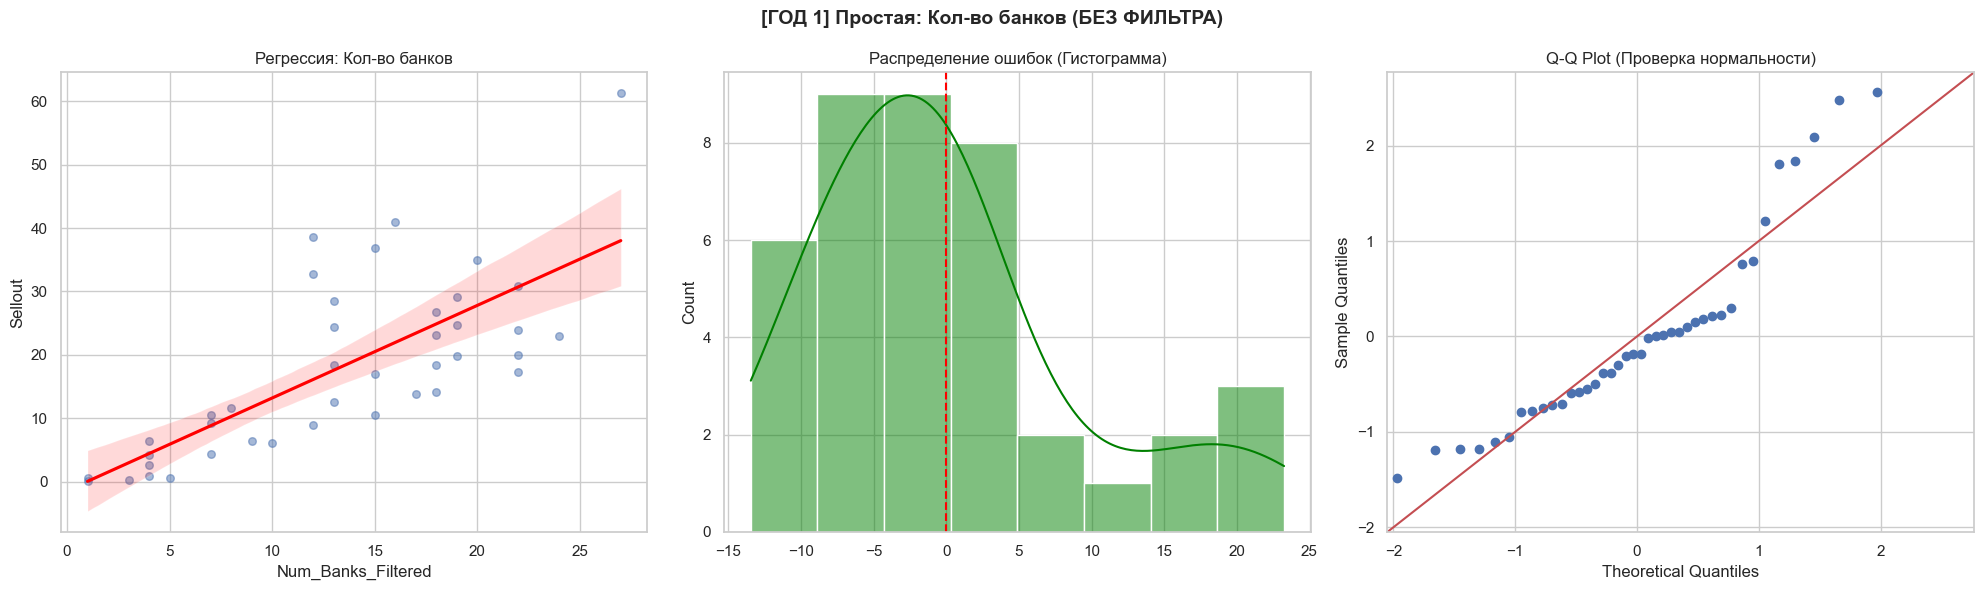


🚀 МОДЕЛЬ: [ГОД 2] Простая: Кол-во банков (БЕЗ ФИЛЬТРА)
📌 R-squared (Точность):      0.4947
📌 Adj. R-squared (Честный):  0.4737
📌 F-statistic p-value:       6.1160e-05
--------------------------------------------------------------------------------
               Коэффициент  Std. Error  P-значение Значимость
Константа          1.67917     2.39106     0.48927          ❌
Кол-во банков      0.70619     0.14567     0.00006        ⭐⭐⭐
--------------------------------------------------------------------------------


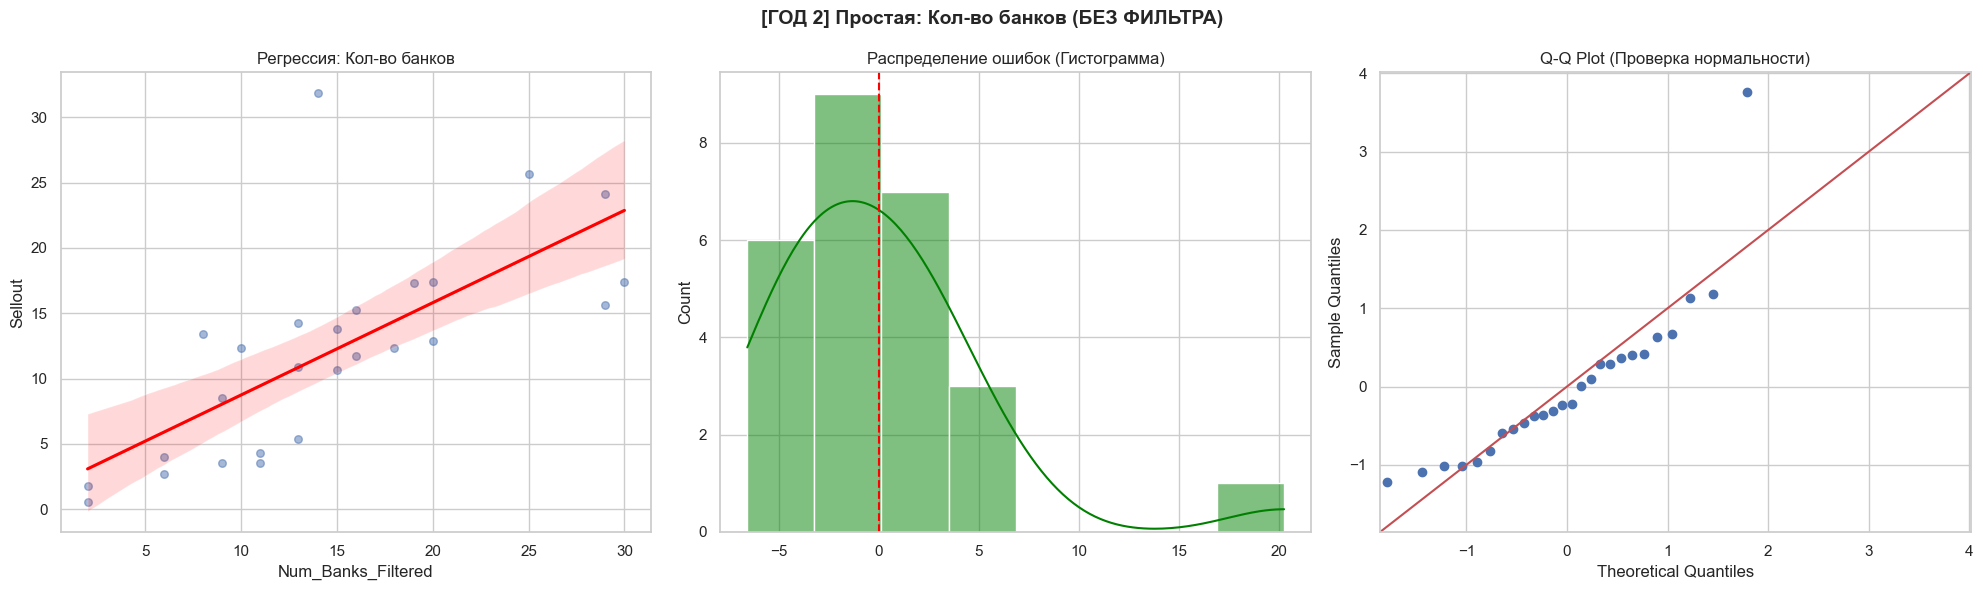

In [43]:
# --- ГОД 1 ---
advanced_analysis(df_all, ['Num_Banks_Filtered'], 'Sellout', "Простая: Кол-во банков (БЕЗ ФИЛЬТРА)", year_filter=1)

# --- ГОД 2 ---
advanced_analysis(df_all, ['Num_Banks_Filtered'], 'Sellout', "Простая: Кол-во банков (БЕЗ ФИЛЬТРА)", year_filter=2)


🚀 МОДЕЛЬ: [ГОД 1] Простая: Кол-во банков (ФИЛЬТР 40-100%)
📌 R-squared (Точность):      0.5534
📌 Adj. R-squared (Честный):  0.5417
📌 F-statistic p-value:       3.7760e-08
--------------------------------------------------------------------------------
               Коэффициент  Std. Error  P-значение Значимость
Константа         -1.49288     3.17694     0.64110          ❌
Кол-во банков      1.51506     0.22077     0.00000        ⭐⭐⭐
--------------------------------------------------------------------------------


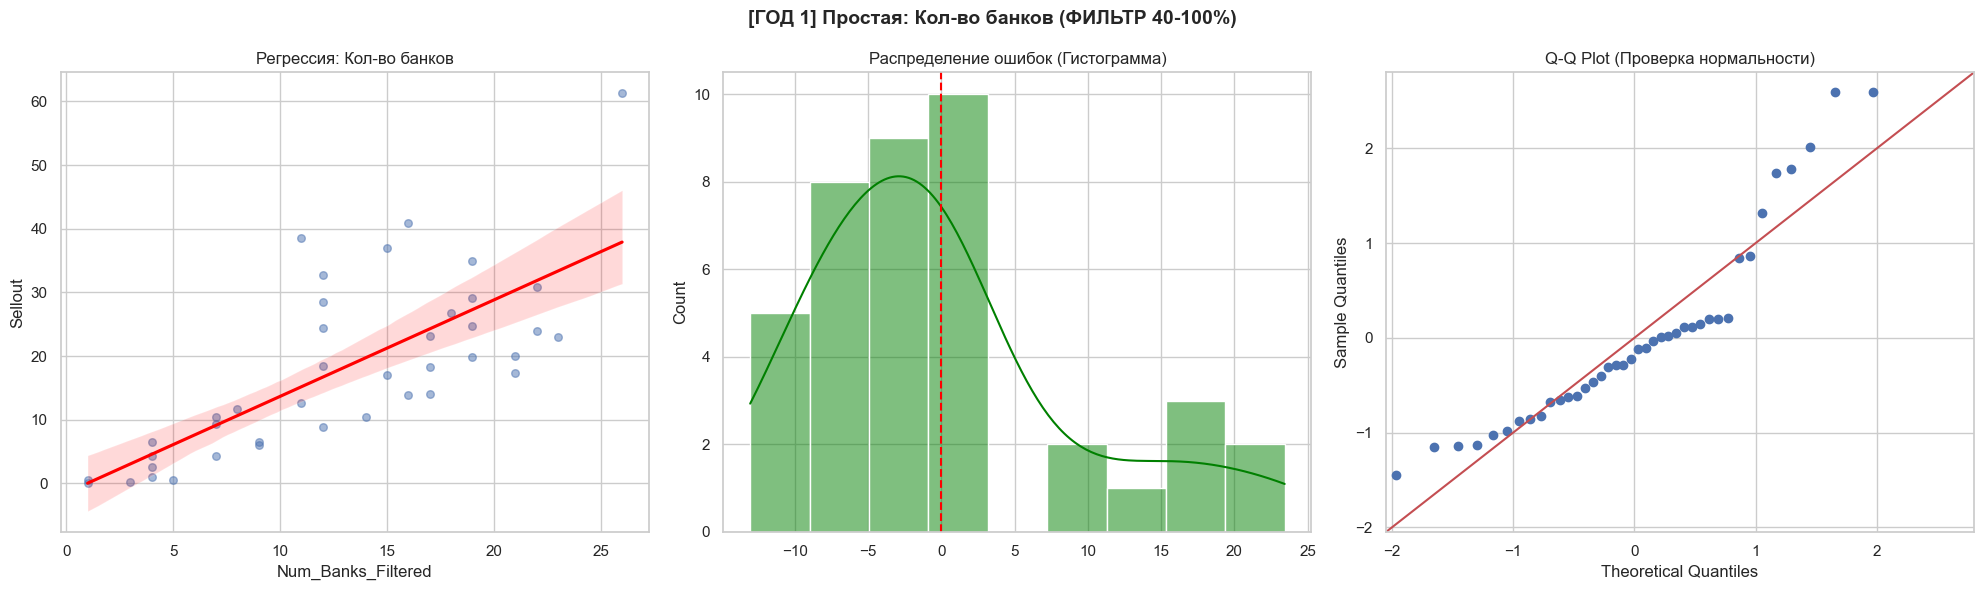


🚀 МОДЕЛЬ: [ГОД 2] Простая: Кол-во банков (ФИЛЬТР 40-100%)
📌 R-squared (Точность):      0.5293
📌 Adj. R-squared (Честный):  0.5096
📌 F-statistic p-value:       2.5412e-05
--------------------------------------------------------------------------------
               Коэффициент  Std. Error  P-значение Значимость
Константа          1.37964     2.29883     0.55403          ❌
Кол-во банков      0.76297     0.14688     0.00003        ⭐⭐⭐
--------------------------------------------------------------------------------


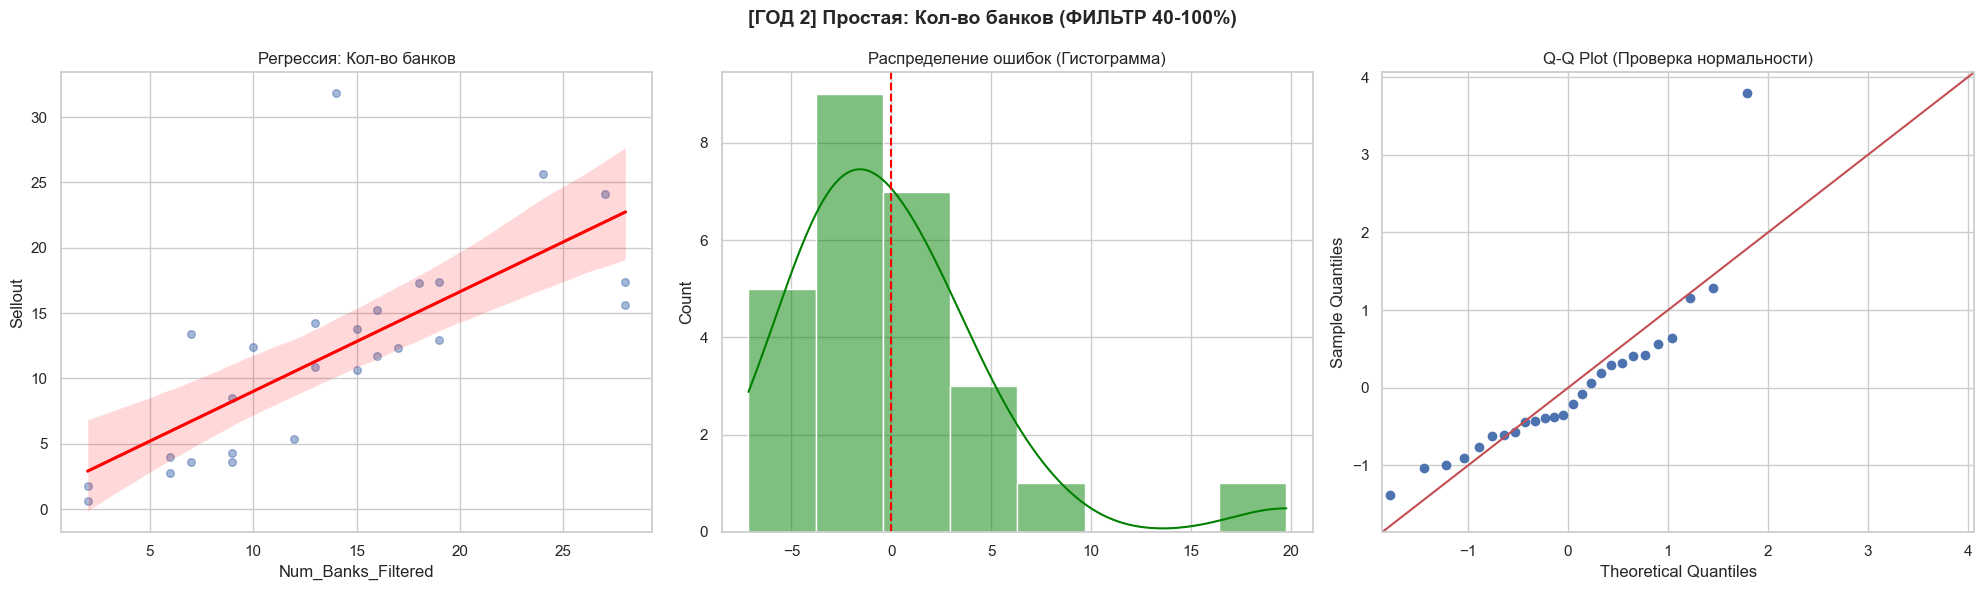

In [44]:
# --- ГОД 1 ---
advanced_analysis(df_filtered, ['Num_Banks_Filtered'], 'Sellout', "Простая: Кол-во банков (ФИЛЬТР 40-100%)", year_filter=1)

# --- ГОД 2 ---
advanced_analysis(df_filtered, ['Num_Banks_Filtered'], 'Sellout', "Простая: Кол-во банков (ФИЛЬТР 40-100%)", year_filter=2)


🚀 МОДЕЛЬ: [ГОД 1] Простая: Взвешенный индекс банков
📌 R-squared (Точность):      0.5615
📌 Adj. R-squared (Честный):  0.5499
📌 F-statistic p-value:       2.6563e-08
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    -3.50463     3.38869     0.30757          ❌
Вес банков (Log площади)      0.16551     0.02373     0.00000        ⭐⭐⭐
--------------------------------------------------------------------------------


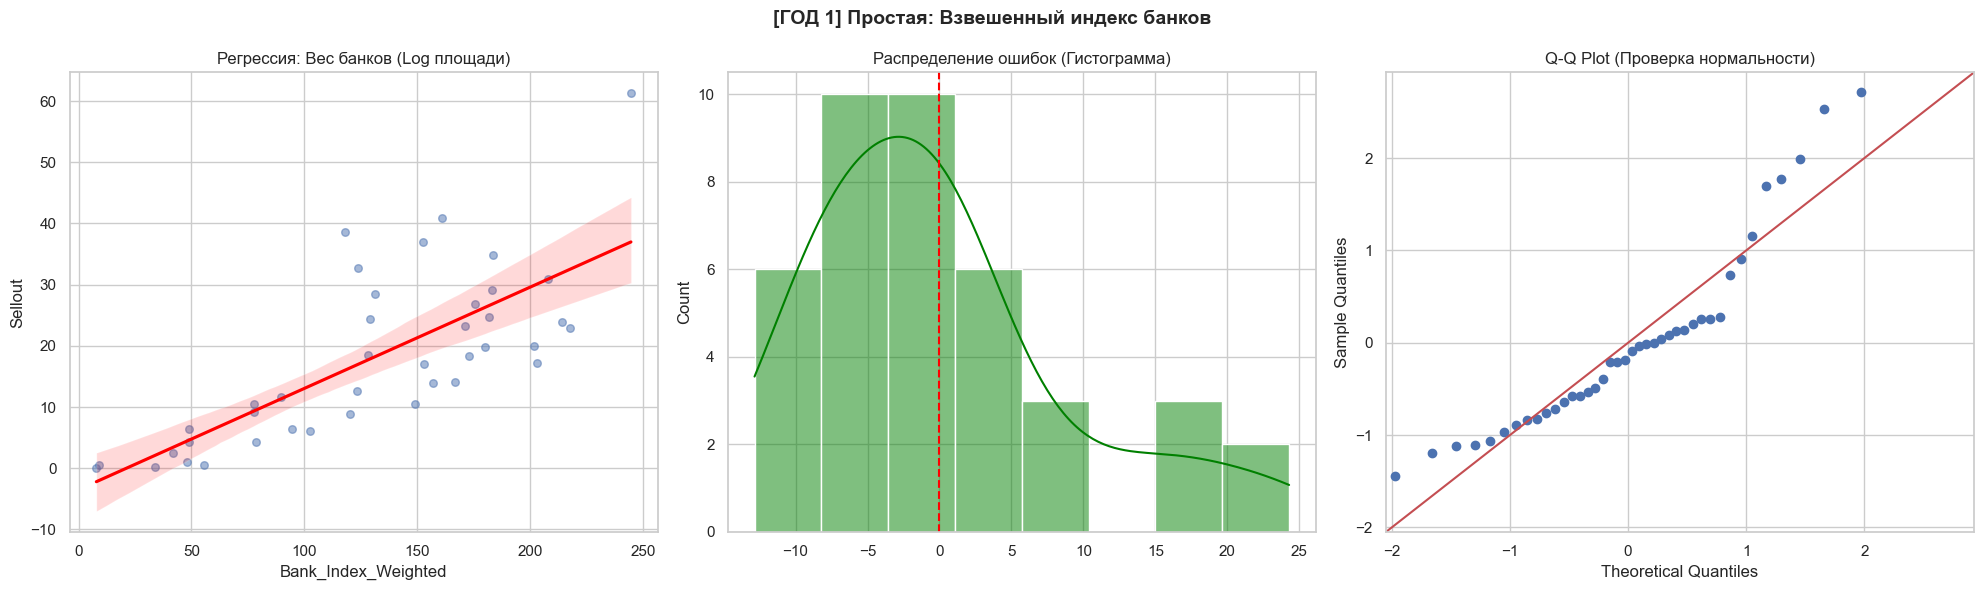


🚀 МОДЕЛЬ: [ГОД 2] Простая: Взвешенный индекс банков
📌 R-squared (Точность):      0.5259
📌 Adj. R-squared (Честный):  0.5062
📌 F-statistic p-value:       2.7724e-05
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    -0.12426     2.57488     0.96191          ❌
Вес банков (Log площади)      0.08691     0.01684     0.00003        ⭐⭐⭐
--------------------------------------------------------------------------------


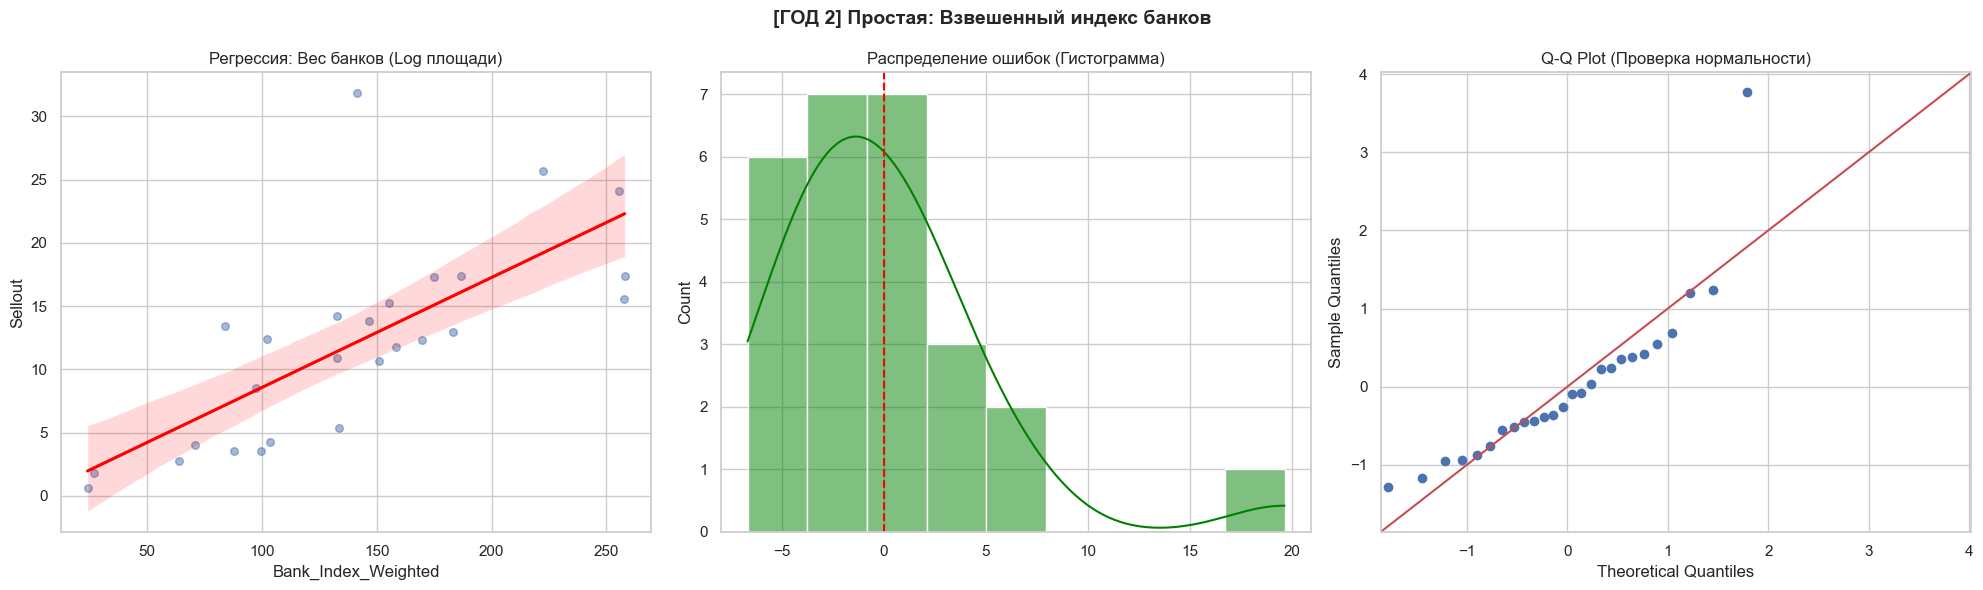

In [45]:
# --- ГОД 1 ---
advanced_analysis(df_all, ['Bank_Index_Weighted'], 'Sellout', "Простая: Взвешенный индекс банков", year_filter=1)

# --- ГОД 2 ---
advanced_analysis(df_all, ['Bank_Index_Weighted'], 'Sellout', "Простая: Взвешенный индекс банков", year_filter=2)


🚀 МОДЕЛЬ: [ГОД 1] Мульти: Все фичи (ВСЕ БАНКИ)
📌 R-squared (Точность):      0.6479
📌 Adj. R-squared (Честный):  0.6077
📌 F-statistic p-value:       1.4359e-07
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    51.96212    26.59897     0.05879          ❌
Кол-во банков                 1.67576     0.28422     0.00000        ⭐⭐⭐
Масштаб проекта (Log м²)     -5.48011     2.12720     0.01437          ⭐
Ср. Ключевая ставка          -0.35050     0.60929     0.56879          ❌
Доля Ипотеки                 14.03703     9.46189     0.14688          ❌
--------------------------------------------------------------------------------


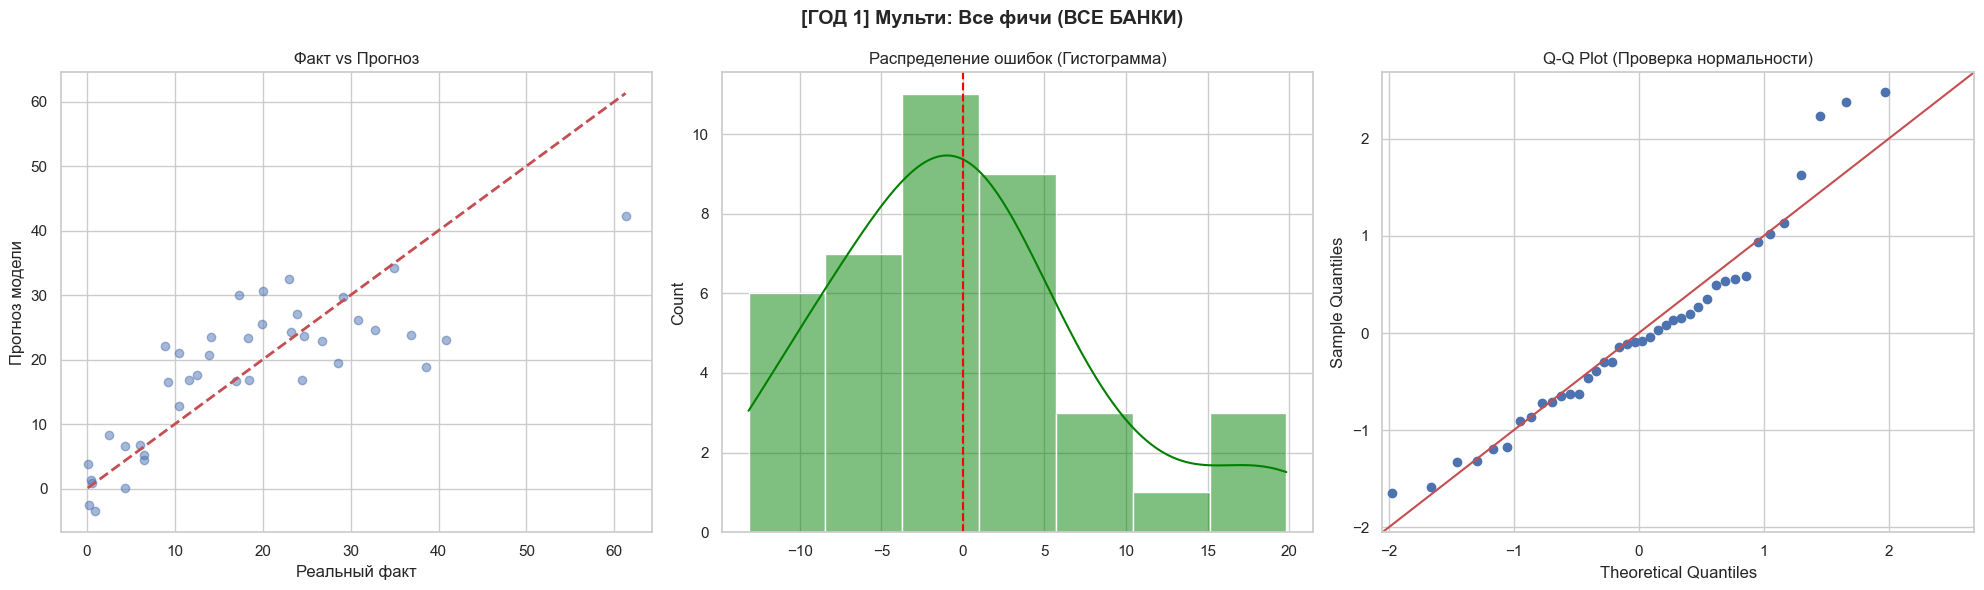


🚀 МОДЕЛЬ: [ГОД 2] Мульти: Все фичи (ВСЕ БАНКИ)
📌 R-squared (Точность):      0.6477
📌 Adj. R-squared (Честный):  0.5806
📌 F-statistic p-value:       1.3646e-04
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    55.15269    27.29326     0.05624          ❌
Кол-во банков                 1.14311     0.24907     0.00016        ⭐⭐⭐
Масштаб проекта (Log м²)     -5.55103     2.08346     0.01451          ⭐
Ср. Ключевая ставка           0.13946     0.56031     0.80586          ❌
Доля Ипотеки                  4.88816     8.07926     0.55164          ❌
--------------------------------------------------------------------------------


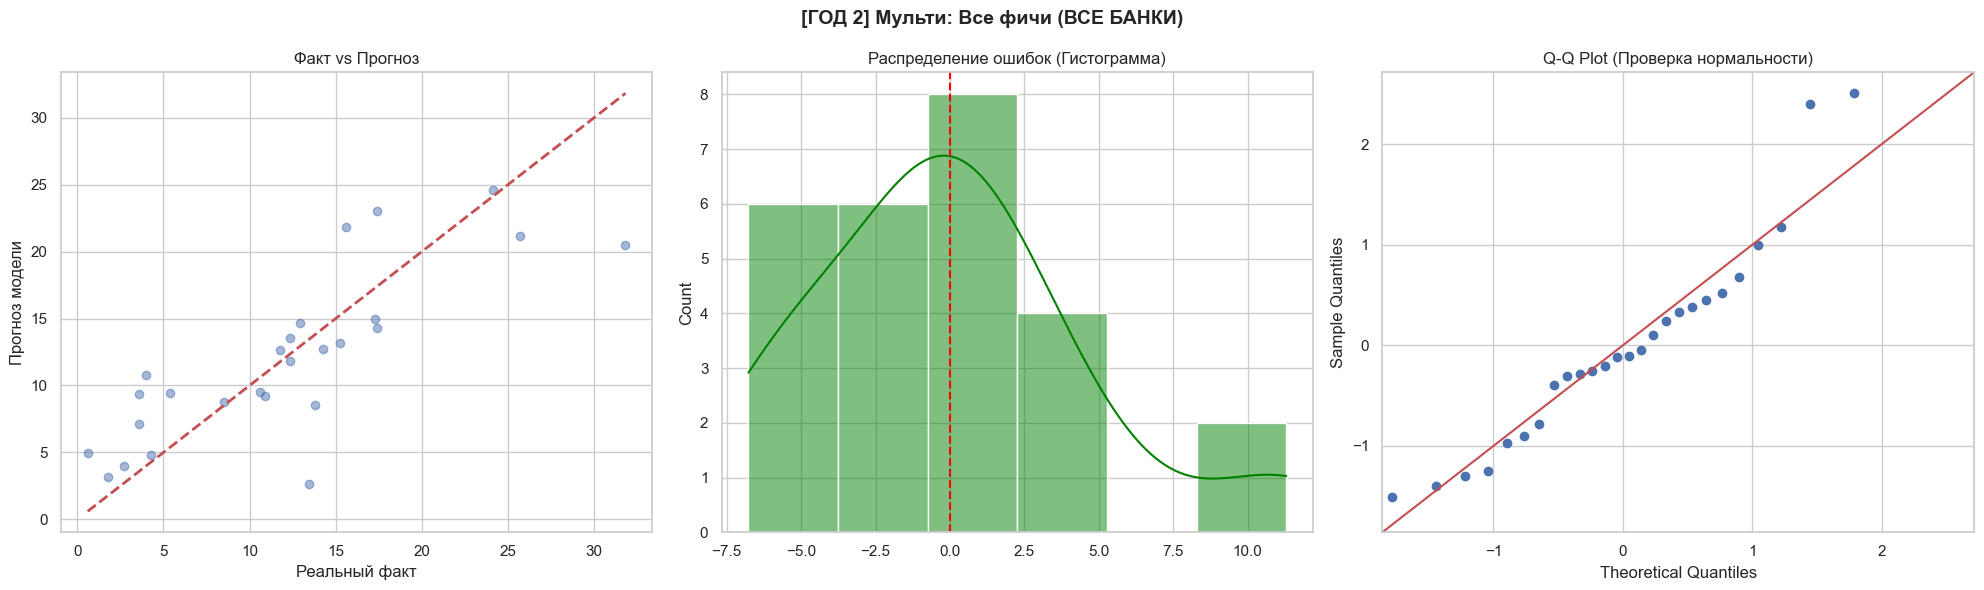

In [46]:
# Список переменных (кроме количества сделок, как ты просил)
features_full = ['Num_Banks_Filtered', 'Log_Area', 'KR_Mean', 'Mortgage_Share']

# --- ГОД 1 ---
advanced_analysis(df_all, features_full, 'Sellout', "Мульти: Все фичи (ВСЕ БАНКИ)", year_filter=1)

# --- ГОД 2 ---
advanced_analysis(df_all, features_full, 'Sellout', "Мульти: Все фичи (ВСЕ БАНКИ)", year_filter=2)


🚀 МОДЕЛЬ: [ГОД 1] Мульти: Все фичи (ФИЛЬТР БАНКОВ 40%)
📌 R-squared (Точность):      0.6530
📌 Adj. R-squared (Честный):  0.6134
📌 F-statistic p-value:       1.1198e-07
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    52.61250    26.41451     0.05424          ❌
Кол-во банков                 1.73333     0.28973     0.00000        ⭐⭐⭐
Масштаб проекта (Log м²)     -5.48003     2.10661     0.01352          ⭐
Ср. Ключевая ставка          -0.39113     0.60461     0.52191          ❌
Доля Ипотеки                 13.77307     9.40017     0.15179          ❌
--------------------------------------------------------------------------------


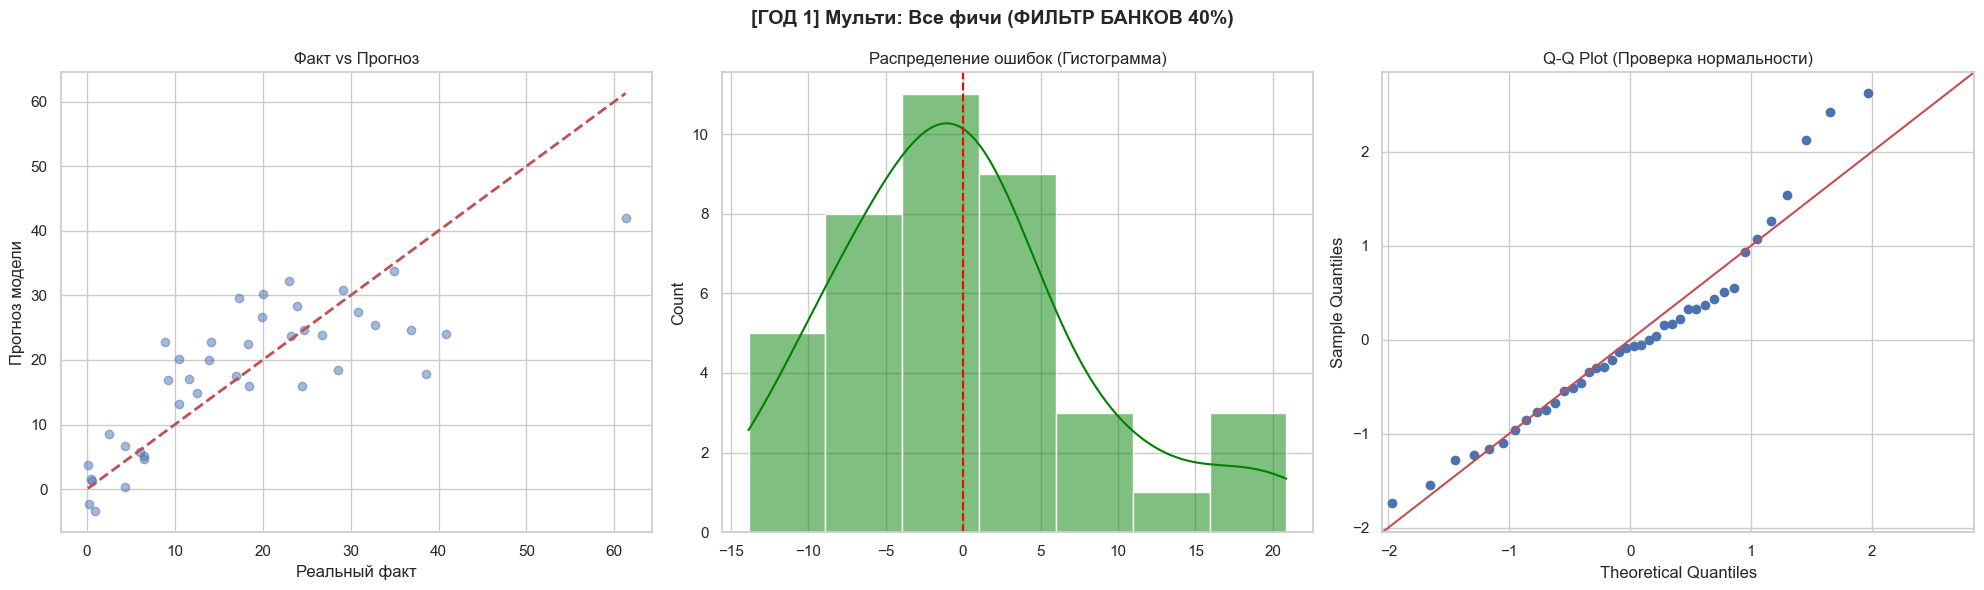


🚀 МОДЕЛЬ: [ГОД 2] Мульти: Все фичи (ФИЛЬТР БАНКОВ 40%)
📌 R-squared (Точность):      0.6757
📌 Adj. R-squared (Честный):  0.6139
📌 F-statistic p-value:       5.9365e-05
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    56.71273    25.85204     0.03965          ⭐
Кол-во банков                 1.23659     0.24885     0.00006        ⭐⭐⭐
Масштаб проекта (Log м²)     -5.50457     1.94396     0.00999         ⭐⭐
Ср. Ключевая ставка           0.13742     0.53683     0.80045          ❌
Доля Ипотеки                  1.46401     8.02347     0.85697          ❌
--------------------------------------------------------------------------------


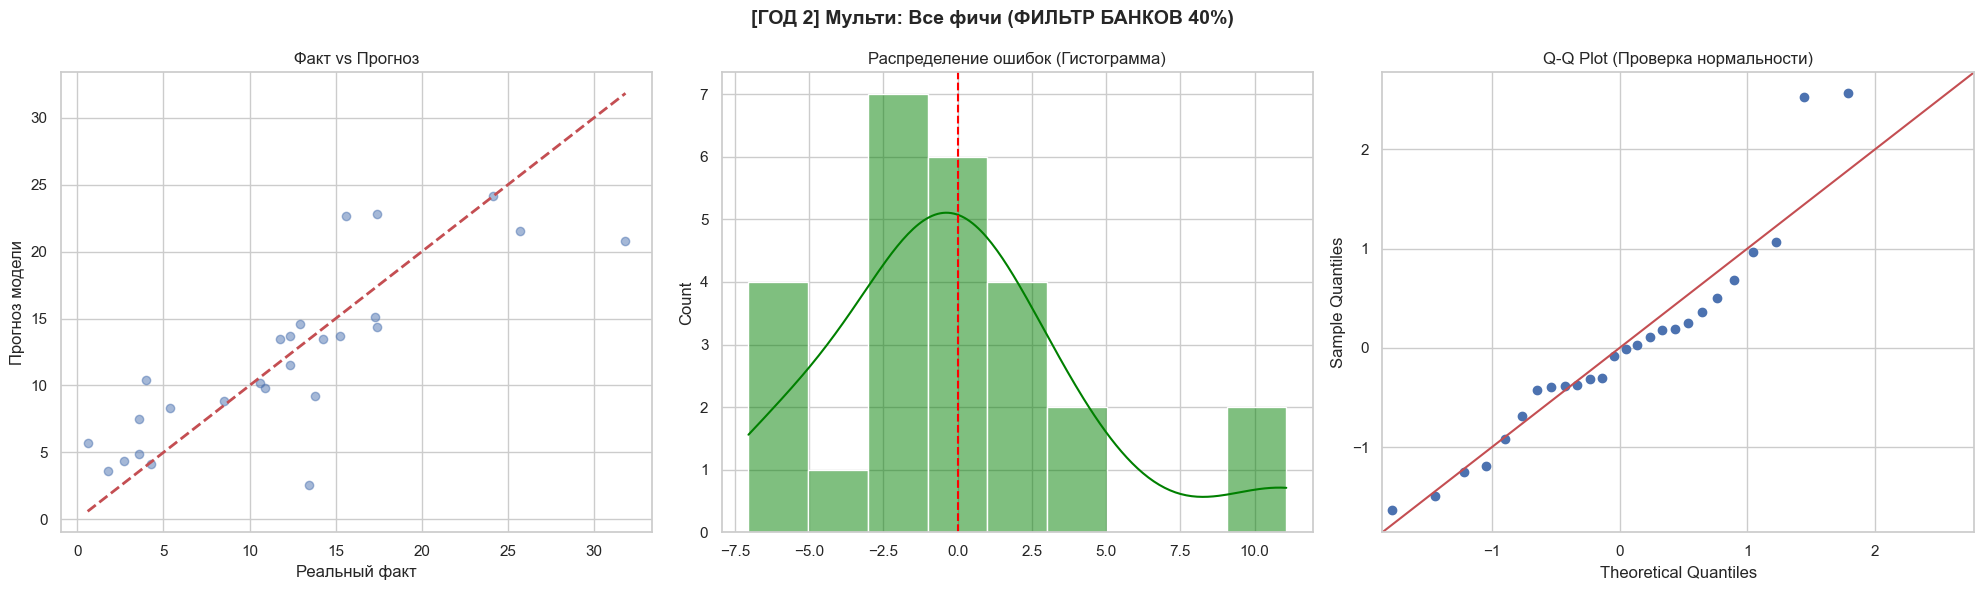

In [47]:
features_full = ['Num_Banks_Filtered', 'Log_Area', 'KR_Mean', 'Mortgage_Share']

# --- ГОД 1 ---
advanced_analysis(df_filtered, features_full, 'Sellout', "Мульти: Все фичи (ФИЛЬТР БАНКОВ 40%)", year_filter=1)

# --- ГОД 2 ---
advanced_analysis(df_filtered, features_full, 'Sellout', "Мульти: Все фичи (ФИЛЬТР БАНКОВ 40%)", year_filter=2)


🚀 МОДЕЛЬ: [ГОД 1] Мульти: ВЕС БАНКОВ вместо количества
📌 R-squared (Точность):      0.6457
📌 Adj. R-squared (Честный):  0.6162
📌 F-statistic p-value:       3.0782e-08
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    67.28697    24.40416     0.00910         ⭐⭐
Вес банков (Log площади)      0.20559     0.02938     0.00000        ⭐⭐⭐
Масштаб проекта (Log м²)     -5.80192     2.10133     0.00901         ⭐⭐
Ср. Ключевая ставка          -0.82027     0.54879     0.14371          ❌
--------------------------------------------------------------------------------


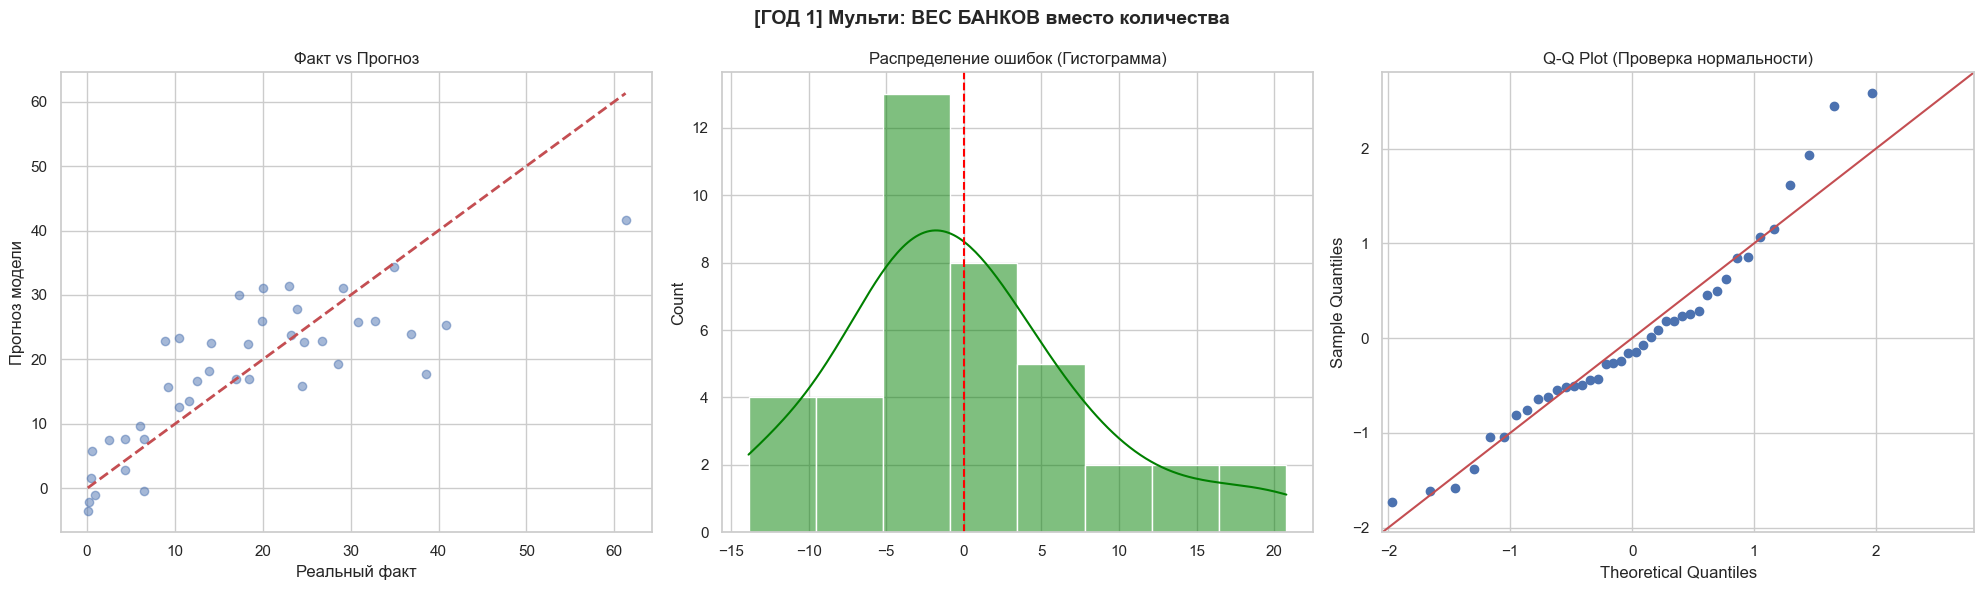


🚀 МОДЕЛЬ: [ГОД 2] Мульти: ВЕС БАНКОВ вместо количества
📌 R-squared (Точность):      0.6958
📌 Adj. R-squared (Честный):  0.6543
📌 F-statistic p-value:       6.7794e-06
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    64.70369    22.44779     0.00865         ⭐⭐
Вес банков (Log площади)      0.15251     0.02396     0.00000        ⭐⭐⭐
Масштаб проекта (Log м²)     -6.31685     1.84562     0.00244         ⭐⭐
Ср. Ключевая ставка           0.05990     0.50608     0.90685          ❌
--------------------------------------------------------------------------------


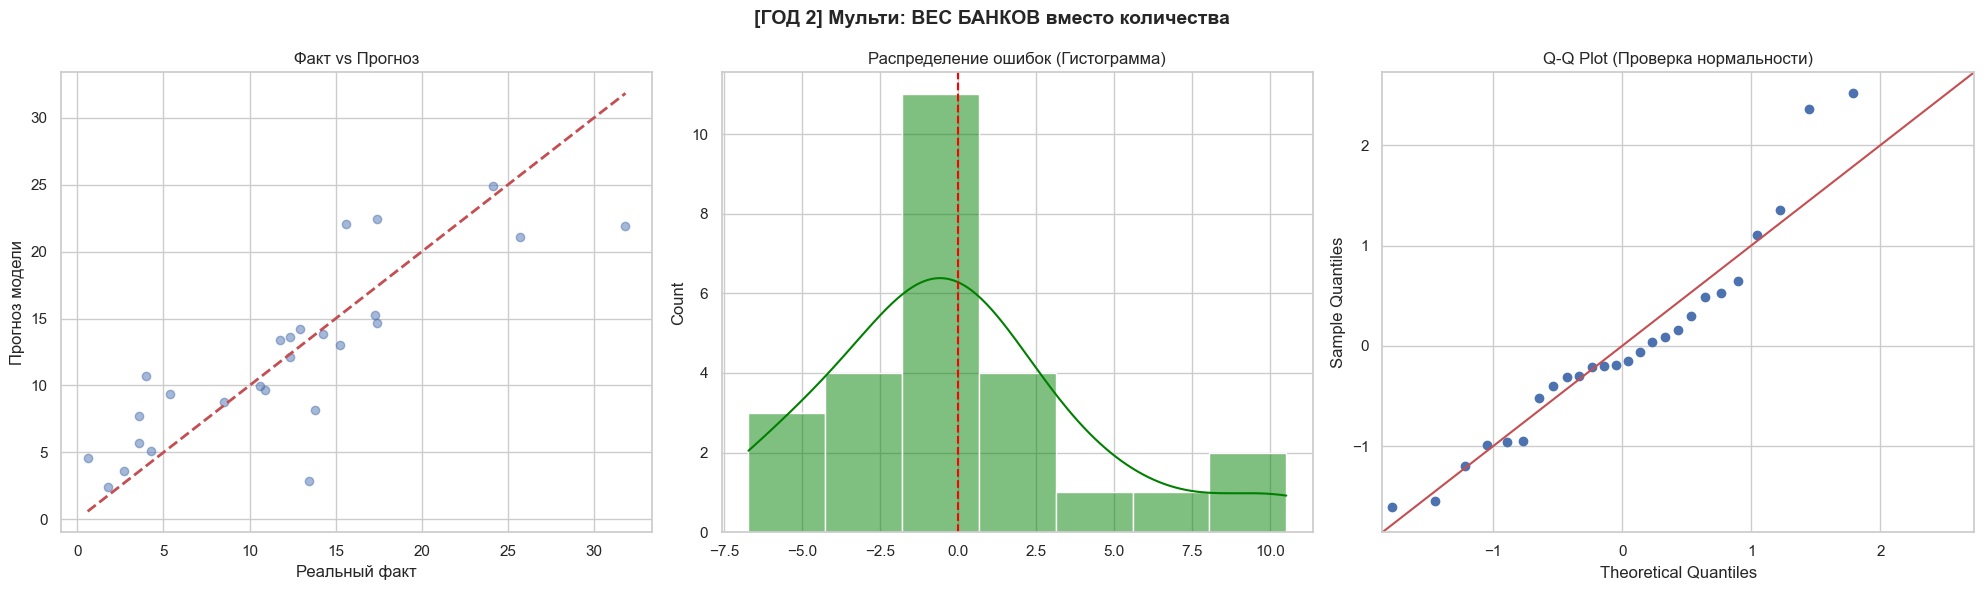

In [48]:
# Заменили кол-во банков на их Вес
features_weighted = ['Bank_Index_Weighted', 'Log_Area', 'KR_Mean']

# --- ГОД 1 ---
advanced_analysis(df_all, features_weighted, 'Sellout', "Мульти: ВЕС БАНКОВ вместо количества", year_filter=1)

# --- ГОД 2 ---
advanced_analysis(df_all, features_weighted, 'Sellout', "Мульти: ВЕС БАНКОВ вместо количества", year_filter=2)

In [ ]:
df_mizir, _, _ = process_real_estate_data(
    proj, sdel_final, 
    bank_percentile_range=(40, 80), 
    bank_metric_for_filtering='sq_meters'
)

print(f"\n✅ ГОТОВО. Строк в df_all: {len(df_mizir)}, Строк в df_filtered: {len(df_mizir)}")

NameError: name 'deal_final' is not defined


🚀 МОДЕЛЬ: [ГОД 1] ВЛИЯНИЯ ВЕСА БАНКОВ БЕЗ ТОП 20%
📌 R-squared (Точность):      0.5091
📌 Adj. R-squared (Честный):  0.4588
📌 F-statistic p-value:       1.0299e-05
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    11.35888    25.79249     0.66208          ❌
Вес банков (Log площади)      0.24644     0.06950     0.00104         ⭐⭐
Масштаб проекта (Log м²)     -1.87312     2.23116     0.40629          ❌
Ср. Ключевая ставка           0.00771     0.46434     0.98684          ❌
Доля Ипотеки                 26.71828     8.73207     0.00399         ⭐⭐
--------------------------------------------------------------------------------


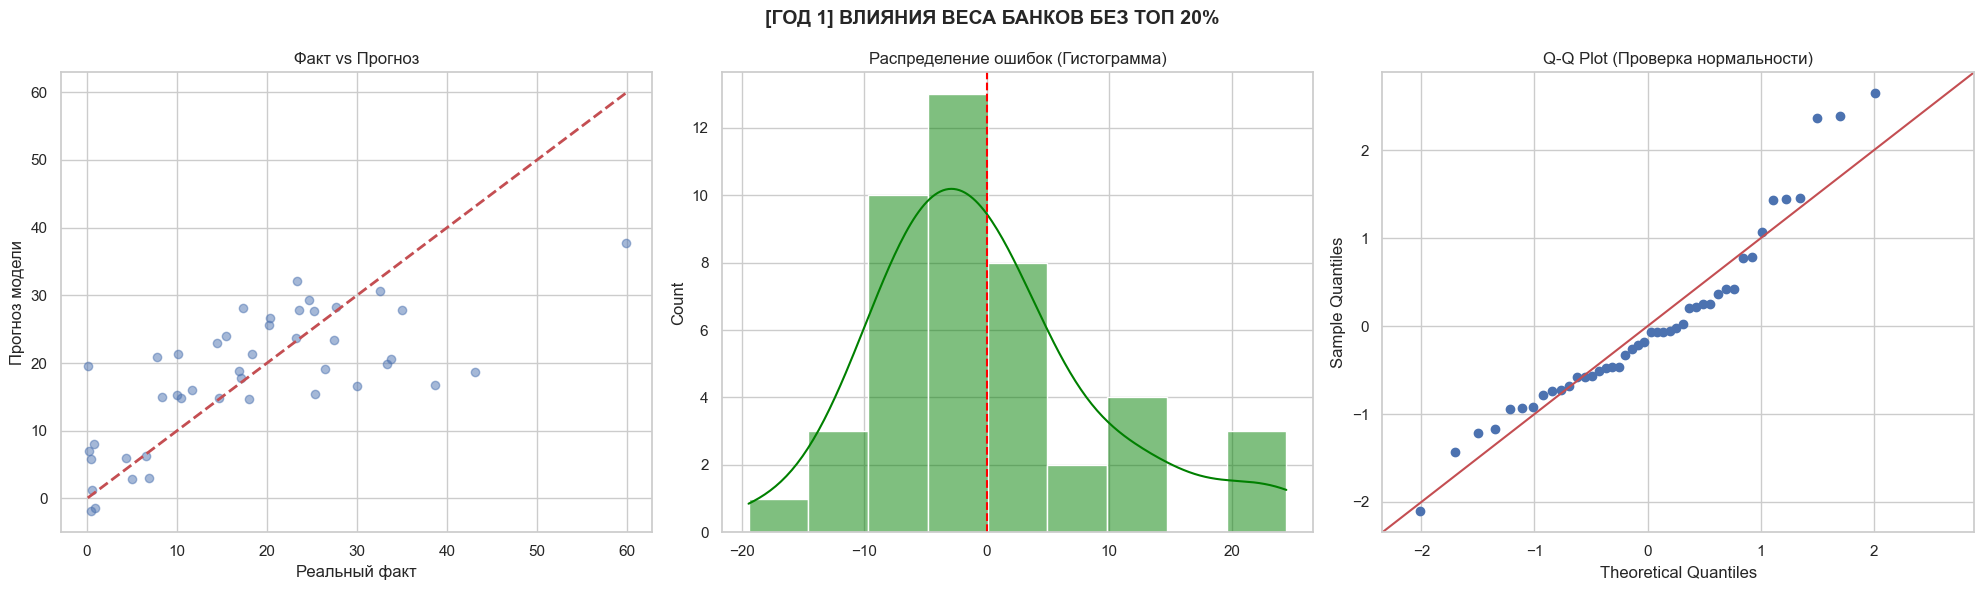


🚀 МОДЕЛЬ: [ГОД 2] ВЛИЯНИЯ ВЕСА БАНКОВ БЕЗ ТОП 20%
📌 R-squared (Точность):      0.4900
📌 Adj. R-squared (Честный):  0.4013
📌 F-statistic p-value:       2.8784e-03
--------------------------------------------------------------------------------
                          Коэффициент  Std. Error  P-значение Значимость
Константа                    34.27427    30.19865     0.26808          ❌
Вес банков (Log площади)      0.16388     0.04676     0.00191         ⭐⭐
Масштаб проекта (Log м²)     -2.64101     1.96212     0.19142          ❌
Ср. Ключевая ставка          -0.19505     0.75928     0.79955          ❌
Доля Ипотеки                  8.60679     9.64531     0.38146          ❌
--------------------------------------------------------------------------------


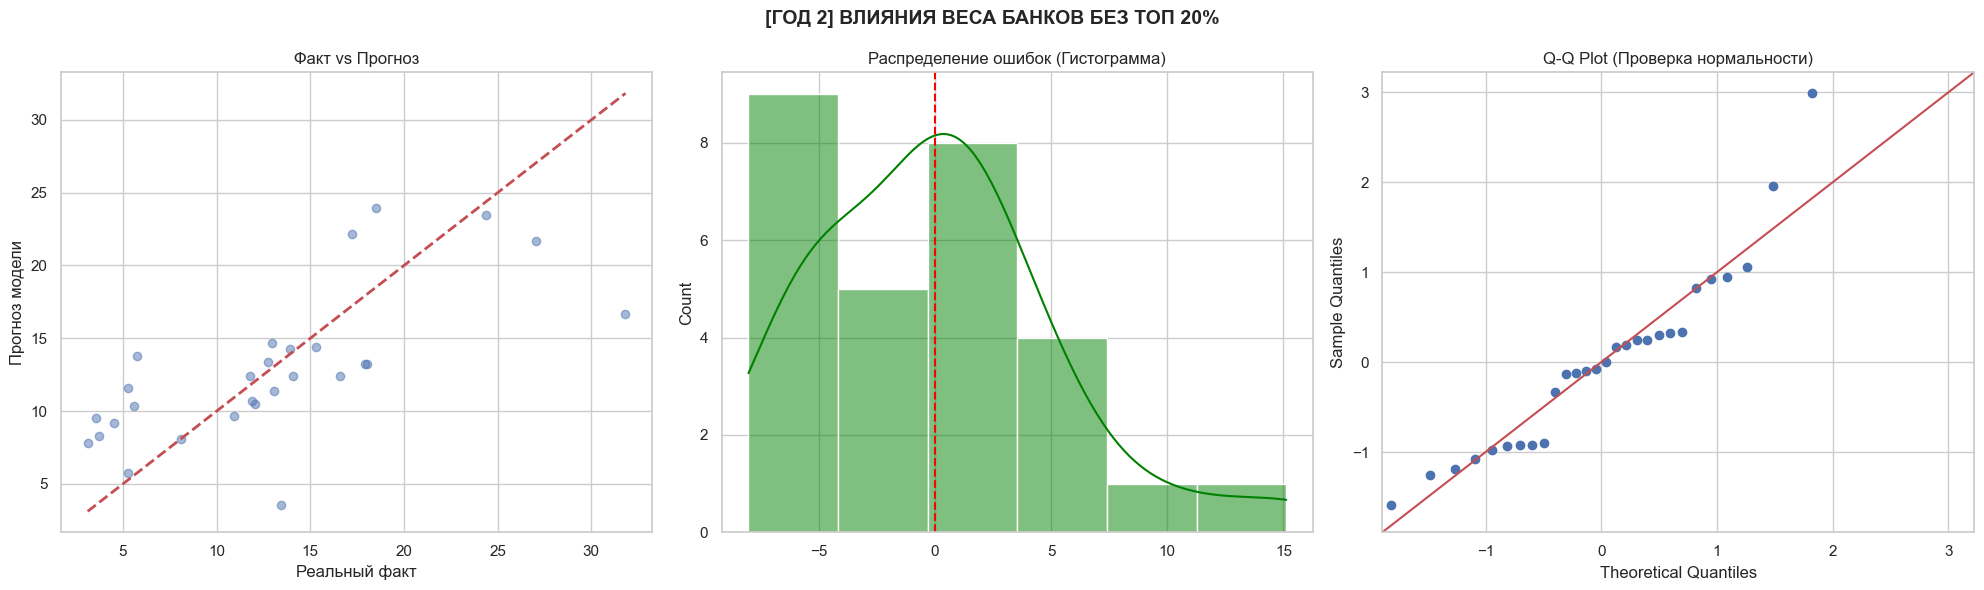

In [ ]:
# Заменили кол-во банков на их Вес
features_weighted = ['Bank_Index_Weighted', 'Log_Area', 'KR_Mean',  'Mortgage_Share']

# --- ГОД 1 ---
advanced_analysis(df_mizir, features_weighted, 'Sellout', "ВЛИЯНИЯ ВЕСА БАНКОВ БЕЗ ТОП 20%", year_filter=1)

# --- ГОД 2 ---
advanced_analysis(df_mizir, features_weighted, 'Sellout', "ВЛИЯНИЯ ВЕСА БАНКОВ БЕЗ ТОП 20%", year_filter=2)

🚀 ЗАПУСК: Расчет метрики 'Средняя стадия строительства' (за 1-й год продаж)...
   ✅ Обработано проектов: 45
   Примеры средних стадий (Топ-3):
         Project  Construction_Stage_Mean
1-й Саларьевский                  0.33638
  1-й Ясеневский                  0.12413
       Foreville                  0.26471
срднее по всем проектам: 0.4523
минимум: 0.0000, максимум: 1.0000

📊 Итоговый датасет для моделирования: 44 строк.

🔬 МОДЕЛЬ: Влияние Стадии Строительства + Банки + Макро (1 Год)
📌 R-squared (Точность):      0.5715
📌 Adj. R-squared (Честный):  0.5393
📌 F-pvalue:                  1.7232e-07
--------------------------------------------------------------------------------
                       Коэффициент  Std. Error  P-value Значимость
Константа                  7.21634    11.37414  0.52940          ❌
Вес Банков (Log)           0.14573     0.02789  0.00001        ⭐⭐⭐
Стадия Стройки (0..1)     -6.06606     7.91079  0.44770          ❌
Ср. Ключевая ставка       -0.40919     0.50434  0

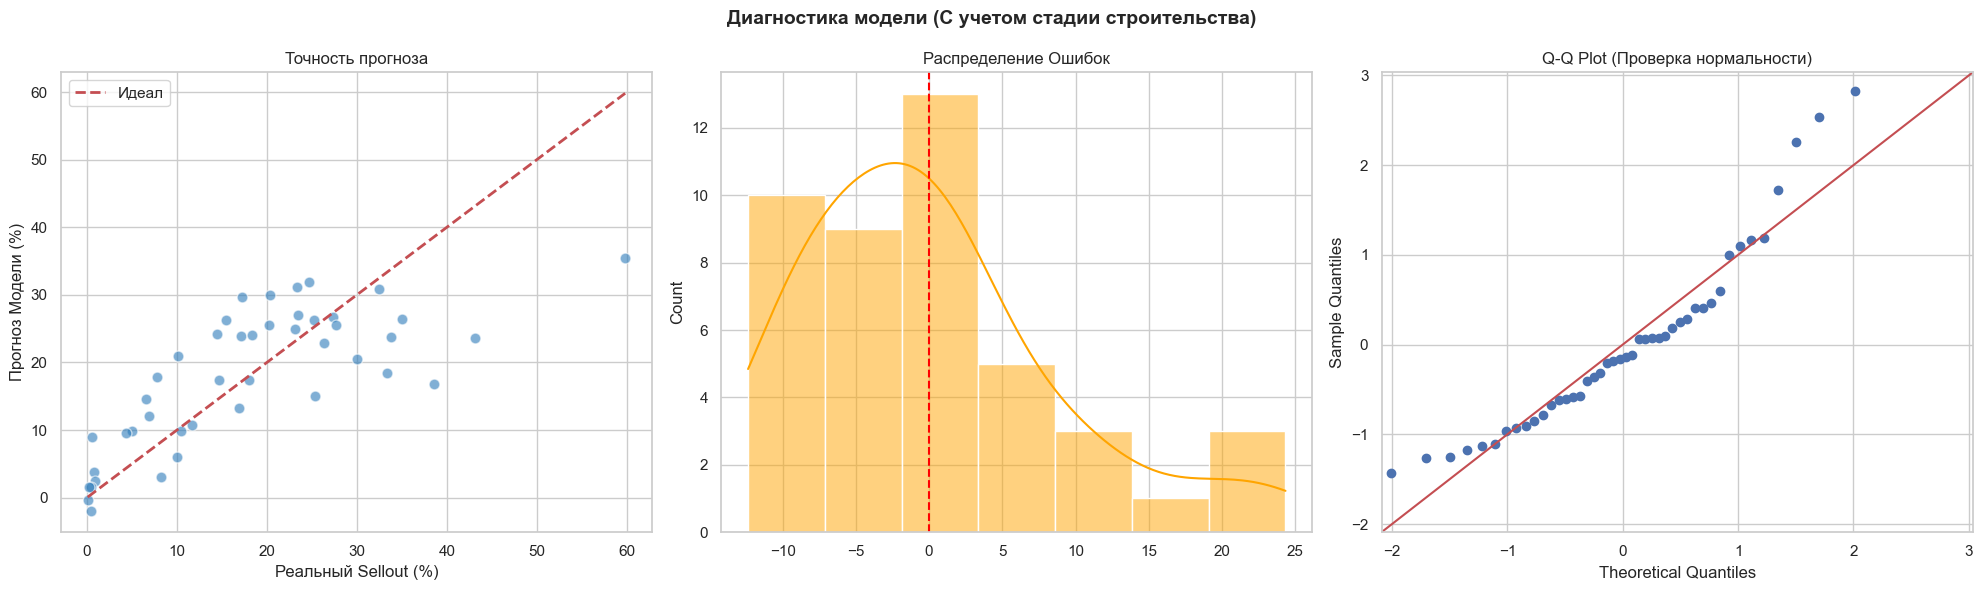


💡 АНАЛИТИЧЕСКИЙ ВЫВОД ПО СТАДИИ:
   ❌ Стадия строительства НЕ ЯВЛЯЕТСЯ значимым фактором (p-value > 0.1).
      Возможно, покупателям в этом сегменте не так важно, на каком этапе стройка,
      либо эффект 'котлована' (дешево) уравновешивает эффект 'готового' (надежно).


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# ==============================================================================
# ⚙️ НАСТРОЙКИ (КОНФИГУРАЦИЯ)
# ==============================================================================
PATH_DEALS_FILE = "Сделки_2025-11-25.xlsx"  # Путь к файлу сделок

# Словарь весов: 0.0 - самое начало, 1.0 - сдан
# Значения можно калибровать под ваши ощущения рынка
STAGE_WEIGHTS_MAP = {
    'Строительство не начато': 0.0,
    'Работы нулевого цикла': 0.1,
    'Начало монтажных работ': 0.25,
    'Монтажные и отделочные работы': 0.6,
    'Получение РВЭ, благоустройство территории': 0.9,
    'Введен в эксплуатацию': 1.0
}

# Список фичей для модели
# ВАЖНО: Bank_Index_Weighted и KR_Mean берутся из df_all, 
# а Construction_Stage_Mean мы сейчас посчитаем.
MODEL_FEATURES = [
    'Bank_Index_Weighted',      # Вес банков (из основной модели)
    'Construction_Stage_Mean',  # Средняя стадия стройки (Новая фича)
    'KR_Mean'                   # Макро (Ставка ЦБ)
]
TARGET_VARIABLE = 'Sellout'

# ==============================================================================
# 🛠 ЭТАП 1: ETL (РАСЧЕТ СТАДИИ СТРОИТЕЛЬСТВА ЗА 1 ГОД)
# ==============================================================================
print(f"🚀 ЗАПУСК: Расчет метрики 'Средняя стадия строительства' (за 1-й год продаж)...")

# 1. Проверка наличия df_all
if 'df_all' not in locals():
    raise ValueError("⚠️ ОШИБКА: Переменная df_all не найдена! Сначала запустите ячейку генерации датасета (process_real_estate_data).")

# 2. Загрузка сделок
deals_raw = pd.read_excel(PATH_DEALS_FILE)

# 3. Очистка дат (как в process_real_estate_data)
date_col = "Дата договора (месяц.год)"
deals_raw["dt_deal"] = pd.to_datetime(deals_raw[date_col], dayfirst=True, errors="coerce")

# Если есть битые даты, пробуем восстановить через "01."
mask_na = deals_raw["dt_deal"].isna()
if mask_na.any():
    deals_raw.loc[mask_na, "dt_deal"] = pd.to_datetime(
        "01." + deals_raw.loc[mask_na, date_col].astype(str), 
        dayfirst=True, errors="coerce"
    )
deals_raw = deals_raw.dropna(subset=["dt_deal", "Название ЖК"])

# 4. Мэппинг стадий
# Создаем числовую колонку. Если стадии нет в словаре -> fillna(0)
deals_raw['Stage_Score'] = deals_raw['Текущая стадия строительства'].map(STAGE_WEIGHTS_MAP).fillna(0)

# 5. Определение окна "1 год продаж" для каждого проекта
# Находим самую раннюю дату сделки по каждому проекту
proj_start_dates = deals_raw.groupby("Название ЖК")["dt_deal"].min().reset_index().rename(columns={"dt_deal": "Project_Start_Date"})
deals_raw = deals_raw.merge(proj_start_dates, on="Название ЖК", how="left")

# Фильтруем: оставляем только сделки, совершенные в первые 365 дней
deals_y1 = deals_raw[
    (deals_raw["dt_deal"] >= deals_raw["Project_Start_Date"]) & 
    (deals_raw["dt_deal"] <= deals_raw["Project_Start_Date"] + timedelta(days=365))
].copy()

# 6. Агрегация: Считаем среднее по Stage_Score
# Так как мы считаем среднее по строкам сделок, это автоматически "взвешивает" стадию по объему продаж (в штуках)
stage_stats = deals_y1.groupby("Название ЖК")["Stage_Score"].mean().reset_index()
stage_stats = stage_stats.rename(columns={"Stage_Score": "Construction_Stage_Mean", "Название ЖК": "Project"})

print(f"   ✅ Обработано проектов: {len(stage_stats)}")
print(f"   Примеры средних стадий (Топ-3):")
print(stage_stats.head(3).to_string(index=False))
print(f"срднее по всем проектам: {stage_stats['Construction_Stage_Mean'].mean():.4f}")
print(f"минимум: {stage_stats['Construction_Stage_Mean'].min():.4f}, максимум: {stage_stats['Construction_Stage_Mean'].max():.4f}")

# ==============================================================================
# 🔄 ЭТАП 2: СБОРКА ДАТАСЕТА ДЛЯ МОДЕЛИ
# ==============================================================================
# Берем данные за 1-й год из основного датасета
df_modeling = df_all[df_all["Year_Num"] == 1].copy()

# Мержим нашу новую фичу
# Используем inner merge, чтобы остались только те проекты, где есть и фичи, и стадия
df_modeling = df_modeling.merge(stage_stats, on="Project", how="inner")

print(f"\n📊 Итоговый датасет для моделирования: {len(df_modeling)} строк.")

# ==============================================================================
# 🔬 ЭТАП 3: МОДЕЛИРОВАНИЕ И ВИЗУАЛИЗАЦИЯ
# ==============================================================================
def run_stage_model(df, features, target):
    # Очистка пропусков
    data = df.dropna(subset=features + [target])
    
    # Обучение OLS
    X = sm.add_constant(data[features])
    y = data[target]
    model = sm.OLS(y, X).fit()
    
    # --- ТЕКСТОВОЙ ОТЧЕТ ---
    print(f"\n{'='*80}")
    print(f"🔬 МОДЕЛЬ: Влияние Стадии Строительства + Банки + Макро (1 Год)")
    print(f"{'='*80}")
    print(f"📌 R-squared (Точность):      {model.rsquared:.4f}")
    print(f"📌 Adj. R-squared (Честный):  {model.rsquared_adj:.4f}")
    print(f"📌 F-pvalue:                  {model.f_pvalue:.4e}")
    print("-" * 80)
    
    # Красивая таблица коэффициентов
    coef_df = pd.DataFrame({
        "Коэффициент": model.params,
        "Std. Error": model.bse,
        "P-value": model.pvalues,
        "Значимость": model.pvalues.apply(lambda p: "⭐⭐⭐" if p<0.01 else ("⭐⭐" if p<0.05 else ("⭐" if p<0.1 else "❌")))
    })
    
    # Переименование для читаемости
    name_map = {
        "const": "Константа",
        "Bank_Index_Weighted": "Вес Банков (Log)",
        "Construction_Stage_Mean": "Стадия Стройки (0..1)",
        "KR_Mean": "Ср. Ключевая ставка"
    }
    coef_df.index = coef_df.index.map(lambda x: name_map.get(x, x))
    print(coef_df)

    print("-" * 80)
    
    # --- ГРАФИКИ (3 Штуки как в остальных моделях) ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle("Диагностика модели (С учетом стадии строительства)", fontsize=14, weight='bold')
    
    # График 1: Факт vs Прогноз
    preds = model.predict(X)
    axes[0].scatter(y, preds, alpha=0.6, edgecolors='white', s=60, color='#2b7bba')
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Идеал')
    axes[0].set_xlabel("Реальный Sellout (%)")
    axes[0].set_ylabel("Прогноз Модели (%)")
    axes[0].set_title(f"Точность прогноза")
    axes[0].legend()
    
    # График 2: Гистограмма остатков
    residuals = model.resid
    sns.histplot(residuals, kde=True, ax=axes[1], color='orange')
    axes[1].axvline(0, color='red', linestyle='--')
    axes[1].set_title("Распределение Ошибок")
    
    # График 3: Q-Q Plot
    sm.qqplot(residuals, line='45', fit=True, ax=axes[2])
    axes[2].set_title("Q-Q Plot (Проверка нормальности)")
    
    plt.tight_layout()
    plt.show()
    
    # --- АВТОМАТИЧЕСКИЙ ВЫВОД ---
    st_coef = model.params.get('Construction_Stage_Mean', 0)
    st_pval = model.pvalues.get('Construction_Stage_Mean', 1)
    
    print("\n💡 АНАЛИТИЧЕСКИЙ ВЫВОД ПО СТАДИИ:")
    if st_pval > 0.1:
        print("   ❌ Стадия строительства НЕ ЯВЛЯЕТСЯ значимым фактором (p-value > 0.1).")
        print("      Возможно, покупателям в этом сегменте не так важно, на каком этапе стройка,")
        print("      либо эффект 'котлована' (дешево) уравновешивает эффект 'готового' (надежно).")
    else:
        direction = "ПОЛОЖИТЕЛЬНОЕ" if st_coef > 0 else "ОТРИЦАТЕЛЬНОЕ"
        effect = "Лучше продается ГОТОВОЕ жилье." if st_coef > 0 else "Лучше продается КОТЛОВАН (инвест-спрос)."
        print(f"   ✅ Стадия строительства оказывает значимое {direction} влияние.")
        print(f"      Интерпретация: {effect}")

# Запуск функции
run_stage_model(df_modeling, MODEL_FEATURES, TARGET_VARIABLE)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ==============================================================================
# 1. СЛОВАРЬ РЕЙТИНГОВ (ERZ)
# ==============================================================================
erz_rating_dict = {
    'А101': 5, 
    'Абсолют Недвижимость': 4.5, 
    'Горакс': -1, 
    'Самолет': 4, 
    'ПИК': 5,
    'ФСК / ДСК-1': 4, 
    'Центрстрой': 0.5, 
    'Инвесттраст': 4, 
    'УЭЗ': 0.5,
    'Стройком': -1, 
    'РОСТ': -1, 
    'Sezar Group': 5, 
    '3S GROUP': 1.5, 
    'Родина': -1,
    'Plus Development': -1, 
    'INGRAD': -1, 
    'Новые кварталы': 0, 
    'Группа Аквилон': 4.5,
    'Крост': 1.5, 
    'Атлант': -1, 
    'Barkli': 0.5, 
    'Выбор': 5, 
    'Unikey': 5
}

def analyze_rating_robustness_separate_years(df_main, path_proj_file):
    print(f"{'='*80}")
    print("🛡️ ПРОВЕРКА НА УСТОЙЧИВОСТЬ: РАЗБИЕНИЕ ПО РЕЙТИНГУ ДЕВЕЛОПЕРА")
    print(f"{'='*80}")

    # --- ШАГ 1: ОБОГАЩЕНИЕ ДАННЫХ ---
    try:
        raw_proj = pd.read_excel(path_proj_file)
        # Ищем колонку с девелопером
        dev_col = next((col for col in raw_proj.columns if "девелопер" in col.lower() or "застройщик" in col.lower()), None)
        
        if not dev_col:
            print("❌ Ошибка: Не найдена колонка 'Девелопер' в файле проектов.")
            return

        # Подготовка справочника
        proj_dev_map = raw_proj[["Проект", dev_col]].drop_duplicates()
        proj_dev_map["Проект"] = proj_dev_map["Проект"].astype(str).str.strip()
        
        # Мердж
        df_rat = df_main.copy()
        df_rat = df_rat.merge(proj_dev_map, left_on="Project", right_on="Проект", how="left")
        
        # Маппинг рейтинга
        df_rat["Developer_Rating"] = df_rat[dev_col].map(erz_rating_dict)
        
    except Exception as e:
        print(f"❌ Ошибка обработки файла: {e}")
        return

    # --- ШАГ 2: ГЛОБАЛЬНАЯ ФИЛЬТРАЦИЯ ---
    # Убираем тех, кого нет в словаре или рейтинг -1
    total_len = len(df_rat)
    df_valid = df_rat[
        (df_rat["Developer_Rating"].notna()) & 
        (df_rat["Developer_Rating"] != -1)
    ].copy()
    
    print(f"📊 ОБЩАЯ СТАТИСТИКА:")
    print(f"   Всего строк на входе: {total_len}")
    print(f"   Исключено (Рейтинг -1 или нет в базе): {total_len - len(df_valid)}")
    print(f"   Готово к анализу: {len(df_valid)}")
    print("-" * 80)

    # Настройки модели
    features = ['Bank_Index_Weighted', 'KR_Mean']
    target = 'Sellout'
    main_feature = 'Bank_Index_Weighted'

    # --- ШАГ 3: ЦИКЛ ПО ГОДАМ (1 и 2) ---
    for year in [1, 2]:
        print(f"\n{'#'*40}")
        print(f"📅 АНАЛИЗ ЗА ГОД {year}")
        print(f"{'#'*40}")
        
        # 3.1 Фильтруем данные конкретного года
        df_year = df_valid[df_valid["Year_Num"] == year].copy()
        
        if df_year.empty:
            print(f"⚠️ Нет данных для Года {year}")
            continue
            
        # 3.2 Считаем медиану внутри года (или глобально, здесь берем внутри выборки года)
        median_rating = df_year["Developer_Rating"].median()
        
        # 3.3 Разбиваем на группы
        df_low = df_year[df_year["Developer_Rating"] <= median_rating].copy()
        df_high = df_year[df_year["Developer_Rating"] > median_rating].copy()
        
        # Лейблы для графика
        label_low = f"Низкий/Средний (<= {median_rating})"
        label_high = f"Высокий (> {median_rating})"
        
        df_low["Group"] = label_low
        df_high["Group"] = label_high
        
        print(f"🔹 Медиана рейтинга: {median_rating}")
        print(f"🔹 Проектов с рейтингом <= {median_rating}: {len(df_low)}")
        print(f"🔹 Проектов с рейтингом >  {median_rating}: {len(df_high)}")

        # 3.4 Функция регрессии
        def run_model_local(sub_df, group_name):
            sub_df = sub_df.dropna(subset=features + [target])
            if sub_df.shape[0] < 5: # Защита от малого кол-ва данных
                print(f"   ⚠️ {group_name}: Слишком мало данных для модели!")
                return
            
            X = sm.add_constant(sub_df[features])
            y = sub_df[target]
            model = sm.OLS(y, X).fit()
            
            coef = model.params.get(main_feature, 0)
            pval = model.pvalues.get(main_feature, 1)
            signif = "✅ ЗНАЧИМО" if pval < 0.05 else "❌ СЛУЧАЙНО"
            
            print(f"\n   🏗 МОДЕЛЬ: {group_name}")
            print(f"      R²: {model.rsquared:.4f}")
            print(f"      Влияние банков (Coef): {coef:.4f} [{signif}, p={pval:.4f}]")
            print(model.summary().tables[1])

        # Запуск моделей
        run_model_local(df_low, "ГРУППА: Низкий рейтинг")
        run_model_local(df_high, "ГРУППА: Высокий рейтинг")

        # 3.5 ГРАФИК (ОТДЕЛЬНЫЙ ДЛЯ КАЖДОГО ГОДА)
        print(f"\n   📈 Построение графика для Года {year}...")
        df_viz = pd.concat([df_low, df_high])
        
        # lmplot создает свою фигуру, поэтому plt.figure() перед ним не работает напрямую,
        # параметры размера передаем внутрь height/aspect
        g = sns.lmplot(
            data=df_viz, 
            x=main_feature, 
            y=target, 
            hue="Group", 
            palette={label_low: "orange", label_high: "green"},
            height=6, 
            aspect=1.6,
            scatter_kws={'alpha': 0.6, 's': 70},
            line_kws={'linewidth': 3}
        )
        
        # Добавляем заголовки через объект FacetGrid
        g.fig.suptitle(f"[ГОД {year}] Сравнение влияния банков: Рейтинг девелоперов", fontsize=16, y=1.02)
        g.set_axis_labels("Вес банков (Log Index)", "Селаут (%)")
        plt.grid(True, alpha=0.3)
        plt.show() # <--- ВАЖНО: Show внутри цикла, чтобы графики не слиплись

# ==============================================================================
# ЗАПУСК
# ==============================================================================
# Предполагается, что df_all и FILE_PROJ уже определены выше
analyze_rating_robustness_separate_years(df_all, FILE_PROJ)

NameError: name 'df_all' is not defined

🏙️ ПРОВЕРКА НА УСТОЙЧИВОСТЬ: ТОП-3 ОКРУГА (Location Robustness)
🏆 Топ-3 округа по количеству проектов: Коммунарка, Внуково, Троицк
📊 Строк в выборке (Топ-3): 53

########################################
📅 АНАЛИЗ ЗА ГОД 1
########################################

   📍 ОКРУГ: Коммунарка
      R²: 0.6695 | Проектов: 19
      Влияние (Bank_Index_Weighted): 0.1645 [✅ ЗНАЧИМО, p=0.0029]

   📍 ОКРУГ: Внуково
      R²: 0.9077 | Проектов: 8
      Влияние (Bank_Index_Weighted): 0.1819 [✅ ЗНАЧИМО, p=0.0179]

   📍 ОКРУГ: Троицк
      R²: 0.9654 | Проектов: 7
      Влияние (Bank_Index_Weighted): 0.3286 [✅ ЗНАЧИМО, p=0.0070]

   📈 График сравнения округов (Год 1)...


<Figure size 1000x600 with 0 Axes>

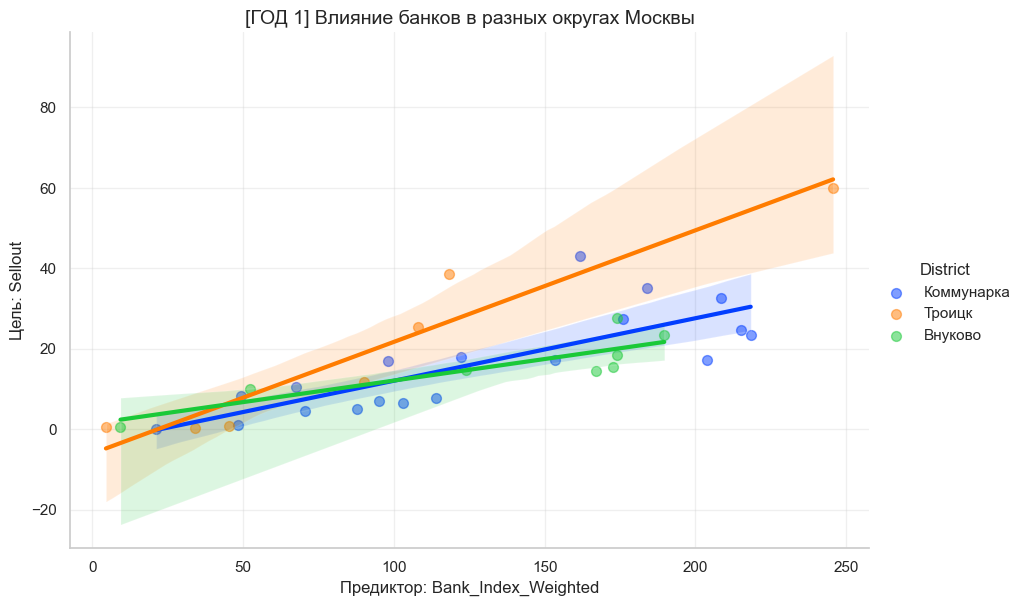


########################################
📅 АНАЛИЗ ЗА ГОД 2
########################################

   📍 ОКРУГ: Коммунарка
      R²: 0.8055 | Проектов: 11
      Влияние (Bank_Index_Weighted): 0.1429 [✅ ЗНАЧИМО, p=0.0083]

   📍 ОКРУГ: Внуково
      R²: 0.9350 | Проектов: 5
      Влияние (Bank_Index_Weighted): 0.2352 [❌ СЛУЧАЙНО, p=0.2481]
   ⚠️ Троицк: Слишком мало данных (3 шт.)

   📈 График сравнения округов (Год 2)...


<Figure size 1000x600 with 0 Axes>

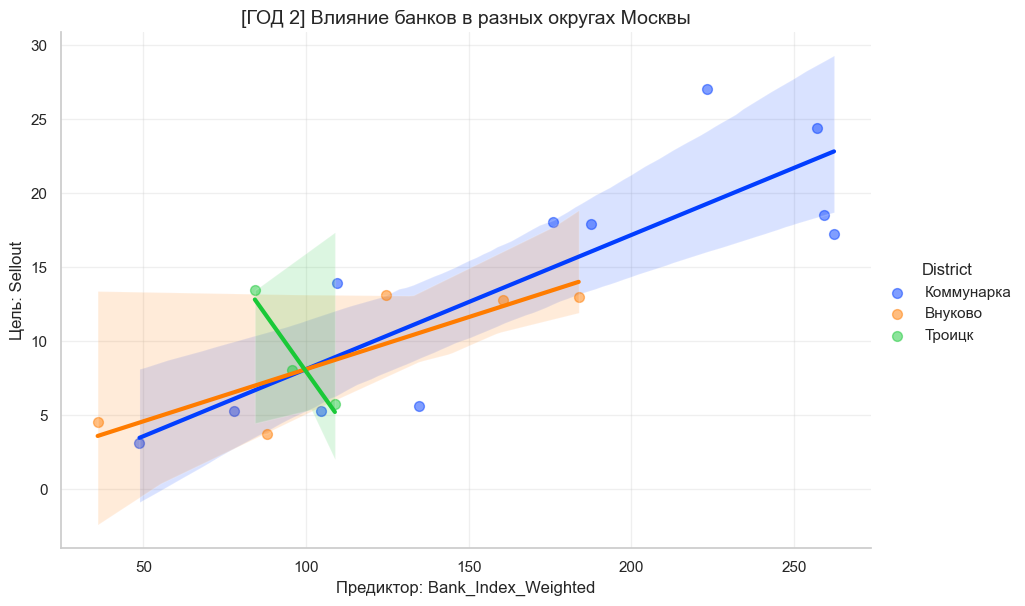

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

def analyze_district_robustness(df_main, path_deals_file, features, target="Sellout"):
    """
    Проверка на устойчивость: Разбиение по Топ-3 Округам.
    1. Подтягивает Округ из raw-файла сделок.
    2. Выбирает 3 округа с наибольшим числом проектов.
    3. Строит модели и сравнивает влияние банков в каждом округе.
    """
    print(f"{'='*80}")
    print("🏙️ ПРОВЕРКА НА УСТОЙЧИВОСТЬ: ТОП-3 ОКРУГА (Location Robustness)")
    print(f"{'='*80}")
    
    # --- ШАГ 1: ПОДТЯГИВАЕМ ОКРУГА ---
    try:
        # Читаем только нужные колонки для скорости
        raw_deals = pd.read_excel(path_deals_file)
        
        # Проверяем название колонки (обычно 'Округ' или 'Административный округ')
        col_district = next((c for c in raw_deals.columns if "округ" in c.lower()), None)
        
        if not col_district:
            print("❌ Ошибка: Не найдена колонка 'Округ' в файле сделок.")
            return

        # Создаем маппинг: Проект -> Округ (берем первый попавшийся, если их несколько)
        # Очистка имен проектов для корректного мерджа
        raw_deals["Проект"] = raw_deals["Название ЖК"].astype(str).str.strip()
        proj_dist_map = raw_deals.groupby("Проект")[col_district].first().reset_index()
        proj_dist_map.columns = ["Project", "District"]
        
        # Мерджим с основным датасетом
        df_geo = df_main.copy()
        df_geo = df_geo.merge(proj_dist_map, on="Project", how="left")
        
    except Exception as e:
        print(f"❌ Ошибка обработки файла сделок: {e}")
        return

    # --- ШАГ 2: ОПРЕДЕЛЯЕМ ТОП-3 ОКРУГА ---
    # Считаем уникальные проекты в каждом округе
    top_districts = df_geo.groupby("District")["Project"].nunique().nlargest(3).index.tolist()
    
    print(f"🏆 Топ-3 округа по количеству проектов: {', '.join(top_districts)}")
    
    # Фильтруем датасет (оставляем только эти 3 округа)
    df_geo = df_geo[df_geo["District"].isin(top_districts)]
    print(f"📊 Строк в выборке (Топ-3): {len(df_geo)}")
    
    # Главная фича для анализа (должна быть первой в списке features)
    main_feature = features[0] 

    # --- ШАГ 3: ЦИКЛ ПО ГОДАМ ---
    for year in [1, 2]:
        print(f"\n{'#'*40}")
        print(f"📅 АНАЛИЗ ЗА ГОД {year}")
        print(f"{'#'*40}")
        
        df_year = df_geo[df_geo["Year_Num"] == year].copy()
        
        if df_year.empty:
            print(f"⚠️ Нет данных для Года {year}")
            continue

        # 3.1 Запуск регрессии для каждого округа
        for dist in top_districts:
            sub_df = df_year[df_year["District"] == dist].dropna(subset=features + [target])
            
            if len(sub_df) < 5:
                print(f"   ⚠️ {dist}: Слишком мало данных ({len(sub_df)} шт.)")
                continue
                
            X = sm.add_constant(sub_df[features])
            y = sub_df[target]
            model = sm.OLS(y, X).fit()
            
            coef = model.params.get(main_feature, 0)
            pval = model.pvalues.get(main_feature, 1)
            signif = "✅ ЗНАЧИМО" if pval < 0.05 else "❌ СЛУЧАЙНО"
            
            print(f"\n   📍 ОКРУГ: {dist}")
            print(f"      R²: {model.rsquared:.4f} | Проектов: {len(sub_df)}")
            print(f"      Влияние ({main_feature}): {coef:.4f} [{signif}, p={pval:.4f}]")
            
            # Если есть другие предикторы, выводим их кратко
            other_feats = [f for f in features if f != main_feature]
            if other_feats:
                sig_others = [f"{f} ({model.params[f]:.2f})" for f in other_feats if model.pvalues[f] < 0.1]
                if sig_others:
                    print(f"      📝 Доп. факторы (p<0.1): {', '.join(sig_others)}")

        # 3.2 ВИЗУАЛИЗАЦИЯ (Сравнение наклона прямых)
        print(f"\n   📈 График сравнения округов (Год {year})...")
        
        plt.figure(figsize=(10, 6))
        sns.lmplot(
            data=df_year, 
            x=main_feature, 
            y=target, 
            hue="District",
            palette="bright", # Яркая палитра для различия
            height=6, 
            aspect=1.5,
            scatter_kws={'alpha': 0.5, 's': 50},
            line_kws={'linewidth': 3}
        )
        
        plt.title(f"[ГОД {year}] Влияние банков в разных округах Москвы", fontsize=14)
        plt.xlabel(f"Предиктор: {main_feature}")
        plt.ylabel(f"Цель: {target}")
        plt.grid(True, alpha=0.3)
        plt.show()

# ==============================================================================
# ЗАПУСК
# ==============================================================================

# 1. Настраиваем список предикторов (МОЖНО МЕНЯТЬ ТУТ)
# Важно: Первым ставь тот фактор, влияние которого хочешь проверить на графике!
features_for_geo = [
    'Bank_Index_Weighted', # <--- Главный проверяемый фактор
    'KR_Mean',       # Контроль субсидий
    'Log_Area'             # Контроль масштаба
]

# 2. Запускаем функцию (используем df_all и путь к файлу сделок)
analyze_district_robustness(df_all, FILE_DEALS, features_for_geo, target="Sellout")

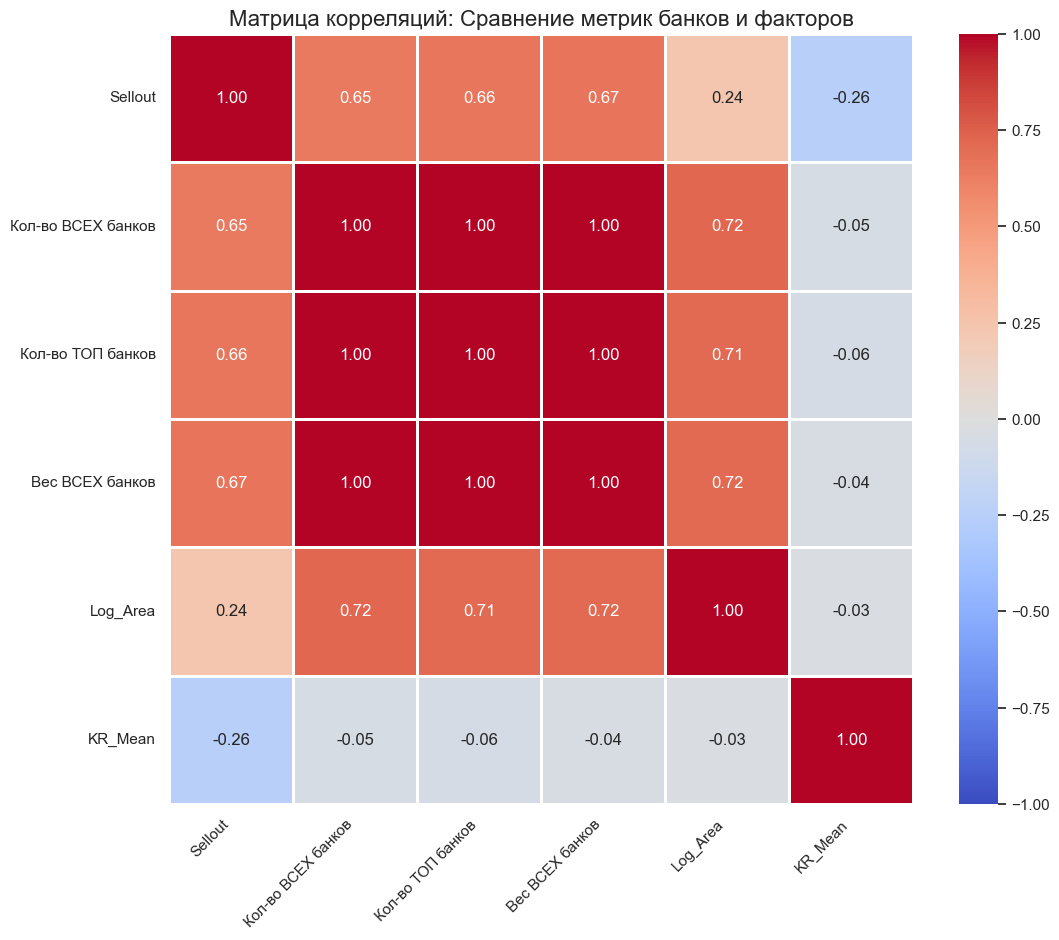

🔍 ВЫВОД: Обрати внимание на корреляцию между 'Кол-во ВСЕХ банков' и 'Кол-во ТОП банков'.
   Если она > 0.9, то фильтрация мало меняет суть. Если < 0.8 — разница существенна.


In [ ]:
# 1. Подготовка данных для сравнения
# Берем ключевые колонки из df_all
cols_base = ['Project', 'Year_Num', 'Sellout', 'Num_Banks_Filtered', 'Bank_Index_Weighted', 'Log_Area', 'KR_Mean']
df_corr = df_all[cols_base].copy()
df_corr = df_corr.rename(columns={'Num_Banks_Filtered': 'Кол-во ВСЕХ банков', 'Bank_Index_Weighted': 'Вес ВСЕХ банков'})

# Берем колонку "Количество" из отфильтрованного датасета
df_temp = df_filtered[['Project', 'Year_Num', 'Num_Banks_Filtered']].copy()
df_temp = df_temp.rename(columns={'Num_Banks_Filtered': 'Кол-во ТОП банков'})

# Объединяем
df_corr_final = df_corr.merge(df_temp, on=['Project', 'Year_Num'], how='inner')

# Оставляем только числовые колонки для матрицы
cols_for_heatmap = ['Sellout', 'Кол-во ВСЕХ банков', 'Кол-во ТОП банков', 'Вес ВСЕХ банков', 'Log_Area', 'KR_Mean']
corr_matrix = df_corr_final[cols_for_heatmap].corr()

# 2. Рисуем график
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, vmin=-1, vmax=1)
plt.title("Матрица корреляций: Сравнение метрик банков и факторов", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

print("🔍 ВЫВОД: Обрати внимание на корреляцию между 'Кол-во ВСЕХ банков' и 'Кол-во ТОП банков'.")
print("   Если она > 0.9, то фильтрация мало меняет суть. Если < 0.8 — разница существенна.")

In [ ]:
import pandas as pd
import statsmodels.api as sm

def analyze_top_errors(df, features, target="Sellout", year_label=""):
    """
    Обучает модель, находит 5 проектов с максимальной ошибкой прогноза 
    и выводит их подробное 'досье'.
    """
    # 1. Подготовка данных
    data = df.copy()
    data = data.dropna(subset=features + [target])
    
    # 2. Обучение модели
    X = sm.add_constant(data[features])
    y = data[target]
    model = sm.OLS(y, X).fit()
    
    # 3. Расчет прогнозов и ошибок
    data['Predicted'] = model.predict(X)
    data['Error'] = data[target] - data['Predicted'] # Ошибка = Факт - Прогноз
    data['Abs_Error'] = data['Error'].abs()          # Абсолютная ошибка для сортировки
    
    # 4. Сортировка и выбор Топ-5
    top_errors = data.sort_values('Abs_Error', ascending=False).head(5)
    
    # 5. Красивый вывод
    print(f"\n{'#'*80}")
    print(f"🚩 ТОП-5 АНОМАЛИЙ (Максимальные ошибки модели) | {year_label}")
    print(f"{'#'*80}")
    print(f"R² модели: {model.rsquared:.4f}")
    print("Пояснение: ")
    print("   • Ошибка > 0: Проект продавался ЛУЧШЕ, чем ожидала модель (Недооценка).")
    print("   • Ошибка < 0: Проект продавался ХУЖЕ, чем ожидала модель (Переоценка).")
    print("-" * 80)

    # Словарь для перевода (если используешь TRANS_MAP из 0-й ячейки, иначе оставь как есть)
    # Здесь определим локально, чтобы ячейка была автономной
    cols_map = {
        'Project': 'ПРОЕКТ',
        'Sellout': 'ФАКТ (Sellout %)',
        'Predicted': 'ПРОГНОЗ Модели',
        'Error': 'ОШИБКА (Разница)',
        'Num_Banks_Filtered': 'Кол-во Банков',
        'Bank_Index_Weighted': 'Вес Банков (Log)',
        'Log_Area': 'Масштаб (Log Area)',
        'KR_Mean': 'Ср. Ключевая ставка',
        'Subsidy_Share': 'Доля периода субсидий'
    }

    for i, (idx, row) in enumerate(top_errors.iterrows(), 1):
        print(f"\n🏆 МЕСТО #{i}: {row['Project']} (Класс: {row.get('Class', 'N/A')})")
        
        # Формируем мини-табличку для одного проекта
        stats_data = {
            "Показатель": [],
            "Значение": []
        }
        
        # Основные метрики ошибки
        stats_data["Показатель"].append("🔴 ОШИБКА (Факт - Прогноз)")
        stats_data["Значение"].append(f"{row['Error']:+.2f} p.p.")
        
        stats_data["Показатель"].append("ФАКТ (Реальный Sellout)")
        stats_data["Значение"].append(f"{row[target]:.2f}%")
        
        stats_data["Показатель"].append("ПРОГНОЗ Модели")
        stats_data["Значение"].append(f"{row['Predicted']:.2f}%")
        
        # Факторы (почему модель так решила)
        for feat in features:
            val = row[feat]
            name = cols_map.get(feat, feat)
            stats_data["Показатель"].append(f"   -> Фактор: {name}")
            stats_data["Значение"].append(f"{val:.4f}")

        # Вывод табличкой
        row_df = pd.DataFrame(stats_data)
        print(row_df.to_string(index=False, header=False, col_space=25, justify='left'))
        print("-" * 40)

# ==========================================
# ЗАПУСК
# ==========================================

# Определяем список переменных для "Полной модели"
features_check = [
    'Num_Banks_Filtered',   # Банки
    'Log_Area',             # Масштаб
    'KR_Mean',              # Ставка ЦБ
    'Subsidy_Share',        # Госпрограммы
    'Mortgage_Share'        # Доля ипотеки
]

# Запускаем анализ аномалий (Используем df_all - общий датасет)
# Если df_all не создан, замени на df_ml
target_df = df_all

# 1. Аномалии Первого года
analyze_top_errors(target_df[target_df["Year_Num"]==1], features_check, "Sellout", "ГОД 1")

# 2. Аномалии Второго года
analyze_top_errors(target_df[target_df["Year_Num"]==2], features_check, "Sellout", "ГОД 2")


################################################################################
🚩 ТОП-5 АНОМАЛИЙ (Максимальные ошибки модели) | ГОД 1
################################################################################
R² модели: 0.6466
Пояснение: 
   • Ошибка > 0: Проект продавался ЛУЧШЕ, чем ожидала модель (Недооценка).
   • Ошибка < 0: Проект продавался ХУЖЕ, чем ожидала модель (Переоценка).
--------------------------------------------------------------------------------

🏆 МЕСТО #1: Саларьево парк (Класс: Комфорт)
          🔴 ОШИБКА (Факт - Прогноз) +19.94 p.p.              
            ФАКТ (Реальный Sellout)      43.11%              
                     ПРОГНОЗ Модели      23.17%              
           -> Фактор: Кол-во Банков     16.0000              
      -> Фактор: Масштаб (Log Area)     11.4623              
     -> Фактор: Ср. Ключевая ставка     10.3919              
   -> Фактор: Доля периода субсидий      1.0000              
          -> Фактор: Mortgage_Share      0.7


################################################################################
📅 АНАЛИЗ ЗА ГОД 1 | Медиана площади: 90,711 м²
################################################################################
🔹 Маленьких проектов: 21
🔹 Больших проектов:   20

📊 --- SMALL (Маленькие) (Многофакторная модель) ---
   R²: 0.7620 | F-pvalue: 7.2950e-05
   🎯 Коэф. Bank_Index_Weighted: 0.1872 [✅ ЗНАЧИМО, p=0.0001]
   📝 Другие значимые факторы (p<0.05):
      (нет)

📊 --- LARGE (Большие) (Многофакторная модель) ---
   R²: 0.6282 | F-pvalue: 3.4228e-03
   🎯 Коэф. Bank_Index_Weighted: 0.1302 [✅ ЗНАЧИМО, p=0.0439]
   📝 Другие значимые факторы (p<0.05):
      • KR_Mean: 6.1702
      • Subsidy_Share: 84.5649

📈 ГРАФИК ГОДА 1: Сравнение трендов


<Figure size 1000x600 with 0 Axes>

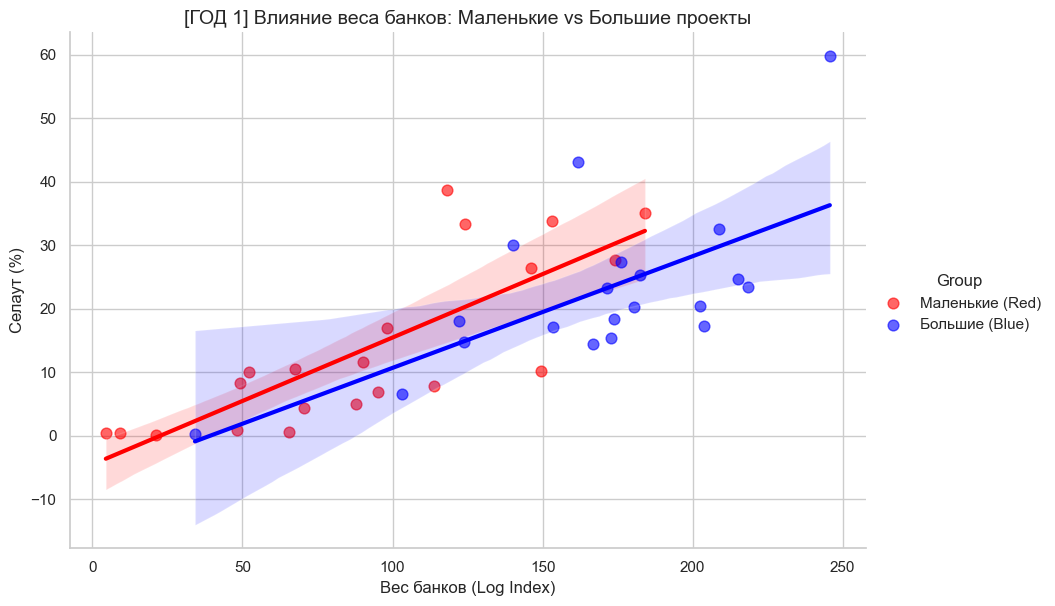


################################################################################
📅 АНАЛИЗ ЗА ГОД 2 | Медиана площади: 178,898 м²
################################################################################
🔹 Маленьких проектов: 13
🔹 Больших проектов:   13

📊 --- SMALL (Маленькие) (Многофакторная модель) ---
   R²: 0.5464 | F-pvalue: 1.3484e-01
   🎯 Коэф. Bank_Index_Weighted: 0.1394 [❌ СЛУЧАЙНО, p=0.1032]
   📝 Другие значимые факторы (p<0.05):
      (нет)

📊 --- LARGE (Большие) (Многофакторная модель) ---
   R²: 0.6371 | F-pvalue: 2.2645e-02
   🎯 Коэф. Bank_Index_Weighted: 0.0987 [✅ ЗНАЧИМО, p=0.0059]
   📝 Другие значимые факторы (p<0.05):
      (нет)

📈 ГРАФИК ГОДА 2: Сравнение трендов


<Figure size 1000x600 with 0 Axes>

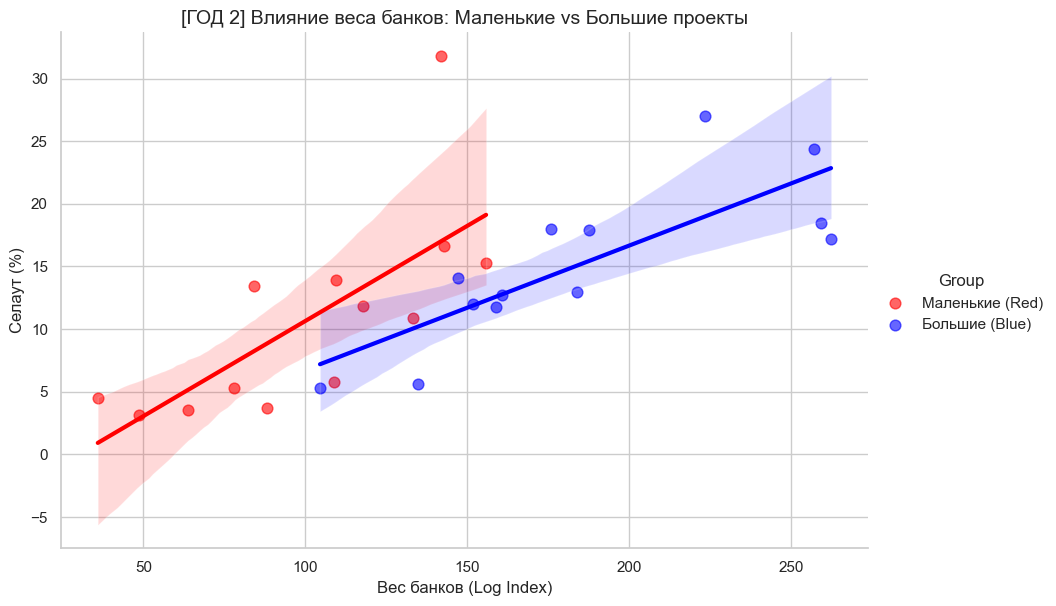

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

def analyze_size_split_by_year(df, features, target="Sellout"):
    """
    Для каждого года (1 и 2):
    1. Делит проекты на Small/Large по медиане площади.
    2. Строит многофакторные модели для каждой группы.
    3. Рисует график сравнения наклона прямых.
    """
    
    # Главная фича для графика (должна быть первой в списке features)
    main_feature = "Bank_Index_Weighted" 
    
    for year in [1, 2]:
        # 1. Фильтруем данные за конкретный год
        df_year = df[df["Year_Num"] == year].copy()
        
        if df_year.empty:
            print(f"⚠️ Нет данных для Года {year}")
            continue
            
        # 2. Считаем медиану и делим
        median_area = df_year["Planned_Area"].median()
        
        df_small = df_year[df_year["Planned_Area"] <= median_area].copy()
        df_large = df_year[df_year["Planned_Area"] > median_area].copy()
        
        # Добавляем метку группы для графика
        df_small["Group"] = "Маленькие (Red)"
        df_large["Group"] = "Большие (Blue)"
        
        print(f"\n{'#'*80}")
        print(f"📅 АНАЛИЗ ЗА ГОД {year} | Медиана площади: {median_area:,.0f} м²")
        print(f"{'#'*80}")
        print(f"🔹 Маленьких проектов: {len(df_small)}")
        print(f"🔹 Больших проектов:   {len(df_large)}")

        # 3. Функция обучения модели (МНОГОФАКТОРНАЯ)
        def run_model(sub_df, group_name):
            # Удаляем пропуски
            sub_df = sub_df.dropna(subset=features + [target])
            X = sm.add_constant(sub_df[features])
            y = sub_df[target]
            model = sm.OLS(y, X).fit()
            
            print(f"\n📊 --- {group_name} (Многофакторная модель) ---")
            print(f"   R²: {model.rsquared:.4f} | F-pvalue: {model.f_pvalue:.4e}")
            
            # Выводим влияние ВЕСА БАНКОВ
            if main_feature in model.params:
                coef = model.params[main_feature]
                pval = model.pvalues[main_feature]
                signif = "✅ ЗНАЧИМО" if pval < 0.05 else "❌ СЛУЧАЙНО"
                print(f"   🎯 Коэф. {main_feature}: {coef:.4f} [{signif}, p={pval:.4f}]")
            
            # Выводим остальные значимые факторы (кратко)
            print("   📝 Другие значимые факторы (p<0.05):")
            found = False
            for feat in features:
                if feat != main_feature and model.pvalues[feat] < 0.05:
                    print(f"      • {feat}: {model.params[feat]:.4f}")
                    found = True
            if not found: print("      (нет)")
            
            return model

        # Обучаем модели
        run_model(df_small, "SMALL (Маленькие)")
        run_model(df_large, "LARGE (Большие)")
        
        # 4. ВИЗУАЛИЗАЦИЯ
        print(f"\n📈 ГРАФИК ГОДА {year}: Сравнение трендов")
        
        # Объединяем для рисования
        df_viz = pd.concat([df_small, df_large])
        
        plt.figure(figsize=(10, 6))
        
        # Рисуем линии тренда (lmplot показывает парную корреляцию)
        # Примечание: График показывает "сырую" связь, а статистика выше — очищенную (с контролем других переменных)
        sns.lmplot(
            data=df_viz, 
            x=main_feature, 
            y=target, 
            hue="Group", 
            palette={"Маленькие (Red)": "red", "Большие (Blue)": "blue"},
            height=6, 
            aspect=1.5,
            scatter_kws={'alpha': 0.6, 's': 60},
            line_kws={'linewidth': 3}
        )
        
        plt.title(f"[ГОД {year}] Влияние веса банков: Маленькие vs Большие проекты", fontsize=14)
        plt.xlabel("Вес банков (Log Index)")
        plt.ylabel("Селаут (%)")
        plt.grid(True)
        plt.show()

# ==========================================
# ЗАПУСК
# ==========================================
# Используем df_all (общий датасет)
target_df = df_all if 'df_all' in locals() else df_ml

# Список контрольных переменных
# Важно: Bank_Index_Weighted должен идти ПЕРВЫМ, так как по нему строим график
features_robust = [
    'Bank_Index_Weighted', # <--- Главная
    'KR_Mean',             # Контроль макро
    'Subsidy_Share',       # Контроль госпрограмм
    'Mortgage_Share'       # Контроль типа сделок
    # Log_Area специально убрали, так как мы разделили выборку по площади
]

analyze_size_split_by_year(target_df, features_robust, "Sellout")


⏳ ЛАГОВЫЙ АНАЛИЗ (С АВТОРЕГРЕССИЕЙ): Влияние банков 1-го года на 2-й год
📌 R-squared: 0.3073
📌 Проектов в выборке: 26

📊 РЕЗУЛЬТАТЫ:
                              Коэффициент  P-значение Значимость
Константа                       -72.30598     0.20177          ❌
Вес Банков (В ГОД 1)             -0.00783     0.83868          ❌
Ключевая ставка (во 2-й год)      3.66547     0.20385          ❌
Доля субсидий (во 2-й год)       36.65431     0.08645          ❌
Успех продаж 1-го года            0.26159     0.07957          ❌
--------------------------------------------------------------------------------


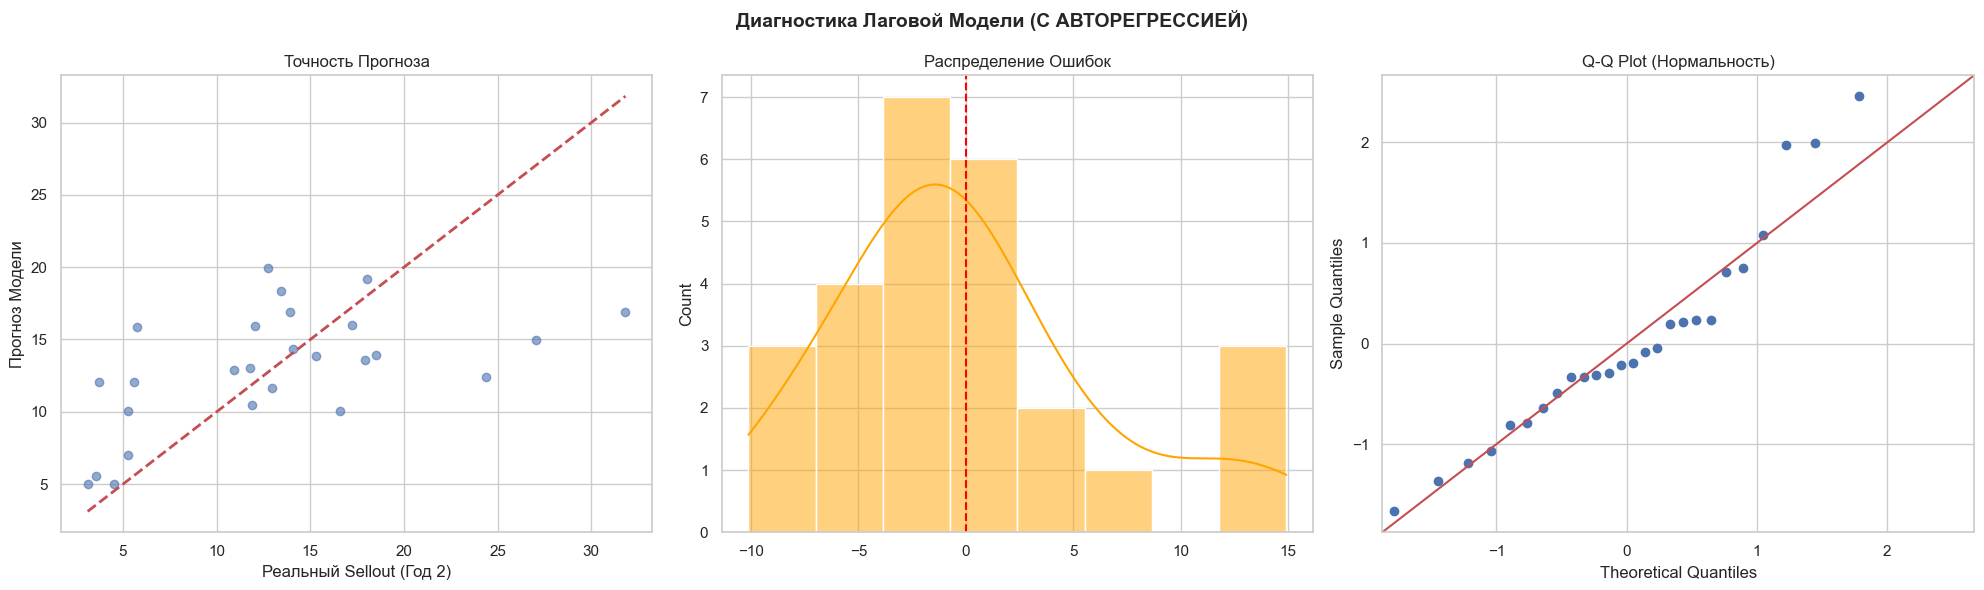

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

def analyze_lagged_effect(df, include_autoregression=False):
    """
    Строит модель зависимости продаж 2-го года от банков 1-го года.
    Параметр include_autoregression=False отключает влияние продаж прошлого года.
    """
    mode_text = "С АВТОРЕГРЕССИЕЙ" if include_autoregression else "БЕЗ АВТОРЕГРЕССИИ"
    print(f"\n{'='*80}")
    print(f"⏳ ЛАГОВЫЙ АНАЛИЗ ({mode_text}): Влияние банков 1-го года на 2-й год")
    print(f"{'='*80}")
    
    # 1. Подготовка данных
    # Данные 1-го года (Предикторы)
    df_y1 = df[df["Year_Num"] == 1][['Project', 'Num_Banks_Filtered', 'Bank_Index_Weighted', 'Sellout']].copy()
    df_y1 = df_y1.rename(columns={
        'Bank_Index_Weighted': 'Bank_Weight_Y1', # Наш главный герой
        'Sellout': 'Sellout_Y1'                  # Успех прошлого года
    })
    
    # Данные 2-го года (Таргет + Макро)
    df_y2 = df[df["Year_Num"] == 2][['Project', 'Sellout', 'KR_Mean', 'Subsidy_Share', 'Log_Area']].copy()
    df_y2 = df_y2.rename(columns={'Sellout': 'Sellout_Y2'})
    
    # Объединяем (Intersection)
    df_lag = df_y1.merge(df_y2, on='Project', how='inner')
    
    # 2. Формируем список фичей
    features = ['Bank_Weight_Y1', 'KR_Mean', 'Subsidy_Share']
    
    if include_autoregression:
        features.append('Sellout_Y1') # Добавляем успех прошлого года, если просили
    
    # Удаляем пропуски
    target = 'Sellout_Y2'
    df_lag = df_lag.dropna(subset=features + [target])
    
    # 3. Обучение
    X = sm.add_constant(df_lag[features])
    y = df_lag[target]
    model = sm.OLS(y, X).fit()
    
    # 4. ТЕКСТОВОЙ ОТЧЕТ
    print(f"📌 R-squared: {model.rsquared:.4f}")
    print(f"📌 Проектов в выборке: {len(df_lag)}")
    
    summary_df = pd.DataFrame({
        "Коэффициент": model.params,
        "P-значение": model.pvalues,
        "Значимость": model.pvalues.apply(lambda p: "⭐⭐⭐" if p<0.001 else ("⭐⭐" if p<0.01 else ("⭐" if p<0.05 else "❌")))
    })
    
    # Перевод названий
    names_map = {
        "const": "Константа",
        "Bank_Weight_Y1": "Вес Банков (В ГОД 1)",
        "Sellout_Y1": "Успех продаж 1-го года",
        "KR_Mean": "Ключевая ставка (во 2-й год)",
        "Subsidy_Share": "Доля субсидий (во 2-й год)"
    }
    summary_df.index = summary_df.index.map(lambda x: names_map.get(x, x))
    
    print("\n📊 РЕЗУЛЬТАТЫ:")
    print(summary_df)
    print("-" * 80)
    
    # 5. ГРАФИКИ (3 Штуки: Прогноз, Остатки, QQ)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f"Диагностика Лаговой Модели ({mode_text})", fontsize=14, weight='bold')
    
    # График 1: Факт vs Прогноз
    preds = model.predict(X)
    axes[0].scatter(y, preds, alpha=0.6, edgecolors='b')
    axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    axes[0].set_xlabel("Реальный Sellout (Год 2)")
    axes[0].set_ylabel("Прогноз Модели")
    axes[0].set_title("Точность Прогноза")

    # График 2: Гистограмма остатков
    residuals = model.resid
    sns.histplot(residuals, kde=True, ax=axes[1], color='orange')
    axes[1].set_title("Распределение Ошибок")
    axes[1].axvline(0, color='red', linestyle='--')

    # График 3: QQ-Plot
    sm.qqplot(residuals, line='45', fit=True, ax=axes[2])
    axes[2].set_title("Q-Q Plot (Нормальность)")

    plt.tight_layout()
    plt.show()

# ==========================================
# ЗАПУСК
# ==========================================
# Выбираем датасет (лучше df_all, чтобы было больше данных для лагов)
target_df = df_all if 'df_all' in locals() else df_ml

# 1. ЗАПУСК БЕЗ АВТОРЕГРЕССИИ (Чистое влияние банков)
analyze_lagged_effect(target_df, include_autoregression=True)

# 2. (ОПЦИОНАЛЬНО) ЗАПУСК С АВТОРЕГРЕССИЕЙ 
# Раскомментируй строку ниже, если хочешь увидеть вариант с учетом продаж прошлого года
# analyze_lagged_effect(target_df, include_autoregression=True)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import timedelta
import warnings

# Настройки
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Пути к файлам (замените на свои, если нужно)
FILE_PROJ = "Проектные данные_2025-11-25.xlsx"
FILE_DEALS = "Сделки_2025-11-25.xlsx"

In [ ]:
def prepare_data_and_bank_weights(path_proj, path_deals):
    print("🚀 ЭТАП 1: Загрузка и расчет весов банков...")
    
    # 1. Загрузка
    proj = pd.read_excel(path_proj)
    deals = pd.read_excel(path_deals)

    # 2. Очистка чисел
    def clean_num(x):
        return pd.to_numeric(str(x).replace("\u00a0", "").replace(" ", "").replace(",", "."), errors="coerce") or 0

    for col in ["Общая проектная площадь", "Суммарная площадь сделок"]:
        if col in proj.columns: proj[col] = proj[col].apply(clean_num)
        if col in deals.columns: deals[col] = deals[col].apply(clean_num)

    # 3. Очистка ID и Дат
    for df in [proj, deals]:
        df['ID корпуса'] = df['ID корпуса'].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()

    deals["dt_deal"] = pd.to_datetime(deals["Дата договора (месяц.год)"], dayfirst=True, errors="coerce")
    mask_na = deals["dt_deal"].isna()
    if mask_na.any():
        deals.loc[mask_na, "dt_deal"] = pd.to_datetime(
            "01." + deals.loc[mask_na, "Дата договора (месяц.год)"].astype(str), dayfirst=True, errors="coerce")
    deals = deals.dropna(subset=["dt_deal"])

    # 4. Мэппинг проектов
    corpus_map = proj[["ID корпуса", "Проект"]].drop_duplicates()
    deals = deals.merge(corpus_map, on="ID корпуса", how="left")
    deals = deals.dropna(subset=["Проект"])

    # 5. РАСЧЕТ ВЕСОВ БАНКОВ (Глобальный)
    # Нормализуем названия
    deals["Название банка"] = deals["Название банка"].fillna("Не указан").astype(str).str.strip()
    
    # Группируем по банкам
    bank_stats = deals.groupby("Название банка")["Суммарная площадь сделок"].sum().reset_index()
    
    # Считаем Log-вес (сглаживаем разницу между гигантами и середняками)
    bank_stats["Bank_Weight"] = np.log1p(bank_stats["Суммарная площадь сделок"])
    
    # Создаем словарь весов
    weights_dict = bank_stats.set_index("Название банка")["Bank_Weight"].to_dict()
    
    print(f"✅ Обработано банков: {len(bank_stats)}")
    print(f"   Топ-банк по весу: {bank_stats.sort_values('Bank_Weight', ascending=False).iloc[0]['Название банка']}")
    
    return proj, deals, weights_dict

# Запуск
proj_df, deals_df, bank_weights_map = prepare_data_and_bank_weights(FILE_PROJ, FILE_DEALS)

🚀 ЭТАП 1: Загрузка и расчет весов банков...
✅ Обработано банков: 65
   Топ-банк по весу: ПАО Сбербанк России


In [ ]:
def create_incremental_dataset(proj, deals, weights_map, max_horizon=12):
    print(f"\n🚀 ЭТАП 2: Сборка данных (Горизонт: {max_horizon} мес.)")
    
    # Старт продаж и площади проектов
    proj_starts = deals.groupby("Проект")["dt_deal"].min().reset_index().rename(columns={"dt_deal": "start_date"})
    proj_areas = proj.groupby("Проект")["Общая проектная площадь"].sum().reset_index()
    
    dataset = []
    
    for project in proj_starts["Проект"].unique():
        # Базовые параметры проекта
        start_date = proj_starts.loc[proj_starts["Проект"] == project, "start_date"].values[0]
        start_date = pd.to_datetime(start_date)
        
        area_rows = proj_areas.loc[proj_areas["Проект"] == project, "Общая проектная площадь"]
        if area_rows.empty: continue
        total_area = area_rows.values[0]
        if total_area < 100: continue # Пропуск мусора
            
        # Сделки по этому проекту
        p_deals = deals[deals["Проект"] == project].copy()
        
        # Вычисляем порядковый номер месяца для каждой сделки (0, 1, 2...)
        p_deals["Month_Num"] = (
            (p_deals["dt_deal"].dt.year - start_date.year) * 12 + 
            (p_deals["dt_deal"].dt.month - start_date.month)
        ).astype(int)
        
        # Цикл по месяцам (от 0 до max_horizon)
        # Мы стоим в месяце 'm' и пытаемся предсказать продажи в 'm+1'
        
        accumulated_banks = set() # Сет банков, которые УЖЕ зашли в проект
        
        for m in range(max_horizon):
            # 1. ФИЧИ: Накопленные банки к концу месяца m
            # Берем все сделки до текущего момента включительно
            past_deals = p_deals[p_deals["Month_Num"] <= m]
            
            # Находим ипотечные сделки и обновляем сет банков
            mort_deals = past_deals[past_deals["Ипотека"].astype(str).str.lower().isin(['да', 'yes', 'true', '1', 'ипотека'])]
            current_banks = set(mort_deals["Название банка"].unique())
            accumulated_banks.update(current_banks)
            
            # Считаем суммарный вес банков, присутствующих в проекте на данный момент
            curr_weight = sum([weights_map.get(b, 0) for b in accumulated_banks])
            
            # 2. ТАРГЕТ: Продажи ТОЛЬКО в месяце m+1 (Прирост)
            target_deals = p_deals[p_deals["Month_Num"] == (m + 1)]
            sales_sqm_in_next_month = target_deals["Суммарная площадь сделок"].sum()
            
            # % от общей площади (Increment Sellout %)
            inc_sellout = (sales_sqm_in_next_month / total_area) * 100
            
            dataset.append({
                "Project": project,
                "Month_Features": m,          # Месяц, когда мы собираем данные о банках
                "Month_Target": m + 1,        # Месяц, который предсказываем
                "Bank_Index_Accumulated": curr_weight, # Накопленный вес банков
                "Banks_Count_Accumulated": len(accumulated_banks),
                "Sellout_Increment": inc_sellout # Сколько % площади продано в след. месяце
            })
            
    df_res = pd.DataFrame(dataset)
    
    # Фильтр выбросов (если продали > 25% дома за месяц - это опт или ошибка, убираем для чистоты)
    df_res = df_res[(df_res["Sellout_Increment"] >= 0) & (df_res["Sellout_Increment"] <= 25)]
    
    print(f"✅ Датасет готов. Строк: {len(df_res)}")
    return df_res

# Запуск
df_model = create_incremental_dataset(proj_df, deals_df, bank_weights_map)


🚀 ЭТАП 2: Сборка данных (Горизонт: 12 мес.)
✅ Датасет готов. Строк: 540



🚀 ЭТАП 3: Обучение модели (Prediction of Incremental Sales)
------------------------------------------------------------
📌 R-squared: 0.2653 (Объясняющая способность)
📌 P-value (Bank Index): 6.4672e-38
------------------------------------------------------------
                          Coef   P-val Significance
const                  0.22422 0.04486            ❌
Bank_Index_Accumulated 0.01448 0.00000          ⭐⭐⭐


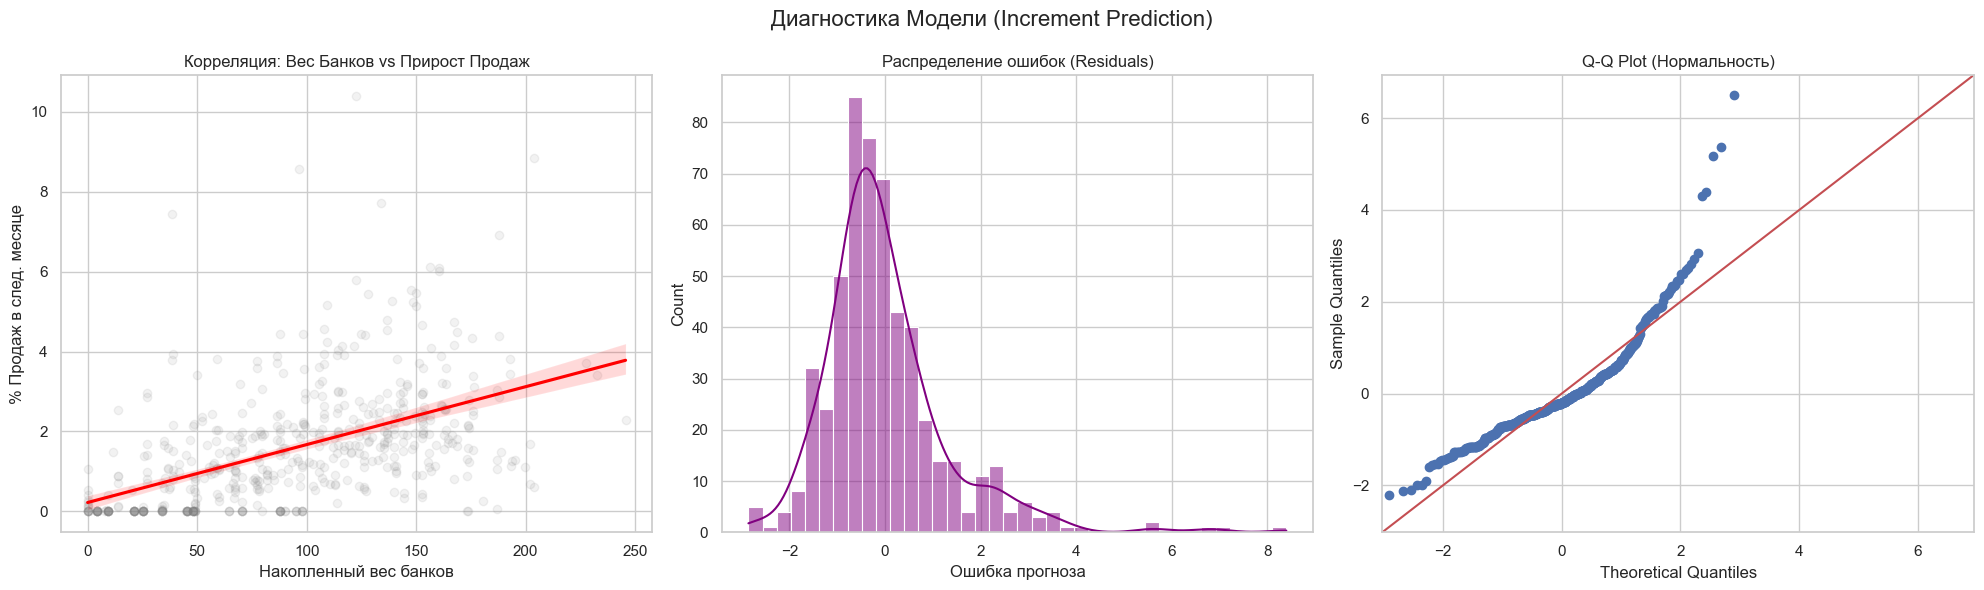

In [ ]:
def run_model_and_diagnostics(df):
    print(f"\n🚀 ЭТАП 3: Обучение модели (Prediction of Incremental Sales)")
    
    # Переменные
    X = df["Bank_Index_Accumulated"] # Предиктор: Накопленный вес банков
    y = df["Sellout_Increment"]      # Таргет: Продажи следующего месяца
    
    X_const = sm.add_constant(X)
    
    model = sm.OLS(y, X_const).fit()
    
    # --- ВЫВОД РЕЗУЛЬТАТОВ ---
    print(f"{'-'*60}")
    print(f"📌 R-squared: {model.rsquared:.4f} (Объясняющая способность)")
    print(f"📌 P-value (Bank Index): {model.pvalues['Bank_Index_Accumulated']:.4e}")
    print(f"{'-'*60}")
    
    summary_df = pd.DataFrame({
        "Coef": model.params,
        "P-val": model.pvalues,
        "Significance": model.pvalues.apply(lambda p: "⭐⭐⭐" if p<0.001 else "❌")
    })
    print(summary_df)
    
    # --- СОХРАНЕНИЕ ГРАФИКОВ ДИАГНОСТИКИ ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle("Диагностика Модели (Increment Prediction)", fontsize=16)
    
    # 1. Scatter: Банки vs Продажи
    sns.regplot(x=df["Bank_Index_Accumulated"], y=df["Sellout_Increment"], ax=axes[0], 
                scatter_kws={'alpha':0.1, 'color':'gray'}, line_kws={'color':'red'})
    axes[0].set_title("Корреляция: Вес Банков vs Прирост Продаж")
    axes[0].set_xlabel("Накопленный вес банков")
    axes[0].set_ylabel("% Продаж в след. месяце")
    
    # 2. Остатки
    sns.histplot(model.resid, ax=axes[1], kde=True, color='purple')
    axes[1].set_title("Распределение ошибок (Residuals)")
    axes[1].set_xlabel("Ошибка прогноза")
    
    # 3. QQ Plot
    sm.qqplot(model.resid, line='45', fit=True, ax=axes[2])
    axes[2].set_title("Q-Q Plot (Нормальность)")
    
    plt.tight_layout()
    plt.savefig("model_diagnostics.png", dpi=100) # Сохраняем
    plt.show()
    
    return model

# Запуск
model_result = run_model_and_diagnostics(df_model)


🚀 ЭТАП 4: Анализ Динамики Прироста (Sales Pace Analysis)


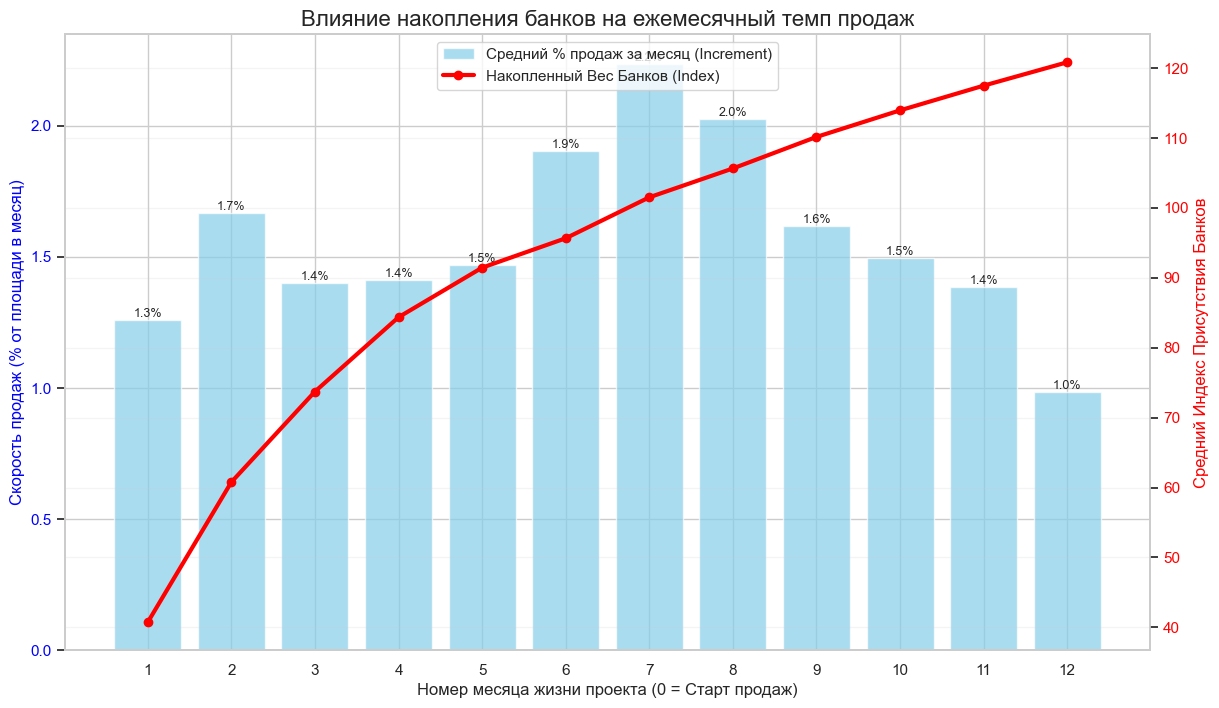


📝 АНАЛИТИЧЕСКАЯ СПРАВКА ПО ГРАФИКУ
График показывает среднюю «температуру по больнице» за первые 12 месяцев жизни проектов.

1. СИНИЕ СТОЛБЦЫ (Темп продаж):
   Показывают, сколько процентов от всего дома продается в конкретный месяц.
   - Высокий старт (Мес 1-2): Эффект отложенного спроса и стартовых цен.
   - Стабилизация (Мес 4-8): Выход на 'крейсерскую скорость'.

2. КРАСНАЯ ЛИНИЯ (Банки):
   Показывает, как быстро проекты обрастают банковскими аккредитациями.
   - Резкий рост в начале: Застройщики стараются подключить ключевых игроков сразу.
   - Плато: После 6-8 месяца набор банков замедляется, остаются только нишевые игроки.

3. ВЫВОД ДЛЯ БИЗНЕСА:
   Корреляция между накопленной базой банков и продажами следующего месяца: 0.52
   ✅ Гипотеза работает: Чем мощнее пул банков к началу месяца, тем выше продажи в следующем.


In [ ]:
def plot_incremental_dynamics(df):
    print(f"\n🚀 ЭТАП 4: Анализ Динамики Прироста (Sales Pace Analysis)")
    
    # Агрегируем среднее по месяцам жизни проекта
    monthly_stats = df.groupby("Month_Target").agg({
        "Sellout_Increment": "mean",
        "Bank_Index_Accumulated": "mean"
    })
    
    # Создаем график с двумя осями
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Ось 1 (Бары): Сколько продали в этом месяце (Прирост)
    bars = ax1.bar(monthly_stats.index, monthly_stats["Sellout_Increment"], 
                   color='skyblue', alpha=0.7, label='Средний % продаж за месяц (Increment)')
    ax1.set_xlabel('Номер месяца жизни проекта (0 = Старт продаж)', fontsize=12)
    ax1.set_ylabel('Скорость продаж (% от площади в месяц)', fontsize=12, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(monthly_stats.index)
    
    # Ось 2 (Линия): Как рос вес банков
    ax2 = ax1.twinx()
    line = ax2.plot(monthly_stats.index, monthly_stats["Bank_Index_Accumulated"], 
             color='red', linewidth=3, marker='o', label='Накопленный Вес Банков (Index)')
    ax2.set_ylabel('Средний Индекс Присутствия Банков', fontsize=12, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Легенда
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper center', fontsize=11)
    
    plt.title("Влияние накопления банков на ежемесячный темп продаж", fontsize=16)
    plt.grid(True, alpha=0.2)
    
    # Добавляем значения над барами
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.savefig("incremental_sales_dynamics.png", dpi=120)
    plt.show()
    
    # --- ТЕКСТОВОЕ ОПИСАНИЕ (АВТОМАТИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ) ---
    print(f"\n{'='*80}")
    print("📝 АНАЛИТИЧЕСКАЯ СПРАВКА ПО ГРАФИКУ")
    print(f"{'='*80}")
    print("График показывает среднюю «температуру по больнице» за первые 12 месяцев жизни проектов.")
    print("\n1. СИНИЕ СТОЛБЦЫ (Темп продаж):")
    print("   Показывают, сколько процентов от всего дома продается в конкретный месяц.")
    print("   - Высокий старт (Мес 1-2): Эффект отложенного спроса и стартовых цен.")
    print("   - Стабилизация (Мес 4-8): Выход на 'крейсерскую скорость'.")
    print("\n2. КРАСНАЯ ЛИНИЯ (Банки):")
    print("   Показывает, как быстро проекты обрастают банковскими аккредитациями.")
    print("   - Резкий рост в начале: Застройщики стараются подключить ключевых игроков сразу.")
    print("   - Плато: После 6-8 месяца набор банков замедляется, остаются только нишевые игроки.")
    print("\n3. ВЫВОД ДЛЯ БИЗНЕСА:")
    corr = df[["Sellout_Increment", "Bank_Index_Accumulated"]].corr().iloc[0,1]
    print(f"   Корреляция между накопленной базой банков и продажами следующего месяца: {corr:.2f}")
    if corr > 0.1:
        print("   ✅ Гипотеза работает: Чем мощнее пул банков к началу месяца, тем выше продажи в следующем.")
    else:
        print("   ⚠️ Связь слабая: Возможно, работает эффект 'новизны' проекта, а не количество банков.")

# Запуск
plot_incremental_dynamics(df_model)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (16, 6)

# ==============================================================================
# 1. ГЕНЕРАТОР ДАТАСЕТА (ETL)
# ==============================================================================
def prepare_incremental_dataset(
    path_proj, 
    path_deals, 
    horizon_months=24,
    bank_weight_metric='log_area' # 'log_area' или 'count'
):
    """
    Собирает панельный датасет: Жизненный цикл проекта (Month 0 -> Horizon).
    """
    print(f"🚀 ЗАПУСК ETL: Сборка инкрементального датасета (Горизонт: {horizon_months} мес)...")
    
    # --- 1.1 Макро-данные (Вшитая история ставки) ---
    key_rate_data = [
        ('2013-09-13', '2014-03-02', 5.50), ('2014-03-03', '2014-04-24', 7.00), ('2014-04-25', '2014-07-27', 7.50),
        ('2014-07-28', '2014-11-04', 8.00), ('2014-11-05', '2014-12-11', 9.50), ('2014-12-12', '2014-12-15', 10.50),
        ('2014-12-16', '2015-02-01', 17.00), ('2015-02-02', '2015-03-15', 15.00), ('2015-03-16', '2015-05-04', 14.00),
        ('2015-05-05', '2015-06-15', 12.50), ('2015-06-16', '2015-08-02', 11.50), ('2015-08-03', '2016-06-13', 11.00),
        ('2016-06-14', '2016-09-18', 10.50), ('2016-09-19', '2017-03-26', 10.00), ('2017-03-27', '2017-05-01', 9.75),
        ('2017-05-02', '2017-06-18', 9.25), ('2017-06-19', '2017-09-17', 9.00), ('2017-09-18', '2017-10-29', 8.50),
        ('2017-10-30', '2017-12-17', 8.25), ('2017-12-18', '2018-02-11', 7.75), ('2018-02-12', '2018-03-25', 7.50),
        ('2018-03-26', '2018-09-16', 7.25), ('2018-09-17', '2018-12-16', 7.50), ('2018-12-17', '2019-06-16', 7.75),
        ('2019-06-17', '2019-07-28', 7.50), ('2019-07-29', '2019-09-08', 7.25), ('2019-09-09', '2019-10-27', 7.00),
        ('2019-10-28', '2019-12-15', 6.50), ('2019-12-16', '2020-02-09', 6.25), ('2020-02-10', '2020-04-26', 6.00),
        ('2020-04-27', '2020-06-21', 5.50), ('2020-06-22', '2020-07-26', 4.50), ('2020-07-27', '2021-03-21', 4.25),
        ('2021-03-22', '2021-04-25', 4.50), ('2021-04-26', '2021-06-14', 5.00), ('2021-06-15', '2021-07-25', 5.50),
        ('2021-07-26', '2021-09-12', 6.50), ('2021-09-13', '2021-10-24', 6.75), ('2021-10-25', '2021-12-19', 7.50),
        ('2021-12-20', '2022-02-13', 8.50), ('2022-02-14', '2022-02-27', 9.50), ('2022-02-28', '2022-04-10', 20.00),
        ('2022-04-11', '2022-05-03', 17.00), ('2022-05-04', '2022-05-26', 14.00), ('2022-05-27', '2022-06-13', 11.00),
        ('2022-06-14', '2022-07-24', 9.50), ('2022-07-25', '2022-09-18', 8.00), ('2022-09-19', '2022-12-31', 7.50),
        ('2023-01-01', '2023-07-26', 7.5), ('2023-07-27', '2023-08-14', 8.5), ('2023-08-15', '2023-09-17', 12.0),
        ('2023-09-18', '2023-10-29', 13.0), ('2023-10-30', '2023-12-17', 15.0), ('2023-12-18', '2024-07-28', 16.0),
        ('2024-07-29', '2024-09-15', 18.0), ('2024-09-16', '2024-12-27', 19.0), ('2024-12-28', '2025-06-08', 21.0)
    ]
    macro_idx = pd.date_range(start='2018-01-01', end='2025-12-31', freq='D')
    macro_df = pd.DataFrame(index=macro_idx)
    macro_df['key_rate'] = np.nan
    for start, end, rate in key_rate_data:
        mask = (macro_df.index >= pd.to_datetime(start)) & (macro_df.index <= pd.to_datetime(end))
        macro_df.loc[mask, 'key_rate'] = rate
    macro_df = macro_df.ffill()

    def get_avg_key_rate(dt_target):
        try:
            start_dt = dt_target.replace(day=1)
            end_dt = start_dt + pd.offsets.MonthEnd(0)
            subset = macro_df.loc[start_dt:end_dt]
            return subset['key_rate'].mean() if not subset.empty else 10.0
        except: return 10.0

    # --- 1.2 Загрузка и очистка ---
    def clean_num(x):
        if pd.isna(x): return 0
        val = str(x).replace("\u00a0", "").replace(" ", "").replace(",", ".")
        return pd.to_numeric(val, errors="coerce") or 0

    proj = pd.read_excel(path_proj)
    deals = pd.read_excel(path_deals)

    for col in ["Общая проектная площадь", "Суммарная площадь сделок"]:
        if col in proj.columns: proj[col] = proj[col].apply(clean_num)
        if col in deals.columns: deals[col] = deals[col].apply(clean_num)

    deals["dt_deal"] = pd.to_datetime(deals["Дата договора (месяц.год)"], dayfirst=True, errors="coerce")
    deals = deals.dropna(subset=["dt_deal"])
    
    # Мэппинг
    for df in [proj, deals]:
        df['ID корпуса'] = df['ID корпуса'].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()
    deals = deals.merge(proj[["ID корпуса", "Проект"]].drop_duplicates(), on="ID корпуса", how="left").dropna(subset=["Проект"])

    # --- 1.3 Расчет весов банков ---
    deals["Название банка"] = deals["Название банка"].fillna("Не ипотека").astype(str).str.strip()
    bank_stats = deals.groupby("Название банка").agg({"Суммарная площадь сделок": "sum", "Проект": "count"}).reset_index()
    
    if bank_weight_metric == 'log_area':
        bank_stats["weight"] = np.log1p(bank_stats["Суммарная площадь сделок"])
    else:
        bank_stats["weight"] = np.log1p(bank_stats["Проект"]) # по количеству сделок
        
    weights_map = bank_stats.set_index("Название банка")["weight"].to_dict()

    # --- 1.4 Сборка Dataset ---
    proj_starts = deals.groupby("Проект")["dt_deal"].min().reset_index().rename(columns={"dt_deal": "start_date"})
    proj_areas = proj.groupby("Проект")["Общая проектная площадь"].sum().reset_index()
    
    # Оптимизация: pre-calculate month offsets
    deals = deals.merge(proj_starts, on="Проект", how="left")
    deals["Month_Offset"] = ((deals["dt_deal"].dt.year - deals["start_date"].dt.year) * 12 + \
                             (deals["dt_deal"].dt.month - deals["start_date"].dt.month)).fillna(-1).astype(int)
    
    dataset = []
    mortgage_flags = ['да', 'yes', 'true', '1', 'ипотека']
    valid_projects = proj_areas[proj_areas["Общая проектная площадь"] > 100]["Проект"].unique()

    for project in valid_projects:
        p_area = proj_areas.loc[proj_areas["Проект"] == project, "Общая проектная площадь"].values[0]
        p_start = proj_starts.loc[proj_starts["Проект"] == project, "start_date"].values[0]
        
        # Подвыборка сделок проекта
        p_deals = deals[deals["Проект"] == project]
        accumulated_banks = set()
        
        for m in range(horizon_months):
            # Состояние (Features) на конец месяца m
            past_deals = p_deals[p_deals["Month_Offset"] <= m]
            
            # Обновляем банки
            new_banks = past_deals[past_deals["Ипотека"].astype(str).str.lower().isin(mortgage_flags)]["Название банка"].unique()
            accumulated_banks.update(new_banks)
            
            curr_weight = sum([weights_map.get(b, 0) for b in accumulated_banks])
            
            # Продажи в m (для авторегрессии)
            curr_sales = past_deals[past_deals["Month_Offset"] == m]["Суммарная площадь сделок"].sum()
            
            # Цель (Target) в месяце m+1
            target_m = m + 1
            target_sales = p_deals[p_deals["Month_Offset"] == target_m]["Суммарная площадь сделок"].sum()
            target_date = p_start + pd.DateOffset(months=target_m)
            
            # Метрики
            so_inc = (target_sales / p_area) * 100
            prev_so = (curr_sales / p_area) * 100
            
            dataset.append({
                "Project": project,
                "Month_Num": target_m,
                "Log_Total_Area": np.log1p(p_area),
                "Key_Rate": get_avg_key_rate(target_date),
                "Bank_Accumulated_Index": curr_weight,
                "Banks_Count": len(accumulated_banks),
                "Prev_Month_Sellout": prev_so, # Lagged feature
                "Sellout_Increment": so_inc
            })

    df_res = pd.DataFrame(dataset)
    # Фильтрация явных ошибок (возвраты и оптовые выкупы > 30% дома за месяц)
    df_res = df_res[(df_res["Sellout_Increment"] >= 0) & (df_res["Sellout_Increment"] < 30)]
    
    print(f"✅ Датасет собран: {len(df_res)} наблюдений.")
    return df_res

# ==============================================================================
# 2. МОДЕЛЬ И ДИАГНОСТИКА (АНАЛИТИЧЕСКАЯ ФУНКЦИЯ)
# ==============================================================================
def train_incremental_model(
    df, 
    features, 
    target="Sellout_Increment", 
    title="Модель инкрементальных продаж"
):
    """
    Обучает OLS модель на переданных фичах и выводит полный отчет.
    """
    # 1. Подготовка
    data = df.dropna(subset=features + [target]).copy()
    X = sm.add_constant(data[features])
    y = data[target]
    
    # 2. Обучение
    model = sm.OLS(y, X).fit()
    preds = model.predict(X)
    
    # 3. Метрики
    r2_adj = model.rsquared_adj
    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mean_y = y.mean()
    
    # 4. Вывод текстового отчета
    print(f"\n{'='*90}")
    print(f"🔬 МОДЕЛЬ: {title}")
    print(f"{'='*90}")
    
    # Таблица метрик
    metrics_df = pd.DataFrame({
        "Метрика": ["Adj. R-squared", "RMSE (Ошибка % площади)", "MAE (Средний промах)", "Mean Target (Средний темп)"],
        "Значение": [r2_adj, rmse, mae, mean_y],
        "Комментарий": [
            "Чем ближе к 1.0, тем лучше", 
            f"В среднем ошибаемся на {rmse:.2f} п.п.", 
            f"Абсолютная ошибка {mae:.2f} п.п.", 
            f"Средняя скорость продаж: {mean_y:.2f}% в мес"
        ]
    })
    print(metrics_df.to_string(index=False))
    print("-" * 90)
    
    # Таблица коэффициентов
    coef_df = pd.DataFrame({
        "Коэффициент (Beta)": model.params,
        "Std. Error": model.bse,
        "P-value": model.pvalues,
        "Значимость": model.pvalues.apply(lambda p: "⭐⭐⭐" if p<0.001 else ("⭐⭐" if p<0.05 else ("⭐" if p<0.1 else "❌")))
    })
    
    # Словарь перевода для красоты
    trans_map = {
        "const": "Константа (Базовый уровень)",
        "Bank_Accumulated_Index": "🏦 Индекс Веса Банков",
        "Banks_Count": "🔢 Кол-во Банков",
        "Month_Num": "📅 Возраст проекта (мес)",
        "Key_Rate": "📉 Ключевая Ставка ЦБ",
        "Log_Total_Area": "🏗 Масштаб проекта (Log)",
        "Prev_Month_Sellout": "🔄 Продажи прошлого месяца (Lag)"
    }
    coef_df.index = coef_df.index.map(lambda x: trans_map.get(x, x))
    print(coef_df)
    print("-" * 90)

    # 5. Графики диагностики (3 шт)
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"Диагностика: {title}", fontsize=14, weight='bold')

    # А) Стандартизированные коэффициенты (Сила влияния)
    std_params = model.params * (data[features + [target]].std() / data[target].std())
    std_params = std_params.drop("const", errors='ignore')
    std_params.index = std_params.index.map(lambda x: trans_map.get(x, x))
    std_params.sort_values().plot(kind='barh', ax=axes[0], color='#4c72b0')
    axes[0].set_title("Сила влияния факторов (Std. Beta)")
    axes[0].axvline(0, color='black', linewidth=1)
    
    # Б) Факт vs Прогноз
    axes[1].scatter(y, preds, alpha=0.3, color='purple', s=15)
    axes[1].plot([0, y.max()], [0, y.max()], 'r--', lw=2)
    axes[1].set_xlabel("ФАКТ (% продаж)")
    axes[1].set_ylabel("ПРОГНОЗ модели")
    axes[1].set_title(f"Точность (R2 Adj: {r2_adj:.3f})")
    
    # В) Распределение остатков
    residuals = model.resid
    sns.histplot(residuals, kde=True, ax=axes[2], color='green')
    axes[2].set_title("Распределение ошибок (Residuals)")
    axes[2].axvline(0, color='red', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    return model

# ==============================================================================
# 3. ПРИМЕР ИСПОЛЬЗОВАНИЯ (ЗАПУСК)
# ==============================================================================



🚀 ЗАПУСК ETL: Сборка инкрементального датасета (Горизонт: 12 мес)...


✅ Датасет собран: 540 наблюдений.

🔬 МОДЕЛЬ: Вариант А: Влияние ТОЛЬКО банков 
                   Метрика  Значение                          Комментарий
            Adj. R-squared   0.26390           Чем ближе к 1.0, тем лучше
   RMSE (Ошибка % площади)   1.29105     В среднем ошибаемся на 1.29 п.п.
      MAE (Средний промах)   0.89623          Абсолютная ошибка 0.90 п.п.
Mean Target (Средний темп)   1.57092 Средняя скорость продаж: 1.57% в мес
------------------------------------------------------------------------------------------
                             Коэффициент (Beta)  Std. Error  P-value  \
Константа (Базовый уровень)             0.22422     0.11151  0.04486   
🏦 Индекс Веса Банков                    0.01448     0.00104  0.00000   

                            Значимость  
Константа (Базовый уровень)         ⭐⭐  
🏦 Индекс Веса Банков               ⭐⭐⭐  
------------------------------------------------------------------------------------------


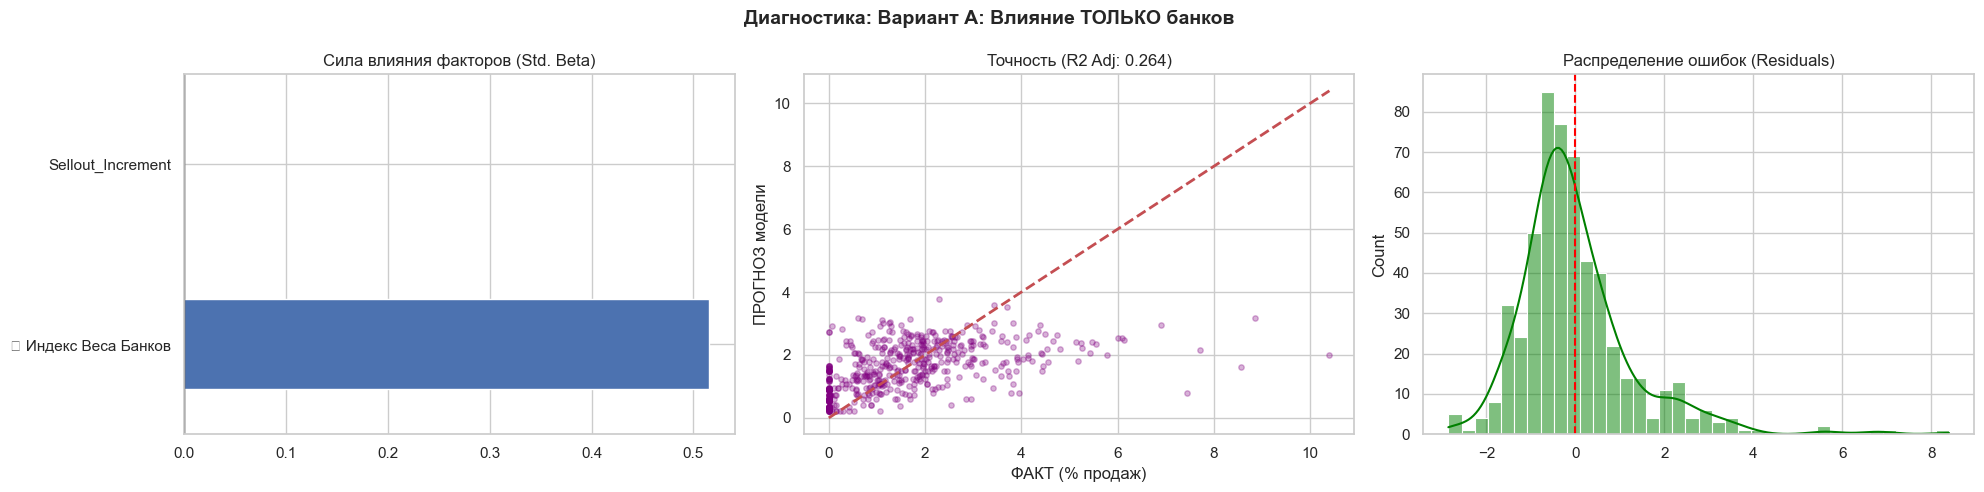

In [ ]:
# ШАГ 1: Один раз готовим данные (это может занять 10-20 секунд)
# Укажите свои пути к файлам
FILE_PROJ = "Проектные данные_2025-11-25.xlsx"
FILE_DEALS = "Сделки_2025-11-25.xlsx"


df_inc = prepare_incremental_dataset(FILE_PROJ, FILE_DEALS, horizon_months=12)

# ШАГ 2: Экспериментируем с моделями

# --- ВАРИАНТ А: "Чистый" эффект банков (без авторегрессии) ---
# Проверяем гипотезу: Влияют ли банки на продажи, если учесть ставку и возраст?
train_incremental_model(
    df_inc, 
    features=['Bank_Accumulated_Index'], 
    title="Вариант А: Влияние ТОЛЬКО банков "
)




🔬 МОДЕЛЬ: Вариант А: Влияние банков + Макро
                   Метрика  Значение                          Комментарий
            Adj. R-squared   0.34408           Чем ближе к 1.0, тем лучше
   RMSE (Ошибка % площади)   1.21531     В среднем ошибаемся на 1.22 п.п.
      MAE (Средний промах)   0.85759          Абсолютная ошибка 0.86 п.п.
Mean Target (Средний темп)   1.57092 Средняя скорость продаж: 1.57% в мес
------------------------------------------------------------------------------------------
                             Коэффициент (Beta)  Std. Error  P-value  \
Константа (Базовый уровень)             3.68010     0.91800  0.00007   
🏦 Индекс Веса Банков                    0.02084     0.00134  0.00000   
📅 Возраст проекта (мес)                -0.14717     0.01977  0.00000   
📉 Ключевая Ставка ЦБ                    0.00827     0.01423  0.56143   
🏗 Масштаб проекта (Log)                -0.27868     0.07848  0.00042   

                            Значимость  
Константа (Базовый у

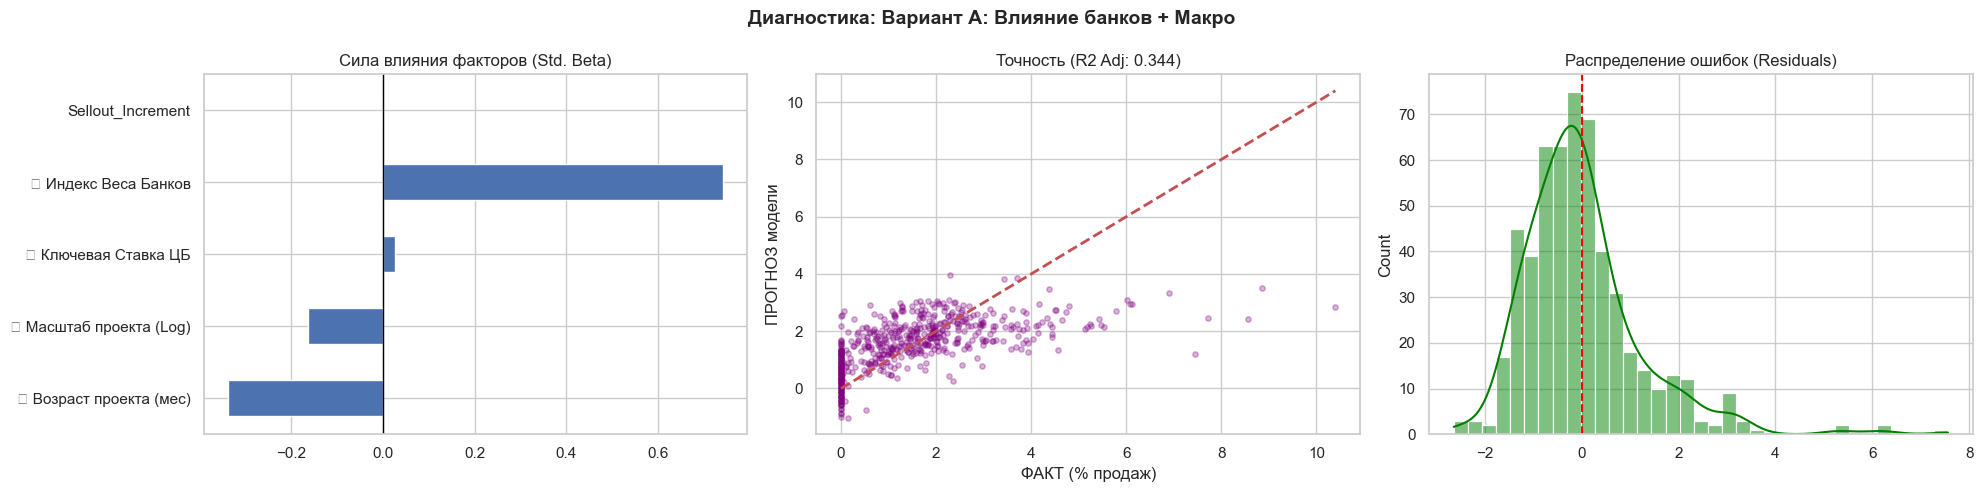

In [ ]:
# --- ВАРИАНТ А: "Чистый" эффект банков (без авторегрессии) ---
# Проверяем гипотезу: Влияют ли банки на продажи, если учесть ставку и возраст?
train_incremental_model(
    df_inc, 
    features=['Bank_Accumulated_Index', 'Month_Num', 'Key_Rate', 'Log_Total_Area'], 
    title="Вариант А: Влияние банков + Макро"
)


🔬 МОДЕЛЬ: Вариант Б: С учетом инерции продаж (Lag)
                   Метрика  Значение                          Комментарий
            Adj. R-squared   0.55390           Чем ближе к 1.0, тем лучше
   RMSE (Ошибка % площади)   1.00132     В среднем ошибаемся на 1.00 п.п.
      MAE (Средний промах)   0.67191          Абсолютная ошибка 0.67 п.п.
Mean Target (Средний темп)   1.57092 Средняя скорость продаж: 1.57% в мес
------------------------------------------------------------------------------------------
                                 Коэффициент (Beta)  Std. Error  P-value  \
Константа (Базовый уровень)                 1.50312     0.76936  0.05125   
🏦 Индекс Веса Банков                        0.00727     0.00140  0.00000   
📅 Возраст проекта (мес)                    -0.07780     0.01688  0.00001   
📉 Ключевая Ставка ЦБ                       -0.00639     0.01177  0.58724   
🏗 Масштаб проекта (Log)                    -0.08278     0.06589  0.20953   
🔄 Продажи прошлого месяца (Lag)

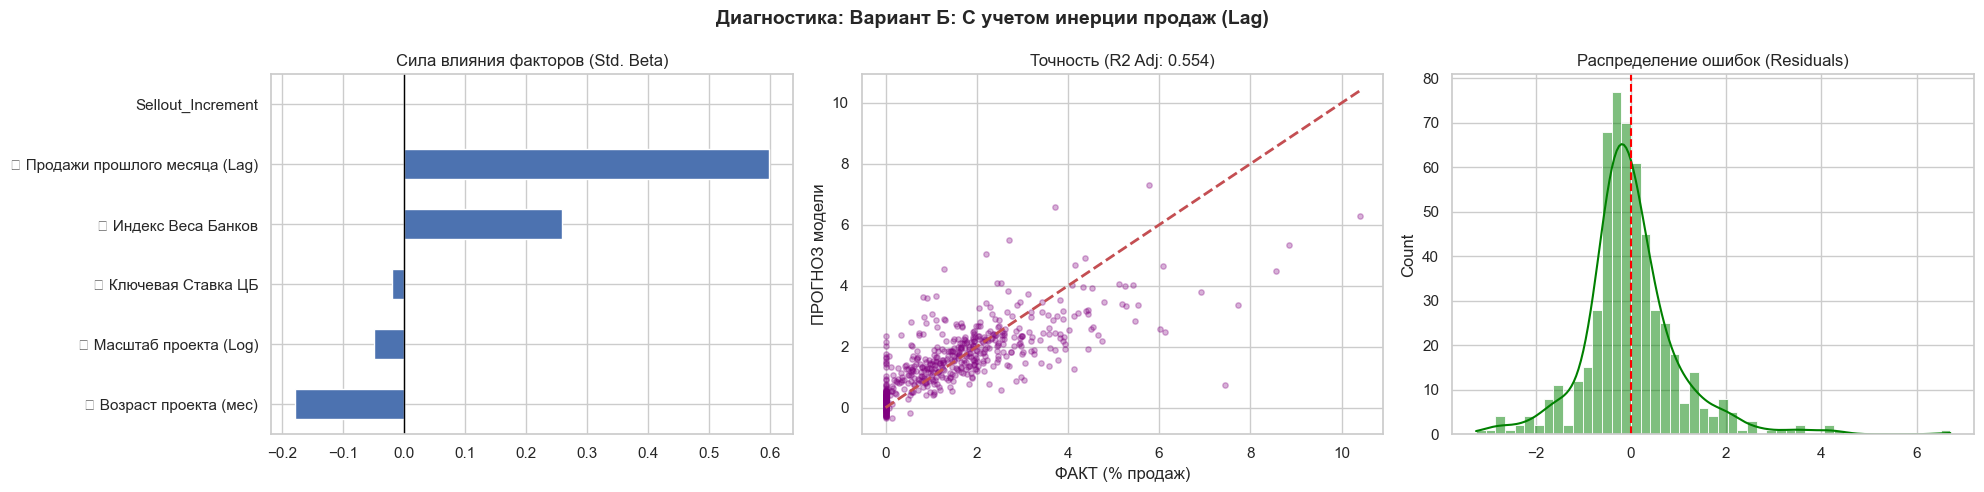

In [ ]:
# --- ВАРИАНТ Б: "Полный фарш" (с авторегрессией) ---
# Добавляем продажи прошлого месяца. R2 вырастет, но это может "съесть" значимость банков.
train_incremental_model(
    df_inc, 
    features=['Bank_Accumulated_Index', 'Month_Num', 'Key_Rate', 'Log_Total_Area', 'Prev_Month_Sellout'], 
    title="Вариант Б: С учетом инерции продаж (Lag)"
)

In [ ]:
df_inc = prepare_incremental_dataset(FILE_PROJ, FILE_DEALS, horizon_months=100)

🚀 ЗАПУСК ETL: Сборка инкрементального датасета (Горизонт: 100 мес)...
✅ Датасет собран: 4500 наблюдений.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Попробуем импортировать CatBoost, если нет - используем Random Forest
try:
    from catboost import CatBoostRegressor
    MODEL_TYPE = "CatBoost"
except ImportError:
    MODEL_TYPE = "RandomForest"

def train_ml_model(df, target="Sellout_Increment"):
    print(f"🚀 ЗАПУСК ML ({MODEL_TYPE}): Пробуем побить линейную регрессию...")
    'Bank_Accumulated_Index'
    # 1. Выбираем фичи
    # Исключаем текстовые поля и таргет. Оставляем всё числовое.
    # Если в df_inc есть категориальные фичи (Класс, Регион), для RF их надо кодировать, 
    # а CatBoost съест так. Пока берем числовые.
    features = [c for c in df.columns if c not in ["Project", "start_date", 'Prev_Month_Sellout','Bank_Accumulated_Index', target]]
    
    # Убираем строки с пропусками
    data = df.dropna(subset=features + [target])
    
    X = data[features]
    y = data[target]
    
    # 2. Split на обучение и тест (80% / 20%)
    # shuffle=False важно, если данные упорядочены по времени, но у нас панелька проектов,
    # лучше перемешать, чтобы модель видела разные проекты.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"   Обучающая выборка: {X_train.shape[0]} строк")
    print(f"   Тестовая выборка:  {X_test.shape[0]} строк")
    
    # 3. Инициализация и обучение модели
    if MODEL_TYPE == "CatBoost":
        model = CatBoostRegressor(
            iterations=1000, 
            learning_rate=0.05, 
            depth=6, 
            verbose=100,
            loss_function='RMSE'
        )
        # Если были бы категориальные фичи, передали бы параметр cat_features=[...]
        model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)
    else:
        # Random Forest (если нет катбуста)
        model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        
    # 4. Предикт
    preds_test = model.predict(X_test)
    preds_train = model.predict(X_train)
    
    return model, X_train, X_test, y_train, y_test, preds_train, preds_test, features

# Запускаем
model_ml, X_train, X_test, y_train, y_test, preds_train, preds_test, feature_names = train_ml_model(df_inc)

🚀 ЗАПУСК ML (CatBoost): Пробуем побить линейную регрессию...
   Обучающая выборка: 3600 строк
   Тестовая выборка:  900 строк
0:	learn: 0.8779175	test: 0.7791533	best: 0.7791533 (0)	total: 2.42ms	remaining: 2.42s
100:	learn: 0.4685703	test: 0.4865930	best: 0.4865930 (100)	total: 202ms	remaining: 1.8s
200:	learn: 0.4080532	test: 0.4582637	best: 0.4582468 (199)	total: 413ms	remaining: 1.64s
300:	learn: 0.3537323	test: 0.4311674	best: 0.4308975 (297)	total: 618ms	remaining: 1.43s
400:	learn: 0.3168706	test: 0.4191509	best: 0.4186268 (396)	total: 827ms	remaining: 1.24s
500:	learn: 0.2880709	test: 0.4193102	best: 0.4157029 (451)	total: 1.04s	remaining: 1.04s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4157028509
bestIteration = 451

Shrink model to first 452 iterations.



📊 РЕЗУЛЬТАТЫ НА ТЕСТЕ:
   R-squared: 0.7306 (Линейная модель давала около 0.2-0.4?)
   RMSE: 0.4157 % (Средняя ошибка в процентах от площади)
   MAE:  0.1379 %


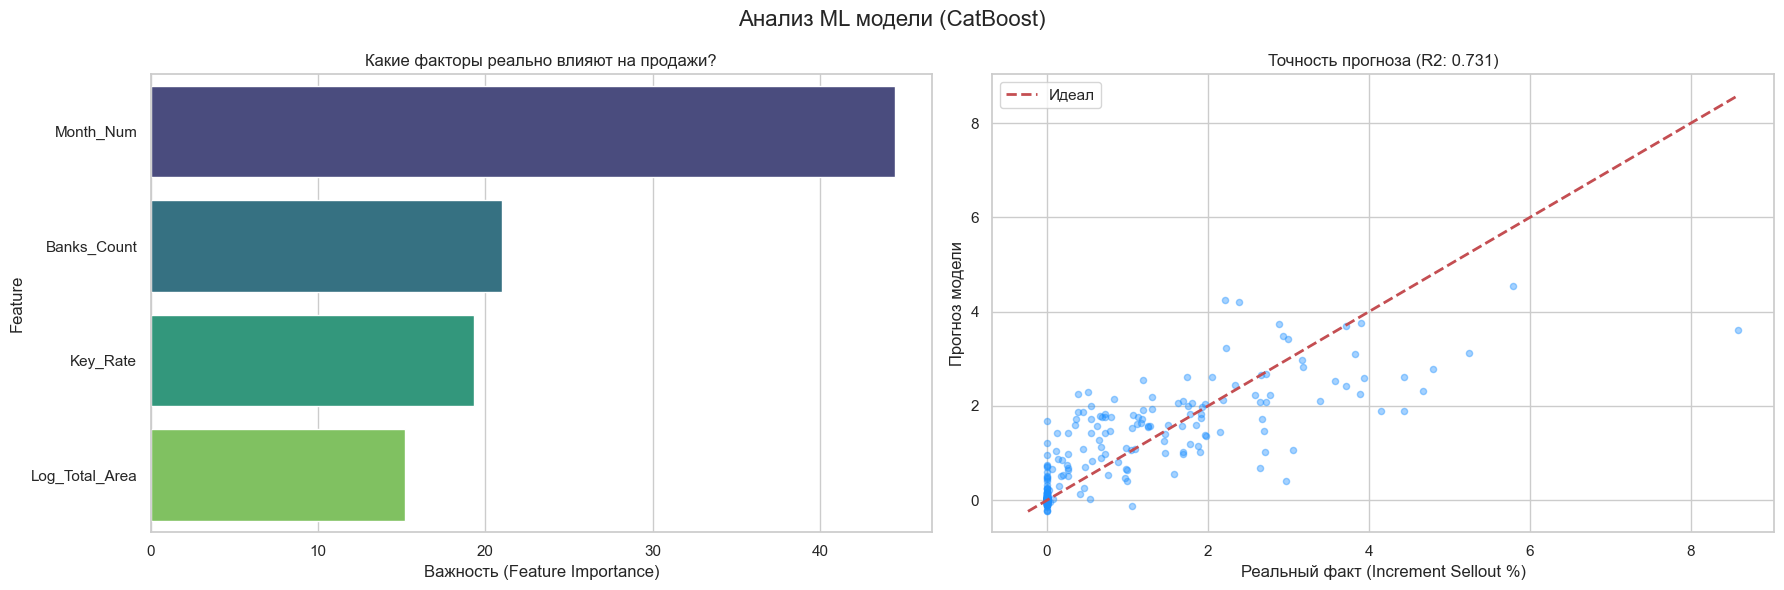

In [ ]:
def evaluate_ml_results(y_true, y_pred, model, features, title="ML Model Results"):
    # Метрики
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n📊 РЕЗУЛЬТАТЫ НА ТЕСТЕ:")
    print(f"   R-squared: {r2:.4f} (Линейная модель давала около 0.2-0.4?)")
    print(f"   RMSE: {rmse:.4f} % (Средняя ошибка в процентах от площади)")
    print(f"   MAE:  {mae:.4f} %")
    
    # Графики
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    plt.suptitle(f"Анализ ML модели ({MODEL_TYPE})", fontsize=16)
    
    # 1. Важность признаков
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        importances = model.get_feature_importance()
    else:
        importances = [0]*len(features)
        
    # Создаем DataFrame для красоты
    fi_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    fi_df = fi_df.sort_values(by='Importance', ascending=False)
    
    sns.barplot(x="Importance", y="Feature", data=fi_df, ax=axes[0], palette="viridis")
    axes[0].set_title("Какие факторы реально влияют на продажи?")
    axes[0].set_xlabel("Важность (Feature Importance)")
    
    # 2. Факт vs Прогноз
    axes[1].scatter(y_true, y_pred, alpha=0.4, color='dodgerblue', s=20)
    
    # Идеальная линия
    limits = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    axes[1].plot(limits, limits, 'r--', lw=2, label='Идеал')
    
    axes[1].set_xlabel("Реальный факт (Increment Sellout %)")
    axes[1].set_ylabel("Прогноз модели")
    axes[1].set_title(f"Точность прогноза (R2: {r2:.3f})")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

evaluate_ml_results(y_test, preds_test, model_ml, feature_names)